In [2]:
#@title Google Drive Connect
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


## **required** - Setup

### Install Dependencies - comet.ml, pytorch, etc

#### Pip

In [3]:
#@title uninstall typing-extensions for comet
INSTALL_COMET = True #@param {type:"boolean"}
if INSTALL_COMET:
    !pip uninstall typing-extensions -qy
    !pip install comet-ml -qU

     |████████████████████████████████| 266kB 4.3MB/s 
     |████████████████████████████████| 522kB 6.9MB/s 
     |████████████████████████████████| 61kB 5.9MB/s 
     |████████████████████████████████| 61kB 5.0MB/s 


In [5]:
#@title Install Additional Packages from pip
from tqdm.notebook import tqdm as tqdm
def run_subprocess_command(cmd):
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    for line in process.stdout:
        print(line.decode().strip())

import sys, subprocess

IN_COLAB = "google.colab" in sys.modules
colab_requirements = [
    "pip install -q yacs",
    "pip install -q ffmpeg",
    "pip install -q av",
    "pip install -q dlutils",
    "pip install -q piq",
    "pip install -q lpips",
    "pip install -q ray -U",
    "pip install -q ninja",
    "pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html",
    "git clone https://github.com/osmr/imgclsmob.git",
]
INSTALL_PIP = True #@param {type:"boolean"}
if INSTALL_PIP and IN_COLAB:
    for i in tqdm(colab_requirements):
        run_subprocess_command(i)

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Found existing installation: torch 1.8.1+cu101
Uninstalling torch-1.8.1+cu101:
Successfully uninstalled torch-1.8.1+cu101
Found existing installation: torchvision 0.9.1+cu101
Uninstalling torchvision-0.9.1+cu101:
Successfully uninstalled torchvision-0.9.1+cu101



#### Import core dependencies

In [1]:
 #@title Import Comet
from comet_ml import Experiment
import comet_ml
comet_ml.__version__

'3.9.0'

In [2]:
#@title Import Dependencies - note, ignores warnings here
import copy
import random
from math import log2, ceil
from datetime import datetime
from time import time as time
import os
import pathlib
import importlib
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn.functional as F
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torch.nn.functional import softplus
from torch.autograd import grad
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms.functional as tvF
from torchvision.utils import make_grid, save_image
from torchvision import transforms

import piq
import numpy as np
import pandas as pd
import ray

from skimage.util.shape import view_as_blocks
import cv2
import tqdm
from tqdm import tqdm_notebook, trange
from PIL import Image, ImageFile
import matplotlib.pyplot as plt

In [3]:
#@title Monkey Patch Path
def _copy(self, target):
    import shutil
    assert self.is_file()
    shutil.copy(str(self), str(target))  # str() only there for Python < (3, 6)

pathlib.Path.copy = _copy

### Download files to local instance - pull repos, copy gdrive datasets

In [9]:
#@title Clone CALAE repo
!git clone https://github.com/milesgray/CALAE.git

Cloning into 'CALAE'...
remote: Enumerating objects: 1209, done.
remote: Counting objects: 100% (179/179), done.
remote: Compressing objects: 100% (137/137), done.
remote: Total 1209 (delta 91), reused 104 (delta 42), pack-reused 1030
Receiving objects: 100% (1209/1209), 53.31 MiB | 30.46 MiB/s, done.
Resolving deltas: 100% (690/690), done.


In [10]:
%%bash
cd CALAE
git pull

Already up to date.


In [11]:
%%bash
#cd CALAE/loss/robust_loss_pytorch/; python3 setup.py install

In [12]:
#import robust_loss_pytorch

In [13]:
%%bash
cd CALAE
git checkout dataset.py
git pull
cd models/op/
python setup_fused.py install
python setup_up.py install

Already up to date.
running install
running bdist_egg
running egg_info
creating fused_bias_act_cpp.egg-info
writing fused_bias_act_cpp.egg-info/PKG-INFO
writing dependency_links to fused_bias_act_cpp.egg-info/dependency_links.txt
writing top-level names to fused_bias_act_cpp.egg-info/top_level.txt
writing manifest file 'fused_bias_act_cpp.egg-info/SOURCES.txt'
writing manifest file 'fused_bias_act_cpp.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_ext
building 'fused_bias_act_cpp' extension
creating /content/CALAE/models/op/build
creating /content/CALAE/models/op/build/temp.linux-x86_64-3.7
Emitting ninja build file /content/CALAE/models/op/build/temp.linux-x86_64-3.7/build.ninja...
Compiling objects...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
[1/1] c++ -MMD -MF /content/CALAE/models/op/build/temp.linux-x86_64-3.7/fused_bias_act.o.d -pthread -Wno-unu

zip_safe flag not set; analyzing archive contents...
__pycache__.fused_bias_act_cpp.cpython-37: module references __file__
zip_safe flag not set; analyzing archive contents...
__pycache__.upfirdn2d_cpp.cpython-37: module references __file__


In [14]:
#@title Clone Original Repo and switch branch
!git clone https://github.com/ivanvovk/controllable-face-generation.git
!cd controllable-face-generation; git checkout ACAI; git pull

Cloning into 'controllable-face-generation'...
remote: Enumerating objects: 261, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 261 (delta 2), reused 0 (delta 0), pack-reused 247
Receiving objects: 100% (261/261), 79.40 MiB | 39.83 MiB/s, done.
Resolving deltas: 100% (85/85), done.
Branch 'ACAI' set up to track remote branch 'ACAI' from 'origin'.
Switched to a new branch 'ACAI'
Already up to date.


In [ ]:
#@title Unzip Data - default root folder is 'data' in your gdrive, see main readme for shared copy of public

download_voxceleb= False #@param {type:"boolean"}
c = True #@param {type:"boolean"}

import pathlib

start = time.time()
if download_voxceleb:
    print(f"NOTE: If you want to use this dataset, you need to go find it and add it to your google drive at 'data/voxceleb_dataset.zip'")
    start = time.time()
    !unzip -qo '/content/gdrive/My Drive/data/voxceleb_dataset.zip' -d '/content/full/'
    filelist = [str(p) for p in pathlib.Path("/content/full/").rglob("*.*")]
    dt = time.time() - start
    print(f"Finished unzipping {len(filelist)} files after {dt // 60} minutes {dt % 60} seconds")

if download_fract_public:
    total_size_gb = 1
    total_images = 145
    filename = "public_fractal_data.zip"
    print(f"Downloading public fractal dataset with {total_images} images, {total_size_gb}GB total")
    !cp '/content/gdrive/My Drive/data/fractal/public_fractal_data.zip' '/content/public_fractal_data.zip'
    dt = time.time() - start
    print(f"Unzipping {filename} after {dt // 60} minutes {dt % 60} seconds")
    start = time.time()
    !unzip -qo '/content/public_fractal_data.zip' -d '/content/full/'
    filelist = [str(p) for p in pathlib.Path("/content/full/").rglob("*.*")]
    dt = time.time() - start
    print(f"Finished unzipping {len(filelist)} files after {dt // 60} minutes {dt % 60} seconds")



## *optional* - Movie Test

In [ ]:
movie_path = pathlib.Path('/content/gdrive/My Drive/data/fractal/public_fractal_video.mp4')

In [ ]:
local_root = pathlib.Path('/content/video/')
if not local_root.exists():
    local_root.mkdir(parents=True)

In [ ]:
path.copy(local_root / movie_path.name)

In [ ]:
local_movie_paths = [p for p in local_root.glob("*.mp4")]
local_movie_paths

In [ ]:
!ls -la /content/video

In [ ]:
class MovieLoader:
    def __init__(self, path, timestamps):
        self.paths = path
        self.timestamps = timestamps
        self.pts = timestamps[0]
        self.total_pts = len(self.pts)
    def __getitem__(self, idx):
        for i in range(start_pt, total_pts, batch_size+skip):
            pts = timestamp_data[0]
            movie_frames = torchvision.io.read_video(str(path), start_pts=pts[0], end_pts=pts[5])
            yield movie_frames

In [ ]:
def get_frames(mappings, start_pt=0, batch_size=1, skip=0):
    for idx, (path, timestamp_data) in enumerate(mappings.items()): 
        stem = pathlib.Path(path).stem
        pts = timestamp_data[0]
        total_pts = len(pts)
        for i in range(start_pt, total_pts, batch_size+skip):
            movie_frames = torchvision.io.read_video(str(path), start_pts=pts[i], end_pts=pts[i+batch_size])
            yield movie_frames[0], idx, stem

In [ ]:
timestamp_mappings = {}
for path in tqdm.tqdm_notebook(local_movie_paths):
    timestamp_mappings[str(path)] = torchvision.io.read_video_timestamps(str(path))

timestamp_mappings.keys()

In [ ]:
len(timestamp_mappings['/content/video/public_fractal_video.mp4'][0])

In [ ]:
total_frames = 0
for k, v in timestamp_mappings.items():
    total_frames += len(v[0])
total_frames

In [ ]:
SKIP_FRAMES = 20
with tqdm_notebook(total=total_frames//SKIP_FRAMES, unit='Images', unit_scale=True, unit_divisor=1, desc="Epochs") as pbar:
    for i, (frames, idx, stem) in enumerate(get_frames(timestamp_mappings, batch_size=1, skip=SKIP_FRAMES)):
        movie_name = stem
        frames = frames.chunk(frames.shape[0])
        for j, frame in enumerate(frames):            
            img = Image.fromarray(frame.detach().numpy().squeeze(), mode="RGB")        
            img.save(f"/content/full/{movie_name}--{i}-{j}.png")
            pbar.update(1)

In [ ]:
[p for p in all_paths if "all" in str(p)]

[]

In [ ]:
!rm -r /content/full/all

## **required** - Import CALAE Dependencies

In [5]:
#@title Import from repo
import sys
sys.path.append("/content/CALAE/")

from utils import sample_noise, find_alpha, allow_gradient, \
                  adjust_lr, linear_scale_lr, save_batch, \
                  save_reconstructions, ensure_dir, \
                  ensure_parent_dir, img_from_tensor

import net

import utils
import losses
import metrics
import dataset
from optimizers import LREQAdam, Adai, AdaiW, SphericalOptimizer
import loss
from loss import noise as noise
from loss.IQA.watson_fft import WatsonDistanceFft
from loss.IQA.watson import WatsonDistance
from loss.super_res.sr import GradientLoss
from loss.super_res.sr import FSLoss, FilterHigh, CharbonnierLoss, GradientLoss, GradientPenaltyLoss
from loss import IQA

## **required** - Create Dataset

In [6]:
#@title Monkey Patch Path
def _copy(self, target):
    import shutil
    assert self.is_file()
    shutil.copy(str(self), str(target))  # str() only there for Python < (3, 6)

pathlib.Path.copy = _copy

In [7]:
#@title Make Fractal Data Object
PATH = "/content/full"

all_paths = [p for p in pathlib.Path(PATH).glob("*")]
fract = dataset.Fractal(path = PATH)
fract_lbl = dataset.FractalLabel(path = PATH)
total_imgs = len(all_paths)
total_imgs

145

## **required** - Start Comet Experiment

In [ ]:
#@title Start Comet Experiment
comet_enabled = False #@param {type:"boolean"}    
comet_api_key = "" #@param {type:"string"}
comet_project_name = "" #@param {type:"string"}
comet_workspace = "" #@param {type:"string"}

# warning: enabled flag is not used everywhere yet, this code
# really only works as it currently is with comet
comet_config = {
    "enabled": comet_enabled,
    "api_key": comet_api_key,
    "project_name": comet_project_name,
    "workspace": comet_workspace
}

if comet_config["enabled"]:
    experiment = Experiment(api_key=comet_config["api_key"],
                            project_name=comet_config["project_name"], 
                            workspace=comet_config["workspace"],
                            auto_weight_logging=True,
                            log_code=True)

In [ ]:
if comet_config["enabled"]:
    experiment.log_asset_folder('/content/CALAE/', recursive=True)
    experiment.log_asset('/content/gdrive/My Drive/Colab Notebooks/train_alae.ipynb')
else:
    print("Comet.ml logging not enabled")

## *optional* - Test DataLoader

In [27]:
importlib.reload(dataset)
import dataset

In [28]:
fract_lbl = dataset.FractalLabel(path = PATH)

In [29]:
dataloader = dataset.make_fractal_clr_dataloader(fract_lbl, 64, image_size=16, crop_mode=8, num_workers=3)

In [30]:
batch = enumerate(next(iter(dataloader)))

In [31]:
type(batch)

enumerate

In [32]:
for batch_idx, datum in batch:
    print(batch_idx)
    print(type(datum))
    #print(data[1].shape)
    #print(data[2].shape)
    break

0
<class 'torch.Tensor'>


In [33]:
datum.shape, datum.min(), datum.max()

(torch.Size([64, 8, 3, 16, 16]), tensor(-1.), tensor(509.))

In [34]:
for batch_idx, datums in enumerate(dataloader):
    (real_samples, labels, coords) = datums
    #print(f"coords: {coords.shape}")
    print(f"label: {labels.shape}")    
    bs, ncrops, c, h, w = real_samples.size()
    labels = labels.view(-1)
    coords = coords.view(-1, 6)
    #scale to -1, 1
    real_samples = ((real_samples+1)/(255*2)-0.5)*2
    result = real_samples.view(-1, c, h, w)
    print(f"result: {result.shape}")
    print(f"label: {labels.shape}")    
    print(f"coords: {coords.shape}")  
    break

label: torch.Size([64, 8])
result: torch.Size([512, 3, 16, 16])
label: torch.Size([512])
coords: torch.Size([512, 6])


In [35]:
result.max(), result.min()

(tensor(1.), tensor(-1.))

In [36]:
crop_pad = 0.1
crop_size = 512
h = 520
w = 94
if h < w:
    ratio_h = 1
    ratio_w = w / h
    ratio_r = crop_size / h
else:
    ratio_h = h / w
    ratio_w = 1
    ratio_r = crop_size / w
    
h = int(int(h * ratio_r) + int(crop_size * crop_pad) * ratio_h)
w = int(int(w * ratio_r) + int(crop_size * crop_pad) * ratio_w)
h, w

(3114, 563)

In [37]:
ratio = 512 / 16
x1, y1, x2, y2, h, w = coords[30].numpy().tolist()
x1, y1, x2, y2, h, w, int(h * ratio), int(w * ratio)

(0.0, 49.0, 16.0, 65.0, 16.0, 16.0, 512, 512)

In [38]:

int(x1 * ratio), int(x2 * ratio), abs(int(x1 * ratio) - int(x2 * ratio))

(0, 512, 512)

In [39]:
def area(c):
    x1, y1, x2, y2, h, w = c.numpy().tolist()
    h2 = x2 - x1
    w2 = y2 - y1
    return h2 * w2, (h2,  w2), (h, w)

In [40]:
area(coords[0])

(256.0, (16.0, 16.0), (16.0, 16.0))

In [51]:
%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

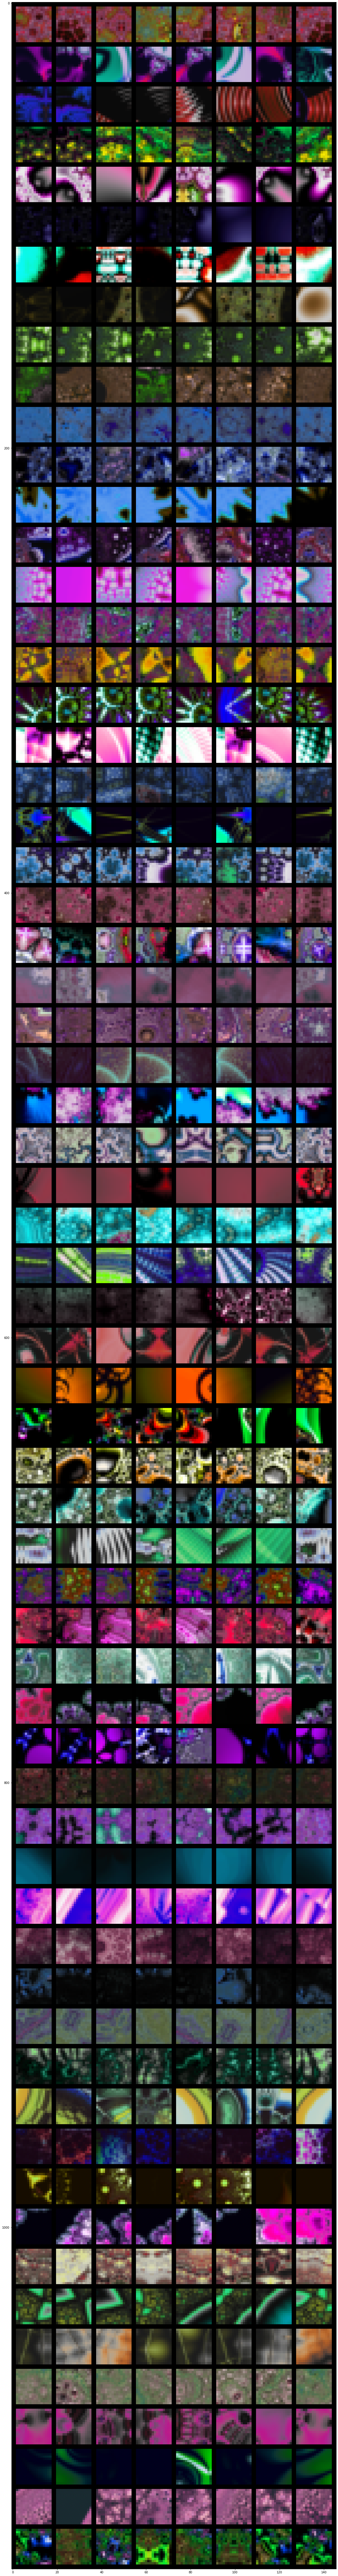

In [52]:
plt.figure(figsize=(result.shape[-2] * 10, result.shape[-1] * 10))
#standard_results = ((result+1)/(255*2)-0.5)*2
grid = make_grid(result, range=(-1,1), normalize=True, nrow=ncrops)
show(grid)

In [53]:
import torchvision.transforms.functional as TF

In [54]:
def random_crop(x, w, h, crop_size, crop_pad=0.1, use_pad=False):
    # get total height and width of crop
    if isinstance(crop_size, int):
        th, tw = crop_size, crop_size
    elif isinstance(crop_size, float):
        th, tw = int(crop_size), int(crop_size)
    else:
        th, tw = int(crop_size[0]), int(crop_size[1])
    if use_pad:
        # calculate ratio to modify padding by to make it balanced on rectangles
        if h < w:
            ratio_h = h / w
            ratio_w = 1.
        else:
            ratio_w = w / h
            ratio_h = 1.
        # calculate padding to ensure no overlap with corners
        ph = int(h * crop_pad * ratio_h)
        pw = int(w * crop_pad * ratio_w)
    else:
        ph = pw = 0
    # calculate available space left over after crop and padding (max x/y)
    available_h = h - th - ph
    available_w = w - tw - pw  
    padding_h = padding_w = 0         
    if available_h < 0:
        # this much extra room needed in height
        padding_h = abs(available_h)
    if available_w < 0:
        # this many extra pixels needed in width
        padding_w = abs(available_w)
    available_h += padding_h
    available_w += padding_w
    print(f"avail h: {available_h}, avail w: {available_w}")

    if available_h > 0 and available_h > pw:
        mod_h = random.randint(pw, available_h)
    if available_w > 0 and available_w > ph:
        mod_w = random.randint(ph, available_w)

    x1, y1, x2, y2 = mod_h, mod_w, mod_h + th - padding_h, mod_w + tw - padding_w
    # torchvision.transforms.functional.crop(img, top, left, height, width)
    return TF.crop(x, y1, x1, abs(y2-y1), abs(x2-x1)), (x1, y1, x2, y2, h, w)


/content/full/kalibrot_004.png
shape: (4096, 2160)
h: 4096, w: 2160
avail h: 3584, avail w: 1648


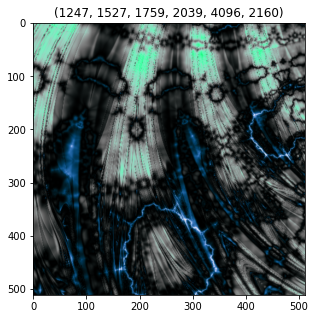

In [56]:
#@title Preview Data for sanity check
selected_preview = random.randint(0,total_imgs-1)
print(f"{all_paths[selected_preview]}")
#img = cv2.imread(str(all_paths[selected_preview]))
filename = str(all_paths[selected_preview])
img = Image.open(str(all_paths[selected_preview].parent / filename)).convert('RGB')
print(f"shape: {img.size}")
h, w = img.size
print(f"h: {h}, w: {w}")
img, coords = random_crop(img, w, h, 512)

plt.figure(figsize=(img.size[0]//100,img.size[1]//100))
plt.title(str(coords))
plt.imshow(img)

## *optional* - Test Dataset

/content/full/PSX_20191219_192110.jpg
shape: (4480, 2552)
imgs shape: 5(512, 512)


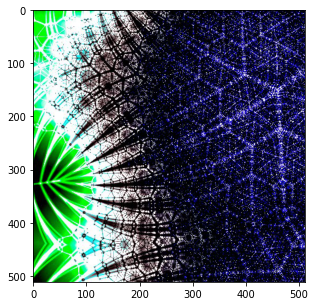

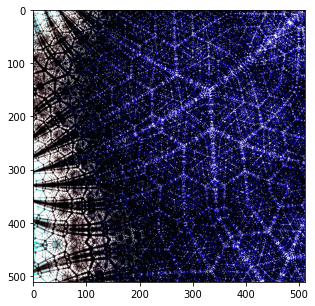

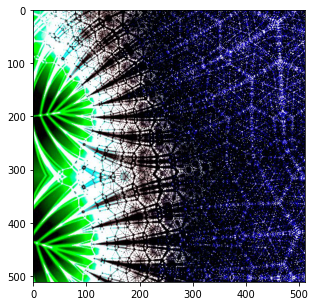

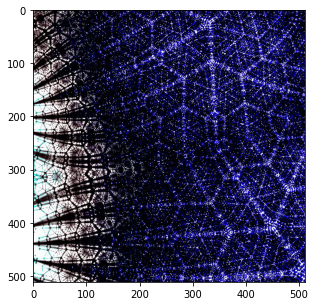

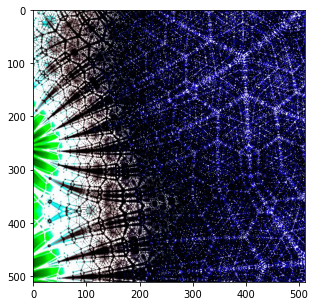

In [64]:
#@title Preview Data for sanity check
USE_RANDOM_IMAGE = True #@param {type:"boolean"}
STATIC_IMG_INDEX = 2 #@param {type:"integer"}
selected_preview = random.randint(0,total_imgs-1) if USE_RANDOM_IMAGE \
                   else STATIC_IMG_INDEX
print(f"{all_paths[selected_preview]}")

filename = str(all_paths[selected_preview])
img = Image.open(str(all_paths[selected_preview].parent / filename)).convert('RGB')
print(f"shape: {img.size}")
img = transforms.RandomCrop(int(512*1.25))(img)
imgs = transforms.FiveCrop(512)(img)
print(f"imgs shape: {len(imgs)}{imgs[0].size}")
for img in imgs:
    plt.figure(figsize=(img.size[0]//100,img.size[1]//100))
    plt.imshow(img)

/content/full/PSX_20191219_192110.jpg
shape: (4480, 2552)
imgs shape: 5(512, 512)


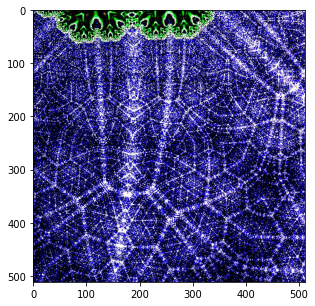

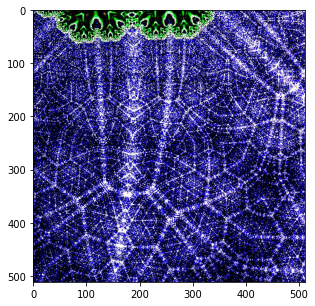

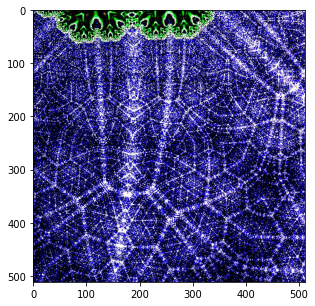

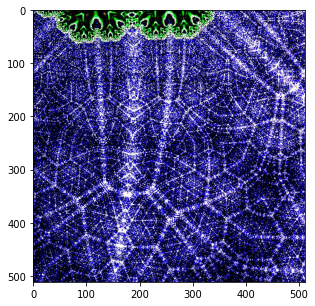

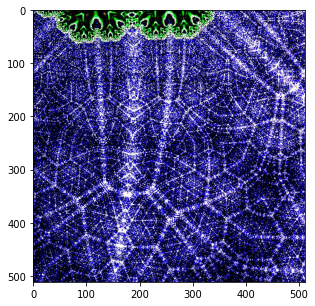

In [65]:
#@title preview random crop then 5 crop
print(f"{all_paths[selected_preview]}")

img = Image.open(str(all_paths[selected_preview])).convert('RGB')
print(f"shape: {img.size}")
img = transforms.RandomCrop(int(512))(img)
imgs = transforms.FiveCrop(512)(img)
print(f"imgs shape: {len(imgs)}{imgs[0].size}")
for img in imgs:
    plt.figure(figsize=(img.size[0]//100,img.size[1]//100))
    plt.imshow(img)

/content/full/PSX_20191219_192110.jpg
shape: (4480, 2552)
imgs shape: 5(512, 512)


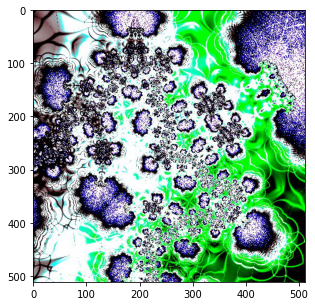

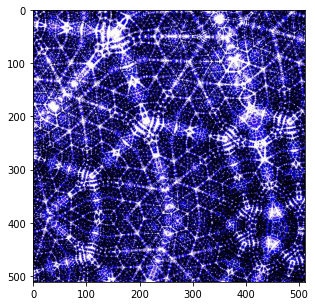

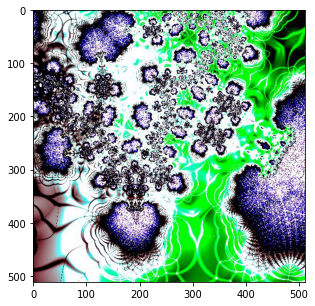

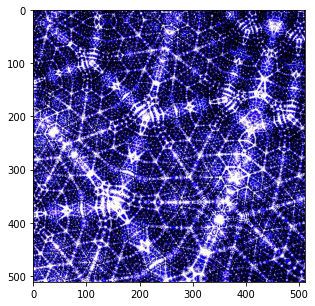

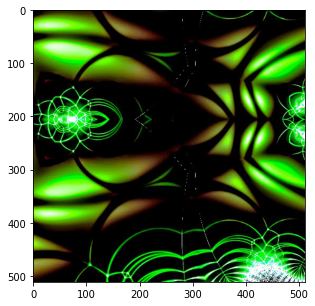

In [66]:
#@title Preview 5 crop
print(f"{all_paths[selected_preview]}")

img = Image.open(str(all_paths[selected_preview])).convert('RGB')
print(f"shape: {img.size}")
imgs = transforms.FiveCrop(512)(img)
print(f"imgs shape: {len(imgs)}{imgs[0].size}")
for img in imgs:
    plt.figure(figsize=(img.size[0]//100,img.size[1]//100))
    plt.imshow(img)

In [63]:
clr_dataloader = dataset.make_fractal_clr_dataloader(fract, batch_size=64, image_size=64, crop_size=512, crop_mode=7)
clr_batch = next(iter(clr_dataloader))
type(clr_batch), clr_batch[0].shape, clr_batch[1].shape

(list, torch.Size([64, 7, 3, 64, 64]), torch.Size([64, 7, 6]))

## **required** - Setup

In [10]:
# Accelerate training since fixed input sizes
torch.backends.cudnn.benchmark = True 

In [11]:
#@title Load Pretrained Model
LOAD_MODEL = False #@param {type:"boolean"}
LOAD_CURRENT_MODEL = False #@param {type:"boolean"}
LOAD_MODEL_PATH = '/content/saved/best_64.pt' #@param {type:"string"}
if LOAD_MODEL:
    model_dict = torch.load(LOAD_MODEL_PATH, map_location='cpu')
    print(f"LOADED MODEL: {LOAD_MODEL_PATH}\n{model_dict.keys()}")
elif LOAD_CURRENT_MODEL:
    model_dict = {
        'F': F.state_dict(),
        'G': G.state_dict(),
        'E': E.state_dict(),
        'D': D.state_dict(),
        'G_average': G_average.state_dict()
    }
    print(f"LOADED CURRENT MODEL:\n{model_dict.keys()}")
else:
    model_dict = {}

In [ ]:
#@title SAVE FOLDER VERSION
root_folder = "/content/data/fract"  #@param {type:"string"}
experiment_version = "0" #@param {type:"string"}
max_resolution = 512 #@param {type:"integer"}

root = pathlib.Path(root_folder)
experiment_name = f'fract_test_{max_resolution}_{experiment_version}'
experiment_root = root / experiment_name
if not experiment_root.exists():
    experiment_root.mkdir(parents=True)
    print(f"Made {experiment_root}")
else:
    print(f"Exists {str(experiment_root)}")

In [13]:
#@title Copy Local Dataset to GDrive
SAVE_LOCAL_DATASET = False #@param {type:"boolean"}
DATASET_NAME = '' #@param {type:"string"}
if SAVE_LOCAL_DATASET:
    print(f"NOTE: expects a zip file with '{DATASET_NAME}' to exist in '/content/'")
    #!zip -o '/content/.zip' -r '/content/full/' -q    
    zip_path = pathlib.Path(f'/content/{DATASET_NAME}')
    dest_path = pathlib.Path(f'/content/gdrive/My Drive/data/fractal/{DATASET_NAME}')
    zip_path.copy(dest_path)

In [14]:
#@title Copy Local version of CALAE Code to GDrive 'data' folder
SAVE_LOCAL_REPO = True #@param {type:"boolean"}
if SAVE_LOCAL_REPO:
    !zip -o '/content/gdrive/My Drive/data/calae.zip' -r /content/CALAE -q
    zip_path = pathlib.Path('/content/gdrive/My Drive/data/calae.zip')
    zip_path.copy(experiment_root / 'calae.zip')

In [15]:
#@title Model Hyperparameter Selection
# Applies a gaussian blur after activations, 
# from original implementation
BLUR_ACTIVATIONS = True #@param {type:"boolean"}
# use Explicit Coord Convolutional layers in Generator and Encoder, 
# requires data loader to return a bounding box of each crop,
# then the box data must be passed to each model's forward call (...,bbox=bbox)
USE_COORDS = False #@param {type:"boolean"}
### Feature Projection Model
# Activation function to use throughout model
F_ACT = "gelu" #@param ["none", "mish", "gelu", "leaky", "relu", "prelu", "selu", "hardshrink", "celu", "rrelu", "elu", "hardtanh", "hardswish", "logsigmoid", "logcosh", "xtanh", "tanhshrink", "softmin", "softsign", "softshrink", "softplus"]
# Normalization to use in each block
F_NORM = "none" #@param ["none", "pixel", "instance", "batch", "act", "group", "local"]
### Encoder Model
# enable an affine transform after blur with an updatable kernel
E_LEARN_BLUR = True #@param {type:"boolean"}
# use learnable weights on how much to blend each encoder's internal
# style features - otherwise, just adds them together
E_LEARN_BLEND = True #@param {type:"boolean"}
# Activation function to use throughout model
E_ACT = "mish" #@param ["none", "mish", "gelu", "leaky", "relu", "prelu", "selu", "hardshrink", "celu", "rrelu", "elu", "hardtanh", "hardswish", "logsigmoid", "logcosh", "xtanh", "tanhshrink", "softmin", "softsign", "softshrink", "softplus"]
# Normalization to use in each block
E_NORM = "none" #@param ["none", "pixel", "instance", "batch", "act", "group", "local"]
### Generator Model
# enable an affine transform after blur with a learnable kernel
G_LEARN_BLUR = True #@param {type:"boolean"}
# applies a learnable gaussian blur to the style feature passed into each block
G_LEARN_STYLE = False #@param {type:"boolean"}
# adds 2 learnable weights that determine how much of a residual skip connection
# is added to the output of each block - otherwise there is no residual connection
G_LEARN_RESIDUAL = False #@param {type:"boolean"}
# applies a learnable gaussian blur to the noise feature passed into each block
G_LEARN_NOISE = False #@param {type:"boolean"}
# Activation function to use throughout model
G_ACT = "mish" #@param ["mish", "gelu", "leaky", "relu", "prelu", "selu", "hardshrink", "celu", "rrelu", "elu", "hardtanh", "hardswish", "logsigmoid", "logcosh", "xtanh", "tanhshrink", "softmin", "softsign", "softshrink", "softplus"]
# Normalization to use in each block
G_NORM = "instance" #@param ["pixel", "instance"]
### Discriminator Model
# Activation function to use throughout model
D_ACT = "mish" #@param ["none", "mish", "gelu", "leaky", "relu", "prelu", "selu", "hardshrink", "celu", "rrelu", "elu", "hardtanh", "hardswish", "logsigmoid", "logcosh", "xtanh", "tanhshrink", "softmin", "softsign", "softshrink", "softplus"]
# Normalization to use in each block
D_NORM = "none" #@param ["none", "pixel", "instance", "batch", "act", "group", "local"]
### Other
# number of views to consider when using Noise Contrastive Estimation
NUMBER_CROP_NCE = 6 #@param {type:"integer"}
# how big each patch is when using Patch Discriminator
DP_PATCH_SIZE = 4 #@param {type:"integer"}

### Create Models

In [16]:
TOTAL_IMAGES = len(fract)

def calc_steps(batch_size, epochs, total_images=TOTAL_IMAGES):
    return (total_images // batch_size) * epochs
def calc_total_steps(scale, per_scale):
    return sum([v for k,v in per_scale.items() if k < scale])

In [17]:
DEVICE = 'cuda:0'

SAVE_IMAGES_EACH = 8**2 # calculated in training code

EPOCHS_PER_SCALE = 100

VALID_SCALES = [4, 8, 16, 32, 64, 128, 256, 512]

epochs_by_scale = {4: 100, 8: 100, 16: 200, 32: 250, 64: 250, 128: 250, 256: 300, 512: 300}

code_length = 512
bs_per_scale = {4: 64, 8: 64, 16: 64, 32: 16, 64: 8, 128: 4, 256: 2, 512: 1}
lr_per_resolution = {4: 0.0015, 8: 0.0015, 16: 0.0015, 32: 0.0005, 64: 0.0005, 128: 0.0005, 256: 0.0003, 512: 0.0002}
steps_per_scale = {k: calc_steps(v, epochs_by_scale[k]) for k, v in bs_per_scale.items()}
total_steps_at_scale = {k: calc_total_steps(k, steps_per_scale) for k in bs_per_scale.keys()}

total_resolutions = len(bs_per_scale.keys())
MAX_RESOLUTION = max_resolution

ImageFile.LOAD_TRUNCATED_IMAGES = True
EPOCHS_PER_SCALE, SAVE_IMAGES_EACH, total_resolutions, MAX_RESOLUTION

(100, 64, 8, 512)

In [18]:
hyperparams = {
    "comet_save_model_graph": "G",
    "save_images_per_steps_by_scale": {4: 50, 8: 25, 16: 15, 32: 10, 64: 5, 128: 5, 256: 5, 512: 10},
    "epochs_by_scale": epochs_by_scale, #{4: 100, 8: 100, 16: 200, 32: 250, 64: 250, 128: 250, 256: 300, 512: 300},
    "batch_size_by_scale": bs_per_scale, #{4: 64, 8: 64, 16: 64, 32: 16, 64: 8, 128: 4, 256: 2, 512: 1},
    "valid_scales": VALID_SCALES, #[8, 16, 32, 64, 128, 256, 512, 1024],
    "steps_per_scale": steps_per_scale,
    "total_steps_at_scale": total_steps_at_scale,
    "code_length": code_length,
    "total_resolutions": total_resolutions,
    "max_resolution": MAX_RESOLUTION,
    "lr_by_resolution": lr_per_resolution, #{4: 0.0015, 8: 0.0015, 16: 0.0015, 32: 0.0005, 64: 0.0005, 128: 0.0005, 256: 0.0003, 512: 0.0002},
    "use_scheduling": True,
    "load_truncated_images": ImageFile.LOAD_TRUNCATED_IMAGES,
    "max_loss": { "G": 1000, "Ga": 1000, "D": 100, "AE": 1000, },
    "loss_weight": {"G": 1, "Ga": 1, "Gc": 0.1, "D": 1, "AE": 0.01,},
    "hessian_weight":{ "G": 0.001, "Ga": 0.001, "D": 0.001, "AE": 0.0001, },
    "blur_activations": True,
    "d_depth": 3,
    "d_act": D_ACT,
    "d_norm": D_NORM,
    "dp_patch_size": DP_PATCH_SIZE,
    "f_act": F_ACT,
    "f_norm": F_NORM, 
    "f_use_pixel_norm": F_USE_PIXEL_NORM,   
    "e_act": E_ACT,
    "e_norm": E_NORM,
    "e_learn_blur": E_LEARN_BLUR,
    "e_learn_blend": E_LEARN_BLEND,
    "e_use_coords": USE_COORDS,
    "e_layers":{
                512:{"enc":[8,4],"rgb":8},
                256:{"enc":[4,4],"rgb":4},
                128:{"enc":[4,2],"rgb":4},
                64:{"enc":[2,2],"rgb":2},
                32:{"enc":[2,1],"rgb":2},
                16:{"enc":[1,1],"rgb":1},
                8:{"enc":[1,1],"rgb":1},
                4:{"enc":[1,1],"rgb":1}},
    "g_learn_blur": G_LEARN_BLUR,
    "g_learn_residual": G_LEARN_RESIDUAL,
    "g_learn_style": G_LEARN_STYLE,
    "g_learn_noise": G_LEARN_NOISE,
    "g_use_coords": USE_COORDS,
    "g_act": G_ACT,
    "g_norm": G_NORM,
    "g_layers":{4:{"gen":[1,1],"rgb":1},
                8:{"gen":[1,1],"rgb":1},
                16:{"gen":[1,1],"rgb":1},
                32:{"gen":[1,2],"rgb":2},
                64:{"gen":[2,2],"rgb":2},
                128:{"gen":[2,4],"rgb":4},
                256:{"gen":[4,4],"rgb":4},
                512:{"gen":[4,8],"rgb":8}},
    "nce_t": 7e-2,
    "nce_num_crop": NUMBER_CROP_NCE,
}
experiment.log_parameters(hyperparams)

In [19]:
"steps per scale", steps_per_scale, "total_steps_at_scale", total_steps_at_scale

('steps per scale',
 {4: 200,
  8: 200,
  16: 400,
  32: 2000,
  64: 4000,
  128: 8000,
  256: 19500,
  512: 39000},
 'total_steps_at_scale',
 {4: 0, 8: 200, 16: 400, 32: 800, 64: 2800, 128: 6800, 256: 14800, 512: 34300})

In [20]:
hyperparams["g_layers"]

{4: {'gen': [1, 1], 'rgb': 1},
 8: {'gen': [1, 1], 'rgb': 1},
 16: {'gen': [1, 1], 'rgb': 1},
 32: {'gen': [1, 2], 'rgb': 2},
 64: {'gen': [2, 2], 'rgb': 2},
 128: {'gen': [2, 4], 'rgb': 4},
 256: {'gen': [4, 4], 'rgb': 4},
 512: {'gen': [4, 8], 'rgb': 8}}

In [21]:
models = {}

In [22]:
models["F"] = net.FeatureProjectionNetwork(code=hyperparams["code_length"], 
                                           depth=hyperparams["total_resolutions"], 
                                           norm=hyperparams["f_norm"], 
                                           act=hyperparams["f_act"]).to(DEVICE)
models["G"] = net.StyleGenerator(max_fm=hyperparams["max_resolution"], 
                                 code=hyperparams["code_length"], 
                                 blur_upsample=hyperparams["blur_activations"], 
                                 learn_blur=hyperparams["g_learn_blur"],
                                 learn_residual=hyperparams["g_learn_residual"], 
                                 learn_style=hyperparams["g_learn_style"], 
                                 learn_noise=hyperparams["g_learn_noise"], 
                                 use_coord=hyperparams["g_use_coords"],
                                 blocks=hyperparams["g_layers"],
                                 act=hyperparams["g_act"],
                                 norm=hyperparams["g_norm"],
                                 verbose=True).to(DEVICE)
models["G_average"] = net.StyleGenerator(max_fm=hyperparams["max_resolution"], 
                                         code=hyperparams["code_length"], 
                                         blur_upsample=hyperparams["blur_activations"], 
                                         learn_blur=hyperparams["g_learn_blur"],
                                         learn_residual=hyperparams["g_learn_residual"], 
                                         learn_style=hyperparams["g_learn_style"], 
                                         learn_noise=hyperparams["g_learn_noise"], 
                                         use_coord=hyperparams["g_use_coords"],
                                         blocks=hyperparams["g_layers"],
                                         act=hyperparams["g_act"],
                                         norm=hyperparams["g_norm"],
                                         verbose=True).to(DEVICE) # Clone Generator to track EMA
models["G_average"].load_state_dict(models["G"].state_dict())
models["G_average"].eval()

models["E"] = net.Encoder(max_fm=hyperparams["max_resolution"], 
                          code=hyperparams["code_length"], 
                          fc_intital=True, 
                          blur_downsample=hyperparams["blur_activations"], 
                          learn_blur=hyperparams["e_learn_blur"],
                          learn_blend=hyperparams["e_learn_blend"], 
                          use_coord=hyperparams["e_use_coords"],
                          blocks=hyperparams["e_layers"],
                          verbose=True).to(DEVICE)
models["D"] = net.Discriminator(code=hyperparams["code_length"], 
                                depth=hyperparams["d_depth"], 
                                norm=hyperparams["d_norm"], 
                                act=hyperparams["d_act"]).to(DEVICE)
models["F"].state_dict().keys()

[StyleGenerator]	 Block 0 for scale 4 with settings: {'gen': [1, 1], 'rgb': 1}
[StyleGenerator]	 Block 1 for scale 8 with settings: {'gen': [1, 1], 'rgb': 1}
[StyleGenerator]	 Block 2 for scale 16 with settings: {'gen': [1, 1], 'rgb': 1}
[StyleGenerator]	 Block 3 for scale 32 with settings: {'gen': [1, 2], 'rgb': 2}
[StyleGenerator]	 Block 4 for scale 64 with settings: {'gen': [2, 2], 'rgb': 2}
[StyleGenerator]	 Block 5 for scale 128 with settings: {'gen': [2, 4], 'rgb': 4}
[StyleGenerator]	 Block 6 for scale 256 with settings: {'gen': [4, 4], 'rgb': 4}
[StyleGenerator]	 Block 7 for scale 512 with settings: {'gen': [4, 8], 'rgb': 8}
[StyleGenerator]	 Max scale achievable: 512
[StyleGenerator]	 Block 0 for scale 4 with settings: {'gen': [1, 1], 'rgb': 1}
[StyleGenerator]	 Block 1 for scale 8 with settings: {'gen': [1, 1], 'rgb': 1}
[StyleGenerator]	 Block 2 for scale 16 with settings: {'gen': [1, 1], 'rgb': 1}
[StyleGenerator]	 Block 3 for scale 32 with settings: {'gen': [1, 2], 'rgb': 

odict_keys(['f.1.weight', 'f.1.bias', 'f.4.conv.weight', 'f.4.conv.bias', 'f.5.weight', 'f.5.bias', 'f.8.conv.weight', 'f.8.conv.bias', 'f.9.weight', 'f.9.bias', 'f.12.conv.weight', 'f.12.conv.bias', 'f.13.weight', 'f.13.bias', 'f.16.conv.weight', 'f.16.conv.bias', 'f.17.weight', 'f.17.bias', 'f.20.conv.weight', 'f.20.conv.bias', 'f.21.weight', 'f.21.bias', 'f.24.conv.weight', 'f.24.conv.bias', 'f.25.weight', 'f.25.bias', 'f.28.conv.weight', 'f.28.conv.bias', 'f.29.weight', 'f.29.bias'])

In [23]:
models["optD"] = LREQAdam([
        {'params': list(models["E"].parameters()) + list(models["D"].parameters())},
    ], lr=lr_per_resolution[4], betas=(0.0, 0.99), weight_decay=0)
models["optG"] = LREQAdam([
        {'params': models["G"].parameters()},
        {'params': models["F"].parameters()}
    ], lr=lr_per_resolution[4], betas=(0.0, 0.99), weight_decay=0)
models["optAE"] = LREQAdam([
       {'params': list(models["G"].parameters()) + list(models["E"].parameters())},
    ], lr=lr_per_resolution[4], betas=(0.0, 0.99), weight_decay=0)

In [24]:
for k in model_dict.keys():
    if k in models:
        try:
            models[k].load_state_dict(model_dict[k])
        except Exception as e:
            print(f"[{k}]\t\t{e}")

In [25]:
if hyperparams["use_scheduling"]:
    scheduler_D = StepLR(models["optD"], step_size=1, gamma=0.1)
    scheduler_G = StepLR(models["optG"], step_size=1, gamma=0.1)
    scheduler_AE = StepLR(models["optAE"], step_size=1, gamma=0.1)

### Preview Methods

#### Model Related

In [26]:
def make_plots(loss_stats, experiment_root, exp=None):
    try:
        count = len(loss_stats['AE'])

        fig, ax = plt.subplots(figsize=(30, 10))
        mean_max = np.mean([max(loss_stats['D'].get_history()), max(loss_stats['G'].get_history()), max(loss_stats['Ga'].get_history()), max(loss_stats['AE'].get_history())])
        median_min = np.median([min(loss_stats['D'].get_history()), min(loss_stats['G'].get_history()), min(loss_stats['Ga'].get_history()), min(loss_stats['AE'].get_history())])
        ax.set_ylim([0, min(mean_max - median_min, median_min)])
        ax.plot(loss_stats['D'].get_history(), label='Disc', alpha=0.5, c='#354FDF')
        ax.plot(loss_stats['G'].get_history(), label='Gen', alpha=0.5, c='#DF4F35')
        ax.plot(loss_stats['Ga'].get_history(), label='GenAvg', alpha=0.5, c='#45DFDF')
        ax.plot(loss_stats['Gc'].get_history(), label='GenCon', alpha=0.5, c='#AF44BB')
        ax.plot(loss_stats['AE'].get_history(), label='AE', alpha=0.5, c='#4FDD35')
        ax.set(xlabel='Batches tracked', ylabel='Loss')
        ax.legend()
        if exp:
            exp.log_figure(figure_name=f"stats_{count}")
        plt.savefig(experiment_root / 'stats.png')
        plt.clf()

        fig, ax = plt.subplots(figsize=(30, 10))
        ax.set_ylim([0, 5])
        ax.plot(loss_stats['D'].get_history(), label='Disc', alpha=0.5, c='#354FDF')
        ax.plot(loss_stats['G'].get_history(), label='Gen', alpha=0.5, c='#DF4F35')
        ax.plot(loss_stats['Ga'].get_history(), label='Gen', alpha=0.5, c='#45DFDF')
        ax.plot(loss_stats['Gc'].get_history(), label='GenCon', alpha=0.5, c='#DF4FBB')
        ax.plot(loss_stats['AE'].get_history(), label='AE', alpha=0.5, c='#4FDD35')
        ax.set(xlabel='Batches tracked', ylabel='Loss')
        ax.legend()
        if exp:
            exp.log_figure(figure_name=f"stats_0-5_{count}")
        plt.savefig(experiment_root / 'stats_0-5.png')
        plt.clf()

        df = pd.DataFrame({k:v.get_history() for k, v in loss_stats.items()})
        df.plot.area(subplots=True, figsize=(30, 10))
        if exp:
            exp.log_figure(figure_name=f"stats_subplots_{count}")
        plt.savefig(experiment_root / 'stats_subplots.png')        
        
        msg = f"[INFO]\t Created visualizations #{count} in {str(experiment_root)}"
    except Exception as e:
        msg = f"[ERROR]\t Failed to make vizualizations #{count}: {str(experiment_root)}:\n{e}"
        if exp:
            exp.log_text(msg)
    return msg

In [27]:
def save_model(models, path_root, scale, step=0, name="", exp=None):
    try:
        path = str(ensure_parent_dir(path_root / f'{name}_{scale}.pt'))
        models_state = {k: v.state_dict() for k,v in models.items()}
        torch.save(models_state, path)
        local_root = pathlib.Path("/content/saved/")
        if not local_root.exists():
            local_root.mkdir(parents=True)
        path = str(ensure_parent_dir(local_root / f'{name}_{scale}.pt'))
        torch.save(models_state, path)
        path = pathlib.Path(path)
        if path.exists():
            if exp:
                exp.log_model(f"{name}_{scale}", str(path.absolute()), overwrite=True)            
            msg = f"[INFO]\t {scale}x{scale} -- Saved step {step} model: {path}"
        else:
            msg = f"[WARNING]\t {scale}x{scale} -- Couldn't find model after saving to {path}"
            if exp:
                exp.log_text(msg)
    except Exception as e:
        msg = f"[ERROR]\t Failed to save model at {path} for {scale} scale with {name} name:\n{e}"
        if exp:
            exp.log_text(msg)
    return msg

#### Output Related

In [28]:
%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [29]:
def show_grid(samples_a, samples_b, range=(-1,1), padding_inner=1, padding_outer=1, nrow=8):
    a_grid = make_grid(samples_a, padding=padding_inner, range=range, normalize=True, nrow=nrow).cpu()      
    b_grid = make_grid(samples_b, padding=padding_inner, range=range, normalize=True, nrow=nrow).cpu()
    ab_grid_cat = torch.cat([a_grid.unsqueeze(0), b_grid.unsqueeze(0)])
    ab_grid = make_grid(ab_grid_cat, padding=padding_outer, range=(0,1), normalize=False)   
    show(ab_grid.detach())

In [30]:
def generate_single_field(field, GenModel, MapModel, EncoderModel, real_sample,
                          scale, alpha, step_name, 
                          saved_count, path_root, file_name="rand_field_img", 
                          chunk=10, nrows=10, resize_mod=2):
    """ Creates a set of images by:
    1.)  mapping the values in `field` to a latent space

    """
    # Call F on random sample from normal distribution 
    # Call G with latent output of F to get generated images
    with torch.no_grad():
        code = MapModel(field, scale, z2=None, p_mix=1).chunk(chunk)
        imgs = torch.cat([GenModel(c, scale, alpha) for c in code], dim=0)

    # Save Randomly Generated Latent from normal distribution               
    name = f'{step_name}{scale:04d}/{file_name}_{saved_count:05d}.png'
    save_path_str = str(ensure_parent_dir(path_root / name))
    try:
        save_image(imgs.cpu().detach(),
                   save_path_str, 
                   nrow=nrows, 
                   padding=0, 
                   normalize=True, 
                   range=(-1, 1))                
        Image.open(save_path_str) \
            .resize((scale * nrows * resize_mod, scale * nrows * resize_mod)) \
            .save(save_path_str)
        experiment.log_image(save_path_str)
        error_code = 0
        msg = f"[INFO]\t[generate_static_field]\t success {saved_count}\t{path_root}"
    except Exception as e:
        error_code = 1
        msg = f"[ERROR]\t[generate_static_field]\tstep {step_name}, path root: {path_root}, error: {e}"
        experiment.log_text(msg)
    return error_code, msg   

In [31]:
def generate_static_field(G, scale, alpha, step_name, saved_count, path_root, 
                          file_name="recon_img", resize_mod=2, nrows=25, range=(-2, 2)):
    x_series = np.linspace(range[0], range[1], num=512, retstep=False)
    y_series = np.linspace(-1, 1, num=nrows**2, retstep=False)
    field = np.expand_dims(np.stack([y * x_series for y in y_series]), 0)
    fake_samples = []
    for f in field[0]:
        selected_field = np.expand_dims(
                            np.repeat(
                                np.expand_dims(f, 0), nrows**2, 0), 0)
        with torch.no_grad():
            w = torch.FloatTensor(selected_field).to(DEVICE)
            fake_samples.append(G(w, scale, alpha))

    outputs = torch.stack(fake_samples).squeeze()

    name = f'{step_name}{scale:04d}/{file_name}_{saved_count:05d}.png'
    save_path_str = str(ensure_parent_dir(path_root / name))
    try:        
        save_image(outputs.cpu().detach(),
                   save_path_str, nrow=nrows, padding=0, 
                   normalize=True, range=(-1, 1))                
        Image.open(save_path_str) \
                .resize((scale * nrows * resize_mod, scale * nrows * resize_mod))
        experiment.log_image(save_path_str)
        error_code = 0
        msg = f"[INFO]\t[generate_static_field]\t success {saved_count}\t{path_root}"
    except Exception as e:
        error_code = 1
        msg = f"[ERROR]\t[generate_static_field]\tstep {step_name}, path root: {path_root}, error: {e}"
        experiment.log_text(msg)
    return error_code, msg  

In [32]:
def generate_recon(real_samples, fake_samples, GenModel, EncoderModel, 
                  scale, alpha, step_name, saved_count, path_root, 
                  file_name="recon_img", resize_mod=2, nrows=2, per_row=None,
                  show_preview=False):
    real, fake = real_samples.cpu().detach(), fake_samples.cpu().detach()
    real_count = real.shape[0]
    fake_count = fake.shape[0]
    if not per_row:
        try:
            sqrt_rows = int(np.sqrt(real_count))            
        except:
            sqrt_rows = nrows
        leftover = real_count % sqrt_rows
        per_row = sqrt_rows
    else:
        leftover = real_count % per_row
    total_rows = real_count // per_row
    if leftover > 0:
        total_rows += 1
    # Call E to get latent codes, then call G to get images
    with torch.no_grad():
        codes_real = EncoderModel(real_samples, alpha)[:, None, :] \
                        .repeat(1, int(log2(scale)-1), 1)
        codes_fake = EncoderModel(fake_samples, alpha)[:, None, :] \
                        .repeat(1, int(log2(scale)-1), 1)
        
        reconstructions_real = GenModel(codes_real, scale, alpha).cpu().detach()
        reconstructions_fake = GenModel(codes_fake, scale, alpha).cpu().detach()
        
    # Save reconstructions (of reals and fakes)
    name = f'{step_name}{scale:04d}/{file_name}_{saved_count:05d}.png'
    save_path_str = str(ensure_parent_dir(path_root / name))
    try:                
        # Fake + reconstruction
        fake_grid = make_grid(fake, padding=1, nrow=per_row, range=(-1,1), normalize=True)        
        rfake_grid = make_grid(reconstructions_fake, padding=1, nrow=per_row, range=(-1,1), normalize=True)        
        ff_grid_cat = torch.cat([fake_grid.unsqueeze(0), rfake_grid.unsqueeze(0)])
        fake_recon_ggrid = make_grid(ff_grid_cat, padding=1, range=(0,1), normalize=False)
        # Real + reconstruction
        real_grid = make_grid(real, padding=1, nrow=per_row, range=(-1,1), normalize=True)        
        rreal_grid = make_grid(reconstructions_real, padding=1, nrow=per_row, range=(-1,1), normalize=True)        
        rr_grid_cat = torch.cat([real_grid.unsqueeze(0), rreal_grid.unsqueeze(0)])        
        real_recon_ggrid = make_grid(rr_grid_cat, padding=1, range=(0,1), normalize=False)
        # both next to each other
        final_stack = torch.stack([real_recon_ggrid, fake_recon_ggrid])
        final_grid = make_grid(final_stack, padding=1, range=(0,1), normalize=False)
        if show_preview: show(final_grid)
        save_image(final_grid,
                   save_path_str, nrow=1, padding=0, 
                   normalize=False, range=(0, 1))
        Image.open(save_path_str) \
            .resize(((scale * per_row * 4 * resize_mod) + 14, 
                     (scale * total_rows * resize_mod) + 14)) \
            .save(save_path_str)
        experiment.log_image(save_path_str)
        error_code = 0
        msg = f"[INFO]\t[generate_recon]\t success {saved_count}\t{save_path_str}"
    except Exception as e:
        error_code = 1
        msg = f"[ERROR]\t[generate_recon]\tstep {step_name}, fake count {fake_count}, path root: {path_root}, error: {e}"
        experiment.log_text(msg)
    return error_code, msg   

In [33]:
def generate_fakereal(real_samples, fake_samples, 
                      scale, step_name, saved_count, path_root, 
                      file_name="fakereal_img", resize_mod=8, nrows=2,per_row=None,
                      show_preview=False):
    real, fake = real_samples.cpu().detach(), fake_samples.cpu().detach()
    real_count = real.shape[0]
    fake_count = fake.shape[0]
    if not per_row:
        try:
            sqrt_rows = int(np.sqrt(real_count))            
        except:
            sqrt_rows = nrows
        leftover = real_count % sqrt_rows
        per_row = sqrt_rows
    else:
        leftover = real_count % per_row
    total_rows = fake_count // per_row
    if leftover > 0:
        total_rows += 1
    # Save generations                    
    name = f'{step_name}{scale:04d}/{file_name}_{saved_count:05d}.png'
    save_path_str = str(ensure_parent_dir(experiment_root / name))
    try:
        fake_grid = make_grid(fake, padding=1, nrow=per_row, range=(-1,1), normalize=True)        
        real_grid = make_grid(real, padding=1, nrow=per_row, range=(-1,1), normalize=True)        
        rf_grid_cat = torch.cat([fake_grid.unsqueeze(0), real_grid.unsqueeze(0)])
        final_grid = make_grid(rf_grid_cat, padding=1, range=(0,1), normalize=False)
        if show_preview: show(final_grid)
        save_image(final_grid,
                   save_path_str, nrow=1, padding=0, 
                   normalize=False, range=(0, 1))
        Image.open(save_path_str) \
            .resize((scale * real.shape[0] * 2 * resize_mod, 
                     scale * real.shape[0] * total_rows * resize_mod)) \
            .save(save_path_str)
        experiment.log_image(save_path_str)
        error_code = 0
        msg = f"[INFO]\t[generate_fakereal]\t success {saved_count}\t{path_root}"
    except Exception as e:
        error_code = 1
        msg = f"[ERROR]\t[generate_fakereal]\tstep {step_name}, fake count {fake_count}, path root: {path_root}, error: {e}"
        experiment.log_text(msg)
    return error_code, msg  

In [34]:
set_random_field_9 = sample_noise(9, code=code_length, device=DEVICE)
set_random_field_9.shape, set_random_field_9.mean()

(torch.Size([9, 512]), tensor(-0.0204, device='cuda:0'))

In [35]:
set_random_field_100 = sample_noise(100, code=code_length, device=DEVICE)
set_random_field_100.shape, set_random_field_100.mean()

(torch.Size([100, 512]), tensor(0.0105, device='cuda:0'))

In [36]:
def create_previews(models, data, step, exp_root, epoch_errors, error_msg, groupsize=None, base_size=64):
    saved_count = int(step//SAVE_IMAGES_EACH)

    ###### Encodes real/fake samples with E and reconstructs the resulting code through G
    ###### Saves real, fake and the outputs of G
    step_name = "Reconstructed_Scale_"
    if img_gen_step_state[step_name]:
        e_count, msg = generate_recon(data["real_samp"], data["fake_samples"], models["G"], models["E"],
                                      data["scale"], data["alpha"], step_name, saved_count,                                       
                                      resize_mod=max(base_size // data["scale"], 1), 
                                      path_root=exp_root,
                                      per_row=groupsize,
                                      file_name="decode_img")
        if e_count > 0:
            epoch_errors += e_count
            error_msg = msg
    step_name = "Avg_Reconstructed_Scale_"
    if img_gen_step_state[step_name]:
        e_count, msg = generate_recon(data["real_samp"], data["fake_samples"], models["G_average"], models["E"],
                                      data["scale"], data["alpha"], step_name, saved_count, 
                                      resize_mod=max(base_size // data["scale"], 1), 
                                      path_root=exp_root,
                                      per_row=groupsize,
                                      file_name="avg_decode_img")
        if e_count > 0:
            epoch_errors += e_count
            error_msg = msg
    ###### Uses a static field that interpolates between -10 to 10, maps to latent and generates images
    ###### This is always the same values being used and should represent a relative sample of the entire latent space
    step_name = "Gen_Static_Field_"
    if img_gen_step_state[step_name]:
        gen_range =  np.round(data["fake_samples"].min().cpu().detach().numpy()), \
                        np.round(data["fake_samples"].max().cpu().detach().numpy())
        e_count, msg = generate_static_field(models["G"],
                                             data["scale"], data["alpha"], step_name, saved_count,
                                             range=gen_range,
                                             path_root=exp_root,
                                             file_name="static_img")
        if e_count > 0:
            epoch_errors += e_count
            error_msg = msg
    step_name = "Avg_Gen_Static_Field_"
    if img_gen_step_state[step_name]:
        gen_range =  np.round(data["fake_samples"].min().cpu().detach().numpy()), \
                        np.round(data["fake_samples"].max().cpu().detach().numpy())
        e_count, msg = generate_static_field(models["G_average"],
                                             data["scale"], data["alpha"], step_name, saved_count,
                                             range=gen_range,
                                             resize_mod=max(base_size // data["scale"], 1), 
                                             path_root=exp_root,
                                             file_name="avg_static_img")
        if e_count > 0:
            epoch_errors += e_count
            error_msg = msg 
    ###### Maps random samples from uniform distribution to latent and generates images with G
    step_name = "Random_Generated_Scale_"
    if img_gen_step_state[step_name]:   
        e_count, msg = generate_single_field(data["field_100"], models["G"], models["F"], models["E"], data["real_samp"], 
                                             data["scale"], data["alpha"], step_name, saved_count,
                                             resize_mod=max(base_size // data["scale"], 1), 
                                             path_root=exp_root,
                                             file_name="100/100_rand_field_img") 
        if e_count > 0:
            epoch_errors += e_count
            error_msg = msg        

        e_count, msg = generate_single_field(data["field_9"], models["G"], models["F"], models["E"], data["real_samp"],  data["scale"], 
                                             data["alpha"], step_name, saved_count, 
                                             resize_mod=max(base_size // data["scale"], 1), 
                                             path_root=exp_root, 
                                             file_name="9/9_rand_field_img", nrows=3) 
        if e_count > 0:
            epoch_errors += e_count
            error_msg = msg 
    step_name = "Avg_Random_Generated_Scale_"
    if img_gen_step_state[step_name]: 
        e_count, msg = generate_single_field(data["field_100"], models["G_average"], models["F"],  models["E"], data["real_samp"], 
                                             data["scale"], data["alpha"], step_name, saved_count,
                                             resize_mod=max(base_size // data["scale"], 1), 
                                             path_root=exp_root,
                                             file_name="100/avg_100_rand_field_img") 
        if e_count > 0:
            epoch_errors += e_count
            error_msg = msg                
    
    return epoch_errors, error_msg

## **required** - Loss Management

In [37]:
#@title Geodesic Distance
def geocross_loss(x):
    """
    Computes the geodesic distance on sphere to sum pairwise distances
    Arguments:
        X: array-like, shape=(batch_size, n_features)
            Input batch matrix.        
    Returns:
        loss: array-like, shape=(batch_size, )
            Computed loss for each sample.
    """
    if x.shape[1] == 1: return 0
    X = x.view(-1, 1, x.shape[1], x.shape[2])
    Y = x.view(-1, x.shape[1], 1, x.shape[2])
    A = ((X-Y).pow(2).sum(-1)+1e-9).sqrt()
    B = ((X+Y).pow(2).sum(-1)+1e-9).sqrt()
    D = 2*torch.atan2(A, B)
    D = ((D.pow(2)*512).mean((1, 2))/8.).sum()
    return D

In [38]:
#@title General Perceptual Loss
class GeneralPerceptualLoss:
    def __init__(self, model, layer, weight=1, normalize_fn=lambda x: x):
        self.model = model
        for param in self.model.parameters():
            param.requires_grad = False

        self.normalize = normalize_fn
        self.layer_idx = layer
        self.weight = weight

    def __call__(self, x):
        x = self.normalize(x)
        layer = list(self.model.modules())[self.layer_idx]
        x = layer(x)
        return x * self.weight

In [39]:
#@title Adversarial Perceptual Loss
LOAD_BAD_MODEL_PATH = '/content/saved/bad_64.pt'
if pathlib.Path(LOAD_BAD_MODEL_PATH).exists():
    bad_model_dict = torch.load(LOAD_BAD_MODEL_PATH, map_location='cpu')
    bad_D = net.Discriminator(code=512, 
                                    depth=3, 
                                    norm="none", 
                                    act="mish").to(DEVICE)

    bad_D.load_state_dict(bad_model_dict["D"])
    del bad_model_dict
    class AdversarialPerceptualLoss(GeneralPerceptualLoss):
        def __init__(self, layer=3, model=bad_D, weight=1, offset=10,
                    diff_fn=metrics.FSPWrapperLoss(), 
                    normalize_fn=lambda x: x):
            super().__init__(model, layer, weight=weight, normalize_fn=normalize_fn)
            self.diff_fn = diff_fn
            self.offset = offset

        def __call__(self, x, y):
            x = super().__call__(x)
            y = super().__call__(y)

            return self.offset - self.diff_fn(x, y)


In [40]:
#@title GLO Loss
from torch.autograd import Variable
import torch.nn.functional as fnn

def build_gauss_kernel(size=5, sigma=1.0, n_channels=1, cuda=False):
    if size % 2 != 1:
        raise ValueError("kernel size must be uneven")
    grid = np.float32(np.mgrid[0:size,0:size].T)
    gaussian = lambda x: np.exp((x - size//2)**2/(-2*sigma**2))**2
    kernel = np.sum(gaussian(grid), axis=2)
    kernel /= np.sum(kernel)
    # repeat same kernel across depth dimension
    kernel = np.tile(kernel, (n_channels, 1, 1))
    # conv weight should be (out_channels, groups/in_channels, h, w), 
    # and since we have depth-separable convolution we want the groups dimension to be 1
    kernel = torch.FloatTensor(kernel[:, None, :, :])
    if cuda:
        kernel = kernel.cuda()
    return Variable(kernel, requires_grad=False)


def conv_gauss(img, kernel):
    """ convolve img with a gaussian kernel that has been built with build_gauss_kernel """
    n_channels, _, kw, kh = kernel.shape
    img = fnn.pad(img, (kw//2, kh//2, kw//2, kh//2), mode='replicate')
    
    return fnn.conv2d(img, kernel, groups=n_channels)


def laplacian_pyramid(img, kernel, max_levels=5):
    current = img
    pyr = []

    for level in range(max_levels):
        filtered = conv_gauss(current, kernel)
        diff = current - filtered
        pyr.append(diff)
        current = fnn.avg_pool2d(filtered, 2)

    pyr.append(current)
    return pyr


class LapLoss(nn.Module):
    def __init__(self, device, max_levels=5, k_size=5, sigma=2.0, loss_fn=fnn.l1_loss):
        super(LapLoss, self).__init__()
        self.max_levels = max_levels
        self.k_size = k_size
        self.sigma = sigma
        self._gauss_kernel = None
        self.device = device
        self.loss_fn = loss_fn
        
    def forward(self, input, target):

        if self._gauss_kernel is None or self._gauss_kernel.shape[1] != input.shape[1]:
            
            self._gauss_kernel = build_gauss_kernel(
                size=self.k_size, sigma=self.sigma, 
                n_channels=input.shape[1], cuda=self.device)
            
            self._gauss_kernel = self._gauss_kernel.to(self.device)
            
        pyr_input  = laplacian_pyramid( input, self._gauss_kernel, self.max_levels)
        pyr_target = laplacian_pyramid(target, self._gauss_kernel, self.max_levels)
        return sum(self.loss_fn(a, b) for a, b in zip(pyr_input, pyr_target))

In [41]:
#@title Laplacian GLO Dissimilarity Loss

class LapDissLoss(nn.Module):
    def __init__(self, device, max_levels=5, 
                 k_size=5, sigma=2.0, 
                 loss_fn=nn.HingeEmbeddingLoss(margin=1.0),
                 dist_fn=fnn.pairwise_distance):
        super().__init__()
        self.max_levels = max_levels
        self.k_size = k_size
        self.sigma = sigma
        self._gauss_kernel = None
        self.device = device
        self.loss_fn = loss_fn
        self.dist_fn = dist_fn
        
    def forward(self, input, target, labels=None):
        if labels is None:
            labels = torch.ones(input.shape[0], 1).device(input.device) * -1
        if self._gauss_kernel is None or self._gauss_kernel.shape[1] != input.shape[1]:
            
            self._gauss_kernel = build_gauss_kernel(
                size=self.k_size, sigma=self.sigma, 
                n_channels=input.shape[1], cuda=self.device)
            
            self._gauss_kernel = self._gauss_kernel.to(self.device)
            
        pyr_input  = laplacian_pyramid( input, self._gauss_kernel, self.max_levels)
        pyr_target = laplacian_pyramid(target, self._gauss_kernel, self.max_levels)
        return sum(self.loss_fn(self.dist_fn(a, b), labels) for a, b in zip(pyr_input, pyr_target))

In [42]:
#@title PatchNCE Loss
class PatchNCELoss(nn.Module):
    def __init__(self, T, batch_size):
        super().__init__()
        self.batch_size = batch_size
        self.T = T
        self.cross_entropy_loss = torch.nn.CrossEntropyLoss(reduction='none')
        self.mask_dtype = torch.bool

    def forward(self, feat_q, feat_k, labels):
        batch_size = feat_q.shape[0]
        dim = feat_q.shape[1]
        feat_k = feat_k.detach()

        labels = labels.contiguous().view(-1, 1)
        pos_mask = torch.eq(labels, labels.T)
        neg_mask = torch.logical_not(pos_mask)
        pos_mask = pos_mask.float().to(feat_q.device)
        neg_mask = neg_mask.float().to(feat_q.device)

        # pos logit
        #print(f"Feat q: {feat_q.shape}, feat_k: {feat_k.shape}")
        dist = torch.div(torch.matmul(feat_q.view(-1, 1), feat_k.view(-1, 1).T), self.T)
        logits_max, _ = torch.max(dist, dim=1, keepdim=True)
        logits = dist - logits_max.detach()
        exp_logits = torch.exp(logits)
        #print(f"logits: {logits.shape}, exp_logits: {exp_logits.shape}")
        pos_logits = exp_logits * pos_mask
        neg_logits = exp_logits * neg_mask
        #print(f"pos_logits: {pos_logits.shape}, neg_logits: {neg_logits.shape}")
        log_prob = neg_logits - torch.log(pos_logits.sum(1, keepdim=True))
        mean_log_prob_pos = (pos_mask * log_prob).sum(1) / pos_mask.sum(1)
        loss = - (self.T / 0.07) * mean_log_prob_pos
        #print(f"loss: {loss.shape}")
        loss = loss.mean()

        return loss

    def old(self):
        #l_pos = torch.bmm(feat_q.view(batch_size, 1, -1), feat_k.view(batch_size, -1, 1))
        #l_pos = l_pos.view(batch_size, 1)

        # neg logit -- current batch
        # reshape features to batch size
        feat_q = feat_q.view(batch_size, -1, dim)
        feat_k = feat_k.view(batch_size, -1, dim)
        npatches = feat_q.size(1)
        l_neg_curbatch = torch.bmm(feat_q, feat_k.transpose(2, 1))

        # diagonal entries are similarity between same features, and hence meaningless.
        # just fill the diagonal with very small number, which is exp(-10) and almost zero
        diagonal = torch.eye(npatches, device=feat_q.device, dtype=self.mask_dtype)[None, :, :]
        l_neg_curbatch.masked_fill_(diagonal, -10.0)
        l_neg = l_neg_curbatch.view(-1, npatches)
        #print(f"l_pos: {l_pos.shape}, l_neg: {l_neg.shape}")
        out = torch.cat((l_pos, l_neg), dim=1) / self.T

        loss = self.cross_entropy_loss(out, torch.zeros(out.size(0), dtype=torch.long,
                                                        device=feat_q.device))

        return loss

In [43]:
#@title FFT Loss

def fft_loss(x, y, dim=2, diff_fn=lambda x,y: torch.abs(x-y)):
    xf = torch.rfft(x, 3)
    yf = torch.rfft(y, 3)
    diff = diff_fn(xf[dim], yf[dim])
    loss = diff.mean()
    return loss

In [44]:
#@title Color Vect Loss

class ColorVectLoss(nn.Module):
    def __init__(self, color_mode="tanh"):
        super().__init__()
        self.color_mode = color_mode

    def stand(self, x):
        if self.color_mode =="tanh":
            return (x + 127.5) / 255.
        elif self.color_mode == "sigmoid":
            return (x + 1) / 2
        elif self.color_mode == "int8":
            return (x - 127.5) / 255.
        elif self.color_mode == "510":
            return (x + 255) / 510
        if x.min() < -127.5:
            return (x + 255) / 510
        elif x.min() < -1:
            return (x + 127.5) / 255.
        elif x.min() < 0:
            return (x + 1) / 2
        elif x.max() > 1:
            return (x - 127.5) / 255.
        return x

    def color_vect_loss(self, x, y):
        try:
            diff_vectors = []
            for i in [0,1,2]:
                mean_diff = torch.abs(x[:,i,...].mean() - y[:,i,...].mean())
                std_diff = torch.abs(x[:,i,...].std() - y[:,i,...].std())
                var_diff = torch.abs(x[:,i,...].var() - y[:,i,...].var())
                cos_diff = torch.abs(self.stand(x[:,i,...]).cos() - self.stand(y[:,i,...]).cos()).std()
                sin_diff = torch.abs(self.stand(x[:,i,...]).sin() - self.stand(y[:,i,...]).sin()).std()
                
                diff_vectors.append(torch.stack([mean_diff, std_diff, var_diff, cos_diff, sin_diff]))
            color_vect = torch.stack(diff_vectors)
            dist = torch.nn.PairwiseDistance()(color_vect, torch.zeros_like(color_vect))
            return dist.mean()
        except:
            r = torch.square(x[:,0,...].mean() - y[:,0,...].mean())
            g = torch.square(x[:,1,...].mean() - y[:,1,...].mean())
            b = torch.square(x[:,2,...].mean() - y[:,2,...].mean())
            r_loss = r.exp() / (g.exp() + b.exp()).log()
            g_loss = g.exp() / (r.exp() + b.exp()).log()
            b_loss = b.exp() / (g.exp() + r.exp()).log()
            loss = torch.sqrt(r_loss + g_loss + b_loss)
            return loss

    def forward(self, x, y):
        return self.color_vect_loss(x, y)


In [45]:
#@title Color Vect Loss
def color_vect_loss(x, y):
    try:
        x.to(y.device)
        diff_vectors = []
        for i in [0,1,2]:
            mean_diff = torch.abs(x[:,i,...].mean() - y[:,i,...].mean())
            std_diff = torch.abs(x[:,i,...].std() - y[:,i,...].std())
            var_diff = torch.abs(x[:,i,...].var() - y[:,i,...].var())
            cos_diff = torch.abs(stand(x[:,i,...], override="tanh").cos() - stand(y[:,i,...], override="tanh").cos()).std()
            sin_diff = torch.abs(stand(x[:,i,...], override="tanh").sin() - stand(y[:,i,...], override="tanh").sin()).std()
            
            diff_vectors.append(torch.stack([mean_diff, std_diff, var_diff, cos_diff, sin_diff]))
        color_vect = torch.stack(diff_vectors)
        dist = torch.nn.HingeEmbeddingLoss()(color_vect, -torch.ones_like(color_vect))
        return dist.mean()
    except:
        r = torch.square(x[:,0,...].mean() - y[:,0,...].mean())
        g = torch.square(x[:,1,...].mean() - y[:,1,...].mean())
        b = torch.square(x[:,2,...].mean() - y[:,2,...].mean())
        r_loss = r.exp() / (g.exp() + b.exp()).log()
        g_loss = g.exp() / (r.exp() + b.exp()).log()
        b_loss = b.exp() / (g.exp() + r.exp()).log()
        loss = torch.sqrt(r_loss + g_loss + b_loss)
        return loss


In [46]:
#@title TV LogExp
def tv_logexp(x, y):
    top = torch.log(torch.abs(piq.total_variation(stand(x)) - piq.total_variation(stand(y)))).exp()
    bot = torch.log(1 + torch.abs(piq.total_variation(stand(x)) - piq.total_variation(stand(y))))
    return torch.exp(top / bot).log1p() 

In [47]:
#@title Old NCE Loss
def calculate_NCE_loss_old(G, F, criterions, layers, src, tgt, num_patches, scale, alpha, flip=False, lam=10):
    num_layers = len(layers)
    feat_q = G(tgt, scale, alpha, return_norm=layers)

    if flip:
        feat_q = [torch.flip(fq, [3]) for fq in feat_q]

    feat_k = G(src, scale, alpha, return_norm=layers)
    #print(f"feat_k: {len(feat_k)} {[f[0].shape for f in feat_k]}, feat_q: {len(feat_q)} {[f[0].shape for f in feat_q]}")
    feat_k_pool, sample_ids = F(feat_k, num_patches, None)
    feat_q_pool, _ = F(feat_q, num_patches, sample_ids)

    #print(f"feat_k_pool: {len(feat_k_pool)} {[f[0].shape for f in feat_k_pool]}, feat_q_pool: {len(feat_q_pool)} {[f[0].shape for f in feat_q_pool]}")

    total_nce_loss = 0.0
    for f_q, f_k, crit, nce_layer in zip(feat_q_pool, feat_k_pool, criterions, layers):
        loss = crit(f_q, f_k) * lam
        total_nce_loss += loss.mean()

    return total_nce_loss / num_layers

In [48]:
#@title NCE Loss
def calculate_NCE_loss(F, criterions, labels, num_layers, src, tgt, num_patches, lam=10):
    #print(f"src:  {src.shape}, tgt:  {tgt.shape}")
    feat_k_pool, sample_ids = F(src, num_patches, None)
    feat_q_pool, _ = F(tgt, num_patches, sample_ids)

    #print(f"feat_k_pool: {len(feat_k_pool)} {[f[0].shape for f in feat_k_pool]}, feat_q_pool: {len(feat_q_pool)} {[f[0].shape for f in feat_q_pool]}")

    total_nce_loss = 0.0
    for f_q, f_k, crit, nce_layer in zip(feat_q_pool, feat_k_pool, criterions, range(num_layers)):
        #print(f"f_q:  {f_q.shape}, f_k:  {f_k.shape}")
        loss = crit(f_q, f_k, labels) * lam
        total_nce_loss += loss.mean()

    return total_nce_loss / num_layers

In [49]:
#@title NST Loss
class NSTWrapperLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss = metrics.kd.NSTLoss()        

    def forward(self, x, y):
        return max(1 - torch.tensor(self.loss(x, y)).mean(), 0)

In [72]:
#@title Loss Tracker
"""
# MULTI-LOSS WEIGHTING WITH COEFFICIENT OF VARIATIONS
## https://arxiv.org/pdf/2009.01717.pdf

In other words, this hypothesis says that a loss with a constant value should not be optimised any further. Variance alone,
however, is not sufficient, given that it can be expected that a loss which has a larger (mean) magnitude, also has a higher
absolute variance. Even if the loss is relatively less variant. Therefore, we propose to use a dimensionless measure of
uncertainty, the Coefficient of Variation (cv, which shows the variability of the data in relation to the (observed) mean:
```
cv = σ/µ, (2)
```
where `µ` denotes the mean and `σ` the standard deviation. It allows to fairly compare the uncertainty in losses, even
with different magnitudes, under the assumption that each loss measures in a ratio-scale, that is with a unique and
non-arbitrary zero value.

Here a more robust loss ratio is proposed:
```
          Li(t)
li(t) = --------
        µLi(t − 1) 
```
*(3)*
where `µLi(t − 1)` is the mean over all observed losses from iteration 1 to (`t` - 1) for a specific loss Li. The loss ratio l(t)
has the same meaningful zero point when `Li(t)` is zero and is a relative comparison of two measurements of the loss
statistic. Now, the loss ratio is used as a point estimate of the mean to yield the following definition for loss weights:
```
     σli(t)
αi = ------
      li(t)
```
*(4)*
where `σli(t)` is the standard deviation over all known loss ratios `Li(t)/µli(t−1)` until iteration `t` - 1
"""
import torch
import numpy as np

class LossTracker:
    def __init__(self, name, experiment, weight=1, warmup=np.inf, 
                 max_loss=np.inf, block_size=100, use_scaling=False):
        self.name = name
        self.exp = experiment
        self.weight = weight
        self.max = max_loss
        self.warmup = warmup
        self.block_size = block_size
        self.use_scaling = use_scaling
        self.reset()

    def reset(self):
        self.mean = 1
        self.var = 0
        self.std = 0
        self.ratio = 0
        self.ratio_std = 0
        self.cov = 0
        self.cov_weight = self.weight
        self.value_history = np.empty(self.block_size)
        self.ratio_history = np.empty(self.block_size)
        self.max_history_size = self.block_size
        self.value = 0
        self.total = 0
        self.count = 0

    def expand_buffer(self, block_size=None):
        if block_size is not None:
            self.block_size = block_size

        self.value_history = np.concatenate((self.value_history, np.empty(self.block_size)))
        self.ratio_history = np.concatenate((self.ratio_history, np.empty(self.block_size)))
        self.max_history_size += self.block_size        
    
    def update(self, value, do_backwards=True, do_comet=True, 
               do_console=False):
        if self.use_scaling: value = self.scale_loss(value)
        value = self.adjust_loss(value)
        value = self.constrain_loss(value)
        if do_backwards:            
            value.backward()
            self.value = value.item()
        else:
            self.value = value
        self.total += self.value   
        assert self.count < self.max_history_size
        self.value_history[self.count] = self.value
        # calculate li(t)
        if self.mean != 0:             
            self.ratio = self.value / self.mean  # µLi(t − 1) is the mean over all observed losses from iteration 1 to (t - 1) for a specific loss Li
        else:
            self.ratio = 1 # ratio of 1 when mean is 0
        self.ratio_history[self.count] = self.ratio 
        self.count += 1
        if self.count > 1:  # only once there is a history          
            self.ratio_std = self.ratio_history[:self.count].std() # σli(t) is the standard deviation over all known loss ratios Li(t)/µli(t−1) until iteration t - 1        
            self.cov_weight = self.ratio_std / self.ratio # αi = σli(t) / li(t)
        if self.count > self.warmup:
            # use cov weight as functioning weight after warmup period to allow for meaningful statistics to build
            self.weight = self.cov_weight        
        self.mean = self.value_history[:self.count].mean()
        self.var = self.value_history[:self.count].var()
        self.std = self.value_history[:self.count].std()
        self.cov = self.std / self.mean
        # update comet or print out
        self.log(comet=do_comet, console=do_console)

    def log(self, comet=True, console=False):        
        if comet:
            self.exp.log_metric(f"{self.name}_loss", self.value)
            self.exp.log_metric(f"{self.name}_cov", self.cov)
            self.exp.log_metric(f"{self.name}_cov_weight", self.cov_weight)
            self.exp.log_metric(f"{self.name}_var", self.var)
            self.exp.log_metric(f"{self.name}_std", self.std)
        if console:
            msg = f"[{self.name}] [{self.count}]\t{self.value} @ {self.weight}x \t ~ mean: {self.mean} var: {self.var} std: {self.std} cov: {self.cov}"
            print(msg)
            self.exp.log_text(msg)

    def get_history(self):
        return self.value_history[:self.count]

    def scale_loss(self, loss):
        loss *= self.ratio
        return loss

    def adjust_loss(self, loss):
        loss *= self.weight
        return loss

    def constrain_loss(self, loss):                
        if loss > self.max:
            magnitude = torch.floor(loss / self.max)
            loss = loss / min(magnitude, 1)
        loss = torch.clamp(loss, 0, self.max)
        return loss

In [51]:
#@title Hyperparam collections and mappings
valid_scales = hyperparams["valid_scales"] #[4,8,16,64, 128, 256, 512]
epochs_by_scale = hyperparams["epochs_by_scale"] #{4: 20, 8: 50, 16: 50, 32: 50, 64: 20, 128: 50, 256: 50, 512: 50}
bs_per_scale = hyperparams["batch_size_by_scale"] #{4: 64, 
                #8: 64, 
                #16: 64, 
                #32: 8, 
                #64: 4, 
                #128: 2, 
                #256: 2, 
                #512: 1}
steps_per_scale = hyperparams["steps_per_scale"] # {k: calc_steps(k) for k in bs_per_scale.keys()}
total_steps_at_scale = hyperparams["total_steps_at_scale"] #{k: calc_total_steps(k,steps_per_scale) for k in bs_per_scale.keys()}

max_loss = {
    "G": 100,
    "Ga": 100,
    "Gc": 100,
    "Gr": 100,
    "Gs": 100,
    "D": 100,
    "D2": 100,
    "Dp": 100,
    "AE": 100,
    "NCE": 10,
    "Fp": 1,
    "HessG": 1000,
    "HessD": 10,
    "HessE": 10,
}
loss_weight = {
    "G": 0.01,
    "Ga": 0.01,
    "Gc": 0.01,
    "Gr": 0.01,
    "Gs": 0.01,
    "D": 0.1,
    "D2": 0.1,
    "Dp": 1,
    "AE": 100,
    "NCE": 10,
    "Fp": 1,
    "HessG": 0.00001,
    "HessD": 0.001,
    "HessE": 0.1,
}
loss_enable = {
    "G": 1,
    "Ga": 1,
    "Gc": 1,
    "Gr": 1,
    "Gs": 0,
    "Gm": 0, # not working
    "D": 1,
    "D2": 0,
    "Dp": 1,
    "AE": 1,
    "NCE": 0,
    "Fp": 0,
    "HessG": 0,
    "HessD": 0,
    "HessE": 0,
}
hyperparams["loss_enabled"] = loss_enable
"steps_per_scale",hyperparams["steps_per_scale"], "total_steps_at_scale",hyperparams["total_steps_at_scale"]

('steps_per_scale',
 {4: 200,
  8: 200,
  16: 400,
  32: 2000,
  64: 4000,
  128: 8000,
  256: 19500,
  512: 39000},
 'total_steps_at_scale',
 {4: 0, 8: 200, 16: 400, 32: 800, 64: 2800, 128: 6800, 256: 14800, 512: 34300})

In [73]:
#@title Loss Stats/Tracking lookup dict
epoch_len = steps_per_scale[valid_scales[0]]
TRACKER_WARMUP = np.inf
loss_stats = {'G':  LossTracker("G", experiment, weight=loss_weight["G"], max_loss=max_loss["G"], block_size=epoch_len, warmup=TRACKER_WARMUP),
              'Ga': LossTracker("G_avg", experiment, weight=loss_weight["Ga"], max_loss=max_loss["Ga"], block_size=epoch_len, warmup=TRACKER_WARMUP),
              'Gc': LossTracker("G_con", experiment, weight=loss_weight["Gc"], max_loss=max_loss["Gc"], block_size=epoch_len, warmup=TRACKER_WARMUP),
              'Gr': LossTracker("G_rec", experiment, weight=loss_weight["Gr"], max_loss=max_loss["Gr"], block_size=epoch_len, warmup=TRACKER_WARMUP),
              'Gs': LossTracker("G_san", experiment, weight=loss_weight["Gs"], max_loss=max_loss["Gs"], block_size=epoch_len, warmup=TRACKER_WARMUP),
              'NCE':  LossTracker("NCE", experiment, weight=loss_weight["NCE"], max_loss=max_loss["NCE"], block_size=epoch_len, warmup=TRACKER_WARMUP),
              'Fp':  LossTracker("Fp", experiment, weight=loss_weight["Fp"], max_loss=max_loss["Fp"], block_size=epoch_len, warmup=TRACKER_WARMUP),
              'D':  LossTracker("D", experiment, weight=loss_weight["D"], max_loss=max_loss["D"], block_size=epoch_len, warmup=TRACKER_WARMUP),
              'D2':  LossTracker("D2", experiment, weight=loss_weight["D2"], max_loss=max_loss["D2"], block_size=epoch_len, warmup=TRACKER_WARMUP),
              'Dp':  LossTracker("Dp", experiment, weight=loss_weight["Dp"], max_loss=max_loss["Dp"], block_size=epoch_len, warmup=TRACKER_WARMUP),
              'AE': LossTracker("AE", experiment, weight=loss_weight["AE"], max_loss=max_loss["AE"], block_size=epoch_len, warmup=TRACKER_WARMUP),
              'HessG': LossTracker("HessG", experiment, weight=loss_weight["HessG"], max_loss=max_loss["HessG"], block_size=epoch_len, warmup=TRACKER_WARMUP),
              'HessD': LossTracker("HessD", experiment, weight=loss_weight["HessD"], max_loss=max_loss["HessD"], block_size=epoch_len, warmup=TRACKER_WARMUP),
              'HessE': LossTracker("HessE", experiment, weight=loss_weight["HessE"], max_loss=max_loss["HessE"], block_size=epoch_len, warmup=TRACKER_WARMUP),
              }

In [53]:
#@title Init other variables
epoch_errors = 0
error_msg = ""
make_plot_result_msg = ""
img_gen_step_state = {
    "Random_Generated_Scale_": True,  
    "Avg_Random_Generated_Scale_": True,                   
    "Reconstructed_Scale_": True,
    "Avg_Reconstructed_Scale_": True,
    "Gen_Static_Field_": True,      
    "Avg_Gen_Static_Field_": True,
}
scale_num = hyperparams["total_resolutions"] - len(hyperparams["valid_scales"]) #len([4, 8, 16, 32, 64, 128, 256, 512])
step = 0
scale_num = 0
ENABLE_DISC_PATCH = 3
CONTRAST_ENABLE = False
CONTRAST_ORIG_ENABLE = False
USE_CLR_DATA = False
USE_AE_DIST = True

In [54]:
#@title Loss Modules lookup dict
import lpips
import piq
from loss.color_wrapper import ColorWrapper, GreyscaleWrapper
from loss import IQA
loss_dict = {}
if USE_AE_DIST:
    loss_dict["AE"] = losses.AutoEncoderLoss(loss_fn=nn.HingeEmbeddingLoss(margin=1.0, reduction='mean'),
                                         use_tv=False, use_dist=True, enable_hessian=True, hessian_weight=0.001)
else:
    loss_dict["AE"] = losses.AutoEncoderLoss(loss_fn=nn.CosineEmbeddingLoss(),
                                         use_tv=True, use_dist=False, enable_hessian=True, hessian_weight=0.001)
loss_dict["lpips"] = lpips.LPIPS(net="vgg").cuda()
loss_dict["mdsi_loss"] = piq.MDSILoss(data_range=1.)
loss_dict["ms_gmsd_loss"] = piq.MultiScaleGMSDLoss()
loss_dict["ms_gmsd"] = piq.multi_scale_gmsd
loss_dict["fft"] = fft_loss
loss_dict["watson_fft"] = ColorWrapper(WatsonDistanceFft, [], {})
loss_dict["watson"] = ColorWrapper(WatsonDistance, [], {})
loss_dict["color_diff"] = color_vect_loss
loss_dict["tv_logexp"] = tv_logexp
loss_dict["dists"] = IQA.DISTS()
loss_dict["vsi"] = IQA.VSI()
loss_dict["gmsd"] = IQA.GMSD()
loss_dict["mdsi"] = piq.mdsi
loss_dict["nlpd"] = IQA.NLPD()  # Normalized Lapalcian Pyramid Distance
loss_dict["mad"] = IQA.MAD() # 
loss_dict["cw_ssim"] = IQA.CW_SSIM() # "Complex Wavelet Structural Similarity: A New Image Similarity Index"
loss_dict["vifs"] = IQA.VIFs() # spatial domain VIF  

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.7/dist-packages/lpips/weights/v0.1/vgg.pth


In [55]:
#@title Log hyperparameters to comet
experiment.log_parameters(hyperparams)

In [56]:
#@title 'stand' function, utility to rescale RGB values to 0.0,1.0 range
def stand(x, override="none"):
    """ Converts the image tensor to the 0.0,1.0 range by autodetecting probably
    current range.

    Args:
        override (str):
            tanh, sigmoid, int8, 510 - use one of these if you are sure of the 
            current range

    """
    device = x.device
    if override =="tanh":
        return (x + 127.5) / 255.
    elif override=="sigmoid":
        return (x + 1) / 2
    elif override == "int8":
        return (x - 127.5) / 255.
    elif override == "510":
        return (x + 255) / 510
    if x.min() < -127.5:
        return (x + 255) / 510
    elif x.min() < -1:
        return (x + 127.5) / 255.
    elif x.min() < 0:
        return (x + 1) / 2
    elif x.max() > 1:
        return (x - 127.5) / 255.
    return x.to(device)

In [57]:
def scale_up(x):
    return (x + 1) / 2

## **required** - Training Loop

In [76]:
hyperparams

{'batch_size_by_scale': {4: 64,
  8: 64,
  16: 64,
  32: 16,
  64: 8,
  128: 4,
  256: 2,
  512: 1},
 'blur_activations': True,
 'code_length': 512,
 'comet_save_model_graph': 'G',
 'd_act': 'mish',
 'd_depth': 3,
 'd_norm': 'none',
 'dp_patch_size': 4,
 'e_act': 'mish',
 'e_layers': {4: {'enc': [1, 1], 'rgb': 1},
  8: {'enc': [1, 1], 'rgb': 1},
  16: {'enc': [1, 1], 'rgb': 1},
  32: {'enc': [2, 1], 'rgb': 2},
  64: {'enc': [2, 2], 'rgb': 2},
  128: {'enc': [4, 2], 'rgb': 4},
  256: {'enc': [4, 4], 'rgb': 4},
  512: {'enc': [8, 4], 'rgb': 8}},
 'e_learn_blend': True,
 'e_learn_blur': True,
 'e_norm': 'none',
 'e_use_coords': False,
 'epochs_by_scale': {4: 100,
  8: 100,
  16: 200,
  32: 250,
  64: 250,
  128: 250,
  256: 300,
  512: 300},
 'f_act': 'gelu',
 'f_norm': 'none',
 'f_use_pixel_norm': True,
 'g_act': 'mish',
 'g_layers': {4: {'gen': [1, 1], 'rgb': 1},
  8: {'gen': [1, 1], 'rgb': 1},
  16: {'gen': [1, 1], 'rgb': 1},
  32: {'gen': [1, 2], 'rgb': 2},
  64: {'gen': [2, 2], 'rgb'

In [ ]:
loss_enabled = hyperparams["loss_enabled"].copy()
# This outer loop controls the 'progressive' learning, 
# each iteration trains an increasingly large subset of
# the total model so that the output matches the 
# increasingly high resolution input images (4px -> 512px)
for scale_index, scale in enumerate(hyperparams["valid_scales"]):
    # set toggle/flag/counter variables based on hyperparams
    scale_num += 1
    nan_counter = 0
    epochs = hyperparams["epochs_by_scale"][scale]
    batch_size = hyperparams["batch_size_by_scale"][scale]
    # weird save logic to speed up lower resolution training - each n batches
    SAVE_IMAGES_EACH = 25 if scale > 64 else 50
    SAVE_IMAGES_EACH = SAVE_IMAGES_EACH // 10 if scale > 512 else SAVE_IMAGES_EACH

    # advanced tracker uses a dynamically allocated buffer for history
    if scale_index > 0:
        epoch_len = hyperparams["steps_per_scale"][scale]
        for key, tracker in loss_stats.items():
            tracker.expand_buffer(block_size=epoch_len)

    # determine optimal learning rate schedule based on total samples to be seen
    tracked_images = 0
    total_images_phase = TOTAL_IMAGES * epochs
    limit = int(0.5 * total_images_phase)
    alpha = utils.find_alpha(tracked_images, limit)    

    # Progressive learning related, how many blocks in the model to enable
    n_blocks = int(log2(scale) - 1)

    # Using contrastive learning requires an additional projection network to
    # map features to a space where the loss works better
    if CONTRAST_ENABLE:
        loss_dict["nce"] = []
        for idx, (_, batch_size_temp)  in enumerate(hyperparams["bs_per_scale"].items()):
            loss_dict["nce"].append(PatchNCELoss(hyperparams["nce_t"], batch_size=batch_size_temp).to(DEVICE))
        models["Fp"] = net.PatchSampleFeatureProjection(scale, patch_size=max(scale//8, 8), gpu_ids=[DEVICE], nc=5, use_perceptual=True, use_mlp=True)
        models["optF"] = Adam([
            {'params': models["Fp"].parameters()},
        ], lr=0.0002, betas=(0.5, 0.999))
        
    # Use a discriminator network after a certain point to refine results
    if n_blocks > ENABLE_DISC_PATCH:
        models["Dp"] = net.PatchDiscriminator(patch_size=min(scale//2, max(scale//8, 8)), n_layers=n_blocks, ndf=32, no_antialias=True, scale=scale).to(DEVICE)
        models["optDp"] = Adam([
            {'params': list(models["G"].parameters()) + list(models["Dp"].parameters())},
        ], lr=lr_per_resolution[4], betas=(0.5, 0.99))
    # Full image discriminator loss requires a different discriminator model
    if loss_enabled["D2"]:
        models["Dimg"] = net.StyleGAN2Discriminator(size=scale, channel_multiplier=2, blur_kernel=[1,3,3,1]).to(DEVICE)
        models["optDimg"] = LREQAdam([
            {'params': list(models["G"].parameters()) + list(models["Dimg"].parameters())},
        ], lr=lr_per_resolution[4], betas=(0.0, 0.99), weight_decay=0)
    
    # final variables and phase start log message
    warmup = True
    epoch_start = time()
    print(f"[INFO]\t Starting phase {scale_num} at {scale}x{scale} scale training, {total_images_phase} total images this phase - alpha becomes 1 at {limit} and output saved every {SAVE_IMAGES_EACH} batches ({int(SAVE_IMAGES_EACH*batch_size)} images)")
    
    # Set necessary learning rate
    for opt in [models["optAE"], models["optG"], models["optD"]]:
        adjust_lr(opt, lr_per_resolution[scale])
    total_batches = len(fract)//batch_size
    extra_images = len(fract)%batch_size
    # setup progress bar, use total images as measure (not batches or epochs)
    with tqdm_notebook(total=epochs*total_batches*batch_size, unit='Images', unit_scale=True, unit_divisor=1, desc="Epochs") as pbar:
        if USE_CLR_DATA:
            dataloader = dataset.make_fractal_clr_dataloader(fract_lbl, batch_size, image_size=scale, num_workers=3)
        else:
            dataloader = dataset.make_fractal_alae_dataloader(fract, batch_size, image_size=scale, num_workers=3)
        loss_dict["per"] = GeneralPerceptualLoss(models["D"], 4)
        for epoch in range(epochs):
            for batch_idx, batch in enumerate(dataloader):
                if USE_CLR_DATA:
                    (real_samples, labels) = batch
                    bs, ncrops, c, h, w = real_samples.size()
                    labels = labels.view(-1)
                    # scale to 0,1
                    real_samples = (real_samples+1)/(510)
                    # scale to -1,1
                    real_samples = (real_samples - 0.5) * 2
                    real_samples = real_samples.view(-1, c, h, w)
                    batch_size = bs * ncrops
                else:
                    real_samples = batch
                labels = torch.Tensor(np.array(list(range(batch_idx*batch_size, (batch_idx*batch_size)+batch_size)))).to(DEVICE)
                bs = batch_size
                ncrops = 1
                # In the paper 500k with blending & 500k with alpha=1 for each scale
                alpha = utils.find_alpha(tracked_images, limit)

                # Discriminator loss
                z1 = utils.sample_noise(batch_size, code=code_length, device=DEVICE)
                z2 = utils.sample_noise(batch_size, code=code_length, device=DEVICE)                
                w = models["F"](z1, scale, z2, p_mix=0.9)
                
                real_samp = real_samples.to(DEVICE).requires_grad_()
                fake_samples = models["G"](w, scale, alpha).detach()

                lossD = losses.loss_discriminator(models["E"], models["D"], alpha, real_samp, fake_samples, 
                                                  gamma=10, 
                                                  enable_hessian_real=False, 
                                                  enable_hessian_fake=False,
                                                  hessian_layers_fake=[1], 
                                                  hessian_layers_real=[list(range(min(n_blocks, 3)))])
                
                models["optD"].zero_grad()
                loss_stats["D"].update(lossD)
                models["optD"].step()
                
                models["optG"].zero_grad()
                #################################
                #### Generator: Main Loss
                if loss_enabled["G"]:
                    # Sample 'styles' from normal distibution to be mixed
                    z1 = utils.sample_noise(batch_size, code=code_length, device=DEVICE)
                    z2 = utils.sample_noise(batch_size, code=code_length, device=DEVICE)
                    # Project styles to latent space
                    w = models["F"](z1, scale, z2, p_mix=0.9)
                    fake_samples = models["G"](w, scale, alpha)
                    # Generator loss                
                    lossG = losses.loss_generator(models["E"], models["D"], alpha, fake_samples, 
                                                  enable_hessian=False, 
                                                  current_layer=[-n_blocks],
                                                  hessian_layers=[-n for n in range(1,n_blocks+1) if n < 2], 
                                                  hessian_weight=hyperparams["hessian_weight"]["G"])
                                        
                    loss_stats["G"].update(lossG)
                
                #################################
                #### Generator: Average
                if loss_enabled["Ga"]:
                    z1 = utils.sample_noise(batch_size, code=code_length, device=DEVICE)
                    z2 = utils.sample_noise(batch_size, code=code_length, device=DEVICE)
                    w = models["F"](z1, scale, z2, p_mix=0.9).detach()
                    
                    # FFT loss is a bad choice here
                    lossGAvg = losses.loss_avg_generator(models["G"], models["G_average"], w, scale, alpha, 
                                                         loss_fn=lambda x,y: loss_dict["fft"](stand(x).to("cpu"), stand(y).to("cpu")).to(DEVICE))

                    loss_stats["Ga"].update(lossGAvg)
                #################################
                #### Generator: Consistency
                # Sample 'styles' from normal distibution to be mixed
                if loss_enabled["Gc"]:
                    z1 = utils.sample_noise(batch_size, code=code_length, device=DEVICE)
                    real_samp = real_samples.to(DEVICE)
                    E_z = models["E"](real_samp, alpha)
                    # Project styles to latent space - mix Random with Real Encodings
                    w = models["F"](z1, scale, E_z, p_mix=0.75).detach()
                    # Make sample based on Random/Real 
                    fake_samples = models["G"](w, scale, alpha)
                    # Real Sample
                    real_samples_grad = real_samples.to(DEVICE).requires_grad_()
                    
                    # Modular consistency loss with arbitrary loss fn defined by
                    # lambda to allow for combinations of losses,
                    # Perceptual, SSIM, Sobel based losses available to add
                    # to any loss_fn
                    # FFT loss is a bad choice here
                    lossGcon = losses.loss_generator_consistency(fake_samples, real_samples_grad, 
                                                                loss_fn=lambda x,y: loss_dict['fft'](stand(x).to("cpu"), stand(y).to("cpu")).to(DEVICE),   ##loss_dict["lpips"](x.reshape(batch_size, -1), y.reshape(batch_size, -1)), 
                                                                use_perceptual=False,
                                                                use_ssim=False,
                                                                ssim_weight=1,
                                                                use_ssim_tv=False,
                                                                use_sobel=False,
                                                                sobel_weight=0.0001,
                                                                use_sobel_tv=False,
                                                                sobel_fn=nn.L1Loss())

                    loss_stats["Gc"].update(lossGcon)
                #################################
                #### Generator: Sanity
                # Sample 'styles' from normal distibution to be mixed with Encoded real style vectors, compared to a random sample
                if loss_enabled["Gs"]:
                    z1 = utils.sample_noise(batch_size, code=code_length, device=DEVICE)
                    real_samp = real_samples.to(DEVICE)
                    E_z = models["E"](real_samp, alpha)
                    # Project styles to latent space
                    w = models["F"](z1, scale, E_z, p_mix=0.75).detach()              
                    fake_samples = models["G"](w, scale, alpha)                
                    rand_samples = torch.clamp(torch.randn(batch_size, 3, scale, scale), -1, 1).to(DEVICE).requires_grad_()
                    # Modular consistency loss with arbitrary loss fn defined by
                    # lambda to allow for combinations of losses,
                    # Perceptual, SSIM, Sobel based losses available to add
                    # to any loss_fn
                    # This loss fn is terribad
                    lossGsanity = losses.loss_generator_consistency(fake_samples, rand_samples, 
                                                                loss_fn=lambda x,y: 0.25 * loss_dict['fft'](x, y) + \
                                                                                    0.75 * loss_dict['tv_logexp'](x, y), 
                                                                use_ssim=True,
                                                                ssim_weight=1,
                                                                use_ssim_tv=True,
                                                                use_sobel=False,
                                                                sobel_weight=10,
                                                                use_sobel_tv=False,
                                                                sobel_fn=None)

                    loss_stats["Gs"].update(lossGsanity)
                #################################
                #### Generator: More (real vs reconstruction)
                # Reconstruction loss to make generator more like real samples
                if loss_enabled["Gm"]:
                    # GMSD Image Quality metric based loss on reconstruction
                    # - this code won't work with the new loss_stats mapping
                    try:
                        real_samp = real_samples.to(DEVICE).requires_grad_()
                        E_z = models["E"](real_samp, alpha).repeat(batch_size, n_blocks, 1).detach()
                        recon_samples = models["G"](E_z, scale, alpha)

                        lossGmsd = loss_dict["gmsd"](stand(recon_samples).to("cpu"), stand(real_samp).to("cpu")).to(DEVICE)
                        loss_stats["Gm"].update(lossGmsd)
                    except:
                        loss_stats["Gm"].update(losses.ssim_loss(recon_samples, real_samp))
                if loss_enabled["Gr"]:
                    # Reconstruct samples with Generator model after passing
                    # through Encoder model
                    real_samp = real_samples.to(DEVICE).requires_grad_()
                    E_z = models["E"](real_samp, alpha).repeat(batch_size, n_blocks, 1).detach()
                    recon_samples = models["G"](E_z, scale, alpha)

                    # Modular consistency loss with arbitrary loss fn defined by
                    # lambda to allow for combinations of losses,
                    # Perceptual, SSIM, Sobel based losses available to add
                    # to any loss_fn
                    lossGrec = losses.loss_generator_consistency(recon_samples, real_samp, 
                                                                loss_fn=lambda x,y: 0.25 * loss_dict["fft"](x, y, dim=[3]).mean() + \
                                                                                    0.75 * loss_dict["dists"](stand(x).to("cpu"), stand(y).to("cpu"), as_loss=True).to(DEVICE),
                                                                use_perceptual=False,
                                                                use_ssim=False,
                                                                ssim_weight=1,
                                                                use_ssim_tv=False,
                                                                use_sobel=True,
                                                                sobel_weight=10,
                                                                use_sobel_tv=True,
                                                                sobel_fn=lambda x,y: loss_dict["fft"](x, y, dim=[1]).mean())

                    loss_stats["Gr"].update(lossGrec.mean())

                # Generator Hessian Penalty to promote disentanglement
                if loss_enabled["HessG"]:
                    z_input = utils.sample_noise(batch_size, code=code_length, device=DEVICE).requires_grad_()
                    lossGHess = losses.loss_generator_hessian(models["G"], models["F"], z_input, scale, alpha,
                                                            scale_alpha=False,
                                                            hessian_layers=[list(range(min(n_blocks, 3)))],
                                                            hessian_weight=hyperparams["hessian_weight"]["G"])
                    loss_stats["HessG"].update(lossGHess)
                

                # Discriminator on full images
                if loss_enabled["D2"]:
                    z1 = utils.sample_noise(batch_size, code=code_length, device=DEVICE)
                    z2 = utils.sample_noise(batch_size, code=code_length, device=DEVICE)                
                    w = models["F"](z1, scale, z2, p_mix=0.9).detach()
                    
                    real_samp = real_samples.to(DEVICE).requires_grad_()
                    fake_samples = models["G"](w, scale, alpha).detach()

                    lossD2 = losses.loss_discriminator_img(models["Dimg"], real_samp, fake_samples, 
                                                            gamma=5, 
                                                            use_bce=False)
                    
                    models["optDimg"].zero_grad()
                    loss_stats["D3"].update(lossD2)
                    models["optDimg"].step()

                # Autoencoder loss
                if loss_enabled["AE"]:
                    z_input = utils.sample_noise(batch_size, code=code_length, device=DEVICE)
                    
                    # this should use the loss from loss_dict
                    lossAE = losses.loss_autoencoder(models["F"], models["G"], models["E"], scale, alpha, z_input, 
                                                    loss_fn=nn.CosineEmbeddingLoss(), 
                                                    labels=torch.cat([torch.ones([batch_size]), -1 * torch.ones([batch_size])]).to(DEVICE))
                    #lossAE = loss_dict["AE"](models["F"], models["G"], models["E"], scale, alpha, z_input,
                    #                         labels=torch.cat([torch.ones([batch_size]), -1 * torch.ones([batch_size])]).to(DEVICE))

                    models["optAE"].zero_grad()
                    loss_stats["AE"].update(lossAE)
                    models["optAE"].step()   
               

                # Contrastive
                if CONTRAST_ENABLE:
                    real_samp = real_samples.to(DEVICE).requires_grad_()
                    E_z = models["E"](real_samp, alpha).repeat(batch_size, int(log2(scale)-1), 1).detach()
                    recon_samples = models["G"](E_z, scale, alpha)
                    lossNCE = calculate_NCE_loss(models["Fp"], 
                                                 loss_dict["nce"], labels, 5, 
                                                 recon_samples, 
                                                 real_samp, 
                                                 bs * ncrops, scale, alpha)
                    models["optF"].zero_grad()
                    models["optG"].zero_grad()
                    loss_stats["NCE"].update(lossNCE)
                    models["optF"].step()
                    models["optG"].step()

                # Original Contrastive loss from 
                elif CONTRAST_ORIG_ENABLE:
                    z1 = utils.sample_noise(batch_size, code=code_length, device=DEVICE)
                    z2 = utils.sample_noise(batch_size, code=code_length, device=DEVICE)                
                    w_tgt = models["F"](z1, scale, z2, p_mix=0.9).detach()
                    
                    E_z = models["E"](real_samp, alpha)
                    w_src = models["F"](E_z, scale, E_z, p_mix=0.9)

                    lossNCE = calculate_NCE_loss(models["G"], models["Fp"], 
                                                 loss_dict["nce"], 
                                                 [n for n in range(n_blocks)], 
                                                 w_src, w_tgt, 4, scale, alpha)

                    models["optF"].zero_grad()
                    models["optG"].zero_grad()
                    loss_stats["NCE"].update(lossNCE)
                    models["optF"].step()
                    models["optG"].step()
                

                # Discriminator patch loss
                if n_blocks > ENABLE_DISC_PATCH:
                    z1 = utils.sample_noise(batch_size, code=code_length, device=DEVICE)
                    z2 = utils.sample_noise(batch_size, code=code_length, device=DEVICE)                
                    w = models["F"](z1, scale, z2, p_mix=0.9).detach()
                    
                    real_samp = real_samples.to(DEVICE).requires_grad_()
                    fake_samples = models["G"](w, scale, alpha).detach()

                    lossD2 = losses.loss_discriminator_img(models["Dp"], real_samp, fake_samples, 
                                                    gamma=5, use_bce=True)
                    
                    models["optDp"].zero_grad()
                    loss_stats["Dp"].update(lossD2)
                    models["optDp"].step()

                tracked_images += real_samples.shape[0]
                
                # Keep average version of Generator
                models["G_average"].ema(models["G"], beta=0.999) 

                # increment progress bar  
                experiment.set_step(step)
                step += 1
                increment_amount = real_samples.shape[0]                
                pbar.update(increment_amount)

                # Sanity Check for NAN values (Mode Collapse? Maybe not...)
                mean_gen_value = fake_samples.mean().cpu().detach().numpy()
                mean_real_value = real_samples.mean().cpu().detach().numpy()

                if np.isnan(mean_gen_value):
                    nan_counter += 1
                    if nan_counter > 100:
                        raise ValueError("Mean value for generated images is nan, this must mean MODE COLLAPSE")
                else:
                    nan_counter = 0

                # Save preview of output periodically to monitor progress
                # on gdrive experiment folder or comet.ml experiment
                # Also 
                if (step % SAVE_IMAGES_EACH) == 0:
                    data = {
                        "real_samp": real_samp,
                        "real_samples": real_samples,
                        "fake_samples": fake_samples,
                        "scale": scale,
                        "alpha": alpha,
                        "field_100": set_random_field_100,
                        "field_9": set_random_field_9
                    }
                    if USE_CLR_DATA:
                        groupsize = ncrops
                    else:
                        groupsize = None
                    epoch_errors, error_msg = create_previews(models, data, step, experiment_root, epoch_errors, error_msg, groupsize=groupsize)
                    
                    pbar.set_postfix(alpha=round(alpha, 3), epoch_errors=epoch_errors, 
                        error_msg=error_msg, make_plot_result_msg=make_plot_result_msg, 
                        step=step, refresh=False)
            
            # save model checkpoint every 100 batches
            if step % 100 == 0:
                make_plot_result_msg = save_model(models, experiment_root, scale, step=step, name="checkpoint", exp=experiment ? comet_config["enabled"] : None)
                    
            pbar.set_postfix(alpha=round(alpha, 3), avg_gen_val=mean_gen_value, epoch_errors=epoch_errors, error_msg=error_msg, 
                             step=step, make_plot_result_msg=make_plot_result_msg, refresh=False)

            if hyperparams["use_scheduling"] & (alpha > 0.99) & (epoch in [int(epochs * 0.6), int(epochs * 0.8)]):
                scheduler_D.step()
                scheduler_G.step()
                scheduler_AE.step()
        make_plot_result_msg = save_model(models, experiment_root, scale, step=step, name="final", exp=experiment ? comet_config["enabled"] : None)
        pbar.set_postfix(alpha=round(alpha, 3), epoch_errors=epoch_errors, error_msg=error_msg, 
                             step=step, make_plot_result_msg=make_plot_result_msg, refresh=False) 

[INFO]	 Starting phase 5 at 16x16 scale training, 26000 total images this phase - alpha becomes 1 at 13000 and output saved every 50 batches (3200 images)


## `Training loop`
* Overrides here for `valid_scales`, `epochs_by_scale`, `bs_per_scale`
* Newer version, but code has not been debugged recently from this point on

In [ ]:
#@title Clear loaded model
CLEAR_LOADED_MODEL = False #@param {type: "boolean"}
if CLEAR_LOADED_MODEL:
    try:
        del model_dict
    except:
        pass
import gc
gc.collect()

358

In [ ]:
step = 0
scale_num = 0

In [ ]:
ENABLE_DISC_PATCH = 0
CONTRAST_ENABLE = False
D2_ENABLE = False
G_AVG_ENABLE = False

In [ ]:
dist_dict = {}
dist_dict["cos"] = nn.CosineSimilarity(dim=1, eps=1e-6)
dist_dict["pair"] = nn.PairwiseDistance(p=2)

In [ ]:
loss_dict["per"] = GeneralPerceptualLoss(models["D"], 4)
loss_dict["glo"] = LapLoss(device=DEVICE, max_levels=3)
loss_dict["dglo"] = LapDissLoss(device=DEVICE, max_levels=3, loss_fn=nn.HingeEmbeddingLoss(margin=1.0))
loss_dict["cv"] = ColorVectLoss()
loss_dict["lpips_vgg"] = lpips.LPIPS(net="vgg").cuda()
loss_dict["lpips_alex"] = lpips.LPIPS(net="alex").cuda()
loss_dict["cos"] = nn.CosineEmbeddingLoss()
loss_dict["hinge"] = nn.HingeEmbeddingLoss(margin=1.0, reduction='mean')
loss_dict["rank"] = nn.MarginRankingLoss(margin=0.0, reduction='mean')
loss_dict["triplet"] = nn.TripletMarginLoss(margin=1.0, p=2)
#loss_dict["a_per"] = AdversarialPerceptualLoss()

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.6/dist-packages/lpips/weights/v0.1/vgg.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth



Loading model from: /usr/local/lib/python3.6/dist-packages/lpips/weights/v0.1/alex.pth


In [ ]:
for scale_index, scale in enumerate(valid_scales):
    scale_num += 1
    epochs = epochs_by_scale[scale]
    batch_size = bs_per_scale[scale]
    SAVE_IMAGES_EACH = 25 if scale > 64 else 50
    SAVE_IMAGES_EACH = SAVE_IMAGES_EACH // 10 if scale > 512 else SAVE_IMAGES_EACH

    if scale_index > 0:
        epoch_len = steps_per_scale[scale]
        for key, tracker in loss_stats.items():
            tracker.expand_buffer(block_size=epoch_len)

    tracked_images = 0
    total_images_phase = TOTAL_IMAGES * epochs
    limit = int(0.5 * total_images_phase)
    alpha = utils.find_alpha(tracked_images, limit)    

    n_blocks = int(log2(scale) - 1)

    if n_blocks > ENABLE_DISC_PATCH:
        models["Dp"] = net.PatchDiscriminator(patch_size=max(scale//2, 4), n_layers=n_blocks, ndf=32, no_antialias=True, scale=scale).to(DEVICE)
        models["optDp"] = LREQAdam([
            {'params': list(models["G"].parameters()) + list(models["Dp"].parameters())},
        ], lr=lr_per_resolution[scale], betas=(0.0, 0.99), weight_decay=0)
    if loss_enable["NCE"]:
        loss_dict["nce"] = []
        for idx, (_, batch_size_temp)  in enumerate(bs_per_scale.items()):
            loss_dict["nce"].append(PatchNCELoss(hyperparams["nce_t"], batch_size=batch_size_temp).to(DEVICE))
        models["Fp"] = net.PatchSampleFeatureProjection(scale, patch_size=max(scale//8, 8), gpu_ids=[DEVICE], nc=scale)
        models["optF"] = Adam([
            {'params': models["Fp"].parameters()},
        ], lr=0.0002, betas=(0.5, 0.999))
    
    warmup = True
    epoch_start = time()
    print(f"[INFO]\t Starting phase {scale_num} at {scale}x{scale} scale training, {total_images_phase} total images this phase, {batch_size} per batch, - alpha becomes 1 at {limit} and output saved every {SAVE_IMAGES_EACH} batches ({int(SAVE_IMAGES_EACH*batch_size)} images)")
    
    # Set necessary learning rate
    for opt in [models["optAE"], models["optG"], models["optD"]]:
        adjust_lr(opt, lr_per_resolution[scale])
    total_batches = len(fract)//batch_size
    extra_images = len(fract)%batch_size

    with tqdm_notebook(total=epochs*total_batches*batch_size, unit='Images', unit_scale=True, unit_divisor=1, desc="Epochs") as pbar:
        if loss_enable["NCE"]:        
            dataloader = dataset.make_fractal_clr_dataloader(fract_lbl, batch_size, image_size=scale, crop_mode=hyperparams["nce_num_crop"], num_workers=3)
        else:
            dataloader = dataset.make_fractal_alae_dataloader(fract, batch_size, image_size=scale, num_workers=3)
        loss_dict["per"] = GeneralPerceptualLoss(models["D"], 4)
        for epoch in range(epochs):
            for batch_idx, datums in enumerate(dataloader):
                if loss_enable["NCE"]:
                    (real_samples, labels, coords) = datums
      
                    bs, ncrops, c, h, w = real_samples.size()
                    labels = labels.view(-1)
                    coords = coords.view(-1, 6)
                    #scale to -1, 1
                    real_samples = ((real_samples+1)/(255*2)-0.5)*2
                    result = real_samples.view(-1, c, h, w)
                else:
                    real_samples = datums
                    labels = torch.Tensor(np.array(list(range(batch_idx*batch_size, (batch_idx*batch_size)+batch_size)))).to(DEVICE)
                    bs = batch_size
                    ncrops = 1
                # In the paper 500k with blending & 500k with alpha=1 for each scale
                alpha = utils.find_alpha(tracked_images, limit)

                # Discriminator loss
                if loss_enable["D"]:
                    z1 = utils.sample_noise(batch_size, code=code_length, device=DEVICE)
                    z2 = utils.sample_noise(batch_size, code=code_length, device=DEVICE)                
                    w = models["F"](z1, scale, z2, p_mix=0.9)
                    
                    real_samp = real_samples.to(DEVICE).requires_grad_()
                    fake_samples = models["G"](w, scale, alpha).detach()

                    lossD = losses.loss_discriminator(models["E"], models["D"], alpha, real_samp, fake_samples, 
                                                    gamma=10)
                    
                    models["optD"].zero_grad()
                    loss_stats["D"].update(lossD)
                    models["optD"].step()

                models["optG"].zero_grad()
                if loss_enable["G"]:
                    # Sample 'styles' from normal distibution to be mixed
                    z1 = utils.sample_noise(batch_size, code=code_length, device=DEVICE)
                    z2 = utils.sample_noise(batch_size, code=code_length, device=DEVICE)
                    # Project styles to latent space
                    w = models["F"](z1, scale, z2, p_mix=0.9).detach()
                    fake_samples = models["G"](w, scale, alpha) #.detach()
                    # Generator loss                
                    lossG = losses.loss_generator(models["E"], models["D"], alpha, fake_samples, enable_hessian=False)                
                    loss_stats["G"].update(lossG)

                if loss_enable["Ga"]:
                    z1 = utils.sample_noise(batch_size, code=code_length, device=DEVICE)
                    z2 = utils.sample_noise(batch_size, code=code_length, device=DEVICE)
                    w = models["F"](z1, scale, z2, p_mix=0.9).detach()

                    lossGAvg = losses.loss_avg_generator(models["G"], models["G_average"], w, scale, alpha, 
                                                        loss_fn=lambda x,y: torch.matmul(loss_dict["per"](x), loss_dict["per"](y)).abs().mean() * losses.ssim(x, y))

                    loss_stats["Ga"].update(lossGAvg)

                if loss_enable["Gc"]:
                    # Sample 'styles' from normal distibution to be mixed
                    z1 = utils.sample_noise(batch_size, code=code_length, device=DEVICE)
                    real_samp = real_samples.to(DEVICE)
                    E_z = models["E"](real_samp, alpha)
                    # Project styles to latent space
                    w = models["F"](z1, scale, E_z, p_mix=0.75).detach()              
                    fake_samples = models["G"](w, scale, alpha)
                    real_samples_grad = real_samples.to(DEVICE).requires_grad_()

                    lossGcon = losses.loss_generator_consistency(fake_samples, real_samples_grad, 
                                                                loss_fn=lambda x,y: loss_dict["lpips_vgg"](x, y).mean(), 
                                                                use_perceptual=False, 
                                                                use_ssim=False,
                                                                ssim_weight=100,
                                                                use_ssim_tv=False,
                                                                use_sobel=True,
                                                                sobel_weight=10,
                                                                use_sobel_tv=False,
                                                                sobel_fn=lambda x,y: loss_dict["glo"](x, y).mean())

                    loss_stats["Gc"].update(lossGcon)
                if loss_enable["Gs"]:
                    # Sample 'styles' from normal distibution to be mixed
                    z1 = utils.sample_noise(batch_size, code=code_length, device=DEVICE)
                    real_samp = real_samples.to(DEVICE)
                    E_z = models["E"](real_samp, alpha)
                    # Project styles to latent space
                    w = models["F"](z1, scale, E_z, p_mix=0.75).detach()              
                    fake_samples = models["G"](w, scale, alpha)                
                    rand_samples = torch.randn(batch_size, 3, scale, scale).to(DEVICE).requires_grad_()
                    lossGsanity = losses.loss_generator_consistency(fake_samples, rand_samples, 
                                                                loss_fn=loss_dict["cv"], 
                                                                use_ssim=True,
                                                                ssim_weight=1000,
                                                                use_ssim_tv=True,
                                                                use_sobel=True,
                                                                sobel_weight=0.1,
                                                                use_sobel_tv=True,
                                                                sobel_fn=loss_dict["dglo"])

                    loss_stats["Gs"].update(lossGsanity)

                if loss_enable["Gr"]:
                    # Reconstruction loss to make generator more like real samples
                    real_samp = real_samples.to(DEVICE).requires_grad_()
                    E_z = models["E"](real_samp, alpha).repeat(1, int(log2(scale)-1), 1) #.detach()
                    recon_samples = models["G"](E_z, scale, alpha)

                    lossGrec = losses.loss_generator_consistency(recon_samples, real_samp, 
                                                                loss_fn=lambda x,y: loss_dict["lpips_alex"](x, y).mean(), 
                                                                use_perceptual=False,
                                                                use_ssim=True,
                                                                ssim_weight=1,
                                                                use_ssim_tv=False,
                                                                use_sobel=True,
                                                                sobel_weight=100,
                                                                use_sobel_tv=False,
                                                                sobel_fn=None)

                    loss_stats["Gr"].update(lossGrec)
                models["optG"].step()

                # Autoencoder loss
                if loss_enable["AE"]:
                    z_input = utils.sample_noise(batch_size, code=code_length, device=DEVICE)

                    lossAE = losses.loss_autoencoder(models["F"], models["G"], models["E"], scale, alpha, z_input, 
                                                    loss_fn=loss_dict["cos"], 
                                                    labels=torch.cat([torch.ones([batch_size]), torch.zeros([batch_size])]).to(DEVICE))

                    models["optAE"].zero_grad()
                    loss_stats["AE"].update(lossAE)
                    models["optAE"].step()   

                # G Hessian
                if loss_enable["HessG"]:
                    z_input = utils.sample_noise(batch_size, code=code_length, device=DEVICE)

                    lossHessG = losses.loss_generator_hessian(models["G"], models["F"], z_input, scale, alpha, 
                                                              scale_alpha=True,
                                                              current_layer=[n_blocks],
                                                              hessian_layers=[n for n in range(n_blocks) if n < 3])
                    models["optG"].zero_grad()
                    loss_stats["HessG"].update(lossHessG)
                    models["optG"].step()  

                # E Hessian
                if loss_enable["HessE"]:
                    z1 = utils.sample_noise(batch_size, code=code_length, device=DEVICE)
                    real_samp = real_samples.to(DEVICE)
                    E_z = models["E"](real_samp, alpha).requires_grad_()
                    # Project styles to latent space
                    w = models["F"](z1, scale, E_z, p_mix=0.75)              
                    fake_samples = models["G"](w, scale, alpha)

                    lossHessE = losses.loss_encoder_hessian(models["E"], fake_samples, alpha, 
                                                            scale_alpha=True,
                                                            current_layer=[n_blocks],
                                                            hessian_layers=[n for n in range(n_blocks) if n < 3])
                    lossHessE = torch.Tensor(np.array([lossHessE])).to(DEVICE)
                    models["optAE"].zero_grad()
                    loss_stats["HessE"].update(lossHessE)
                    models["optAE"].step() 

                # Discriminator loss 2
                if loss_enable["D2"]:
                    z1 = utils.sample_noise(batch_size, code=code_length, device=DEVICE)
                    z2 = utils.sample_noise(batch_size, code=code_length, device=DEVICE)                
                    w = models["F"](z1, scale, z2, p_mix=0.9).detach()
                    
                    real_samp = real_samples.to(DEVICE).requires_grad_()
                    fake_samples = models["G"](w, scale, alpha)

                    lossD2 = losses.loss_discriminator(models["E"], models["D"], alpha, real_samp, fake_samples, 
                                                    gamma=5, use_bce=True)
                    
                    #lossD2 = constrain_loss(lossD2, max_loss["D"], loss_weight["D"])
                    models["optD"].zero_grad()
                    #lossD2.backward()
                    loss_stats["D2"].update(lossD2)
                    models["optD"].step()
               

                # Contrastive
                if loss_enable["NCE"]:
                    real_samp = real_samples.to(DEVICE).requires_grad_()
                    E_z = models["E"](real_samp, alpha).repeat(batch_size, int(log2(scale)-1), 1).detach()
                    recon_samples = models["G"](E_z, scale, alpha)
                    lossNCE = calculate_NCE_loss(models["G"], models["Fp"], 
                                                 loss_dict["nce"], labels, 10, 
                                                 recon_samples.view(bs, 3, scale, scale, ncrops), 
                                                 real_samp.view(bs, 3, scale, scale, ncrops), 
                                                 bs * ncrops, scale, alpha)
                    models["optF"].zero_grad()
                    models["optG"].zero_grad()
                    loss_stats["NCE"].update(lossNCE)
                    models["optF"].step()
                    models["optG"].step()
                

                # Discriminator patch loss
                if n_blocks > ENABLE_DISC_PATCH:
                    z1 = utils.sample_noise(batch_size, code=code_length, device=DEVICE)
                    z2 = utils.sample_noise(batch_size, code=code_length, device=DEVICE)                
                    w = models["F"](z1, scale, z2, p_mix=0.9).detach()
                    
                    real_samp = real_samples.to(DEVICE).requires_grad_()
                    fake_samples = models["G"](w, scale, alpha).detach()

                    lossD2 = losses.loss_discriminator_img(models["Dp"], real_samp, fake_samples, 
                                                    gamma=15, use_bce=False)
                    
                    models["optDp"].zero_grad()
                    loss_stats["Dp"].update(lossD2)
                    models["optDp"].step()

                tracked_images += real_samples.shape[0]
                
                # Keep average version of Generator
                models["G_average"].ema(models["G"], beta=0.996) 

                # increment progress bar  
                experiment.set_step(step)
                step += 1
                increment_amount = real_samples.shape[0]                
                pbar.update(increment_amount)
                
                if (step % SAVE_IMAGES_EACH) == 0:
                    data = {
                        "real_samp": real_samp,
                        "real_samples": real_samples,
                        "fake_samples": fake_samples,
                        "scale": scale,
                        "alpha": alpha,
                        "field_100": set_random_field_100,
                        "field_9": set_random_field_9
                    }
                    epoch_errors, error_msg = create_previews(models, data, step, experiment_root, epoch_errors, error_msg)
                    
                    # save model checkpoint
                    if step % 100 == 0:
                        make_plot_result_msg = save_model(models, experiment_root, scale, step=step, name="checkpoint")

                    pbar.set_postfix(alpha=round(alpha, 3), epoch_errors=epoch_errors, 
                        error_msg=error_msg, make_plot_result_msg=make_plot_result_msg, 
                        step=step, refresh=False)
                    
            # Save plot of loss
            #make_plot_result_msg = make_plots(loss_stats, experiment_root)
            pbar.set_postfix(alpha=round(alpha, 3), epoch_errors=epoch_errors, error_msg=error_msg, 
                             step=step, make_plot_result_msg=make_plot_result_msg, refresh=False)

            if hyperparams["use_scheduling"] & (alpha > 0.99) & (epoch in [int(epochs * 0.6), int(epochs * 0.8)]):
                scheduler_D.step()
                scheduler_G.step()
                scheduler_AE.step()
        make_plot_result_msg = save_model(models, experiment_root, scale, step=step, name="final")
        pbar.set_postfix(alpha=round(alpha, 3), epoch_errors=epoch_errors, error_msg=error_msg, 
                             step=step, make_plot_result_msg=make_plot_result_msg, refresh=False)  

## TESTING

In [ ]:
importlib.reload(net)
importlib.reload(losses)
importlib.reload(metrics)
import net, losses, metrics

In [ ]:
#@title OLD
for scale_index, scale in enumerate(valid_scales):
    scale_num += 1
    epochs = epochs_by_scale[scale]
    batch_size = bs_per_scale[scale]
    SAVE_IMAGES_EACH = 25 if scale > 64 else 50
    SAVE_IMAGES_EACH = SAVE_IMAGES_EACH // 10 if scale > 512 else SAVE_IMAGES_EACH

    if scale_index > 0:
        epoch_len = steps_per_scale[scale]
        for key, tracker in loss_stats.items():
            tracker.expand_buffer(block_size=epoch_len)

    tracked_images = 0
    total_images_phase = TOTAL_IMAGES * epochs
    limit = int(0.5 * total_images_phase)
    alpha = utils.find_alpha(tracked_images, limit)    

    n_blocks = int(log2(scale) - 1)

    
    loss_dict["nce"] = []
    for idx, (_, batch_size_temp)  in enumerate(bs_per_scale.items()):
        loss_dict["nce"].append(PatchNCELoss(hyperparams["nce_t"], batch_size=batch_size_temp).to(DEVICE))

    if n_blocks > ENABLE_DISC_PATCH:
        models["Dp"] = net.PatchDiscriminator(patch_size=max(scale//4, 4), n_layers=n_blocks, ndf=32, no_antialias=True, scale=scale).to(DEVICE)
        models["optDp"] = LREQAdam([
            {'params': list(models["G"].parameters()) + list(models["Dp"].parameters())},
        ], lr=lr_per_resolution[scale], betas=(0.0, 0.99), weight_decay=0)
    if CONTRAST_ENABLE:
        models["Fp"] = net.PatchSampleFeatureProjection(scale, gpu_ids=[DEVICE], nc=scale)
        models["optF"] = Adam([
            {'params': models["Fp"].parameters()},
        ], lr=0.0002, betas=(0.5, 0.999))
    
    warmup = True
    epoch_start = time()
    print(f"[INFO]\t Starting phase {scale_num} at {scale}x{scale} scale training, {total_images_phase} total images this phase, {batch_size} per batch, - alpha becomes 1 at {limit} and output saved every {SAVE_IMAGES_EACH} batches ({int(SAVE_IMAGES_EACH*batch_size)} images)")
    
    # Set necessary learning rate
    for opt in [models["optAE"], models["optG"], models["optD"]]:
        adjust_lr(opt, lr_per_resolution[scale])
    total_batches = len(fract)//batch_size
    extra_images = len(fract)%batch_size

    with tqdm_notebook(total=epochs*total_batches*batch_size, unit='Images', unit_scale=True, unit_divisor=1, desc="Epochs") as pbar:
        dataloader = dataset.make_fractal_alae_dataloader(fract, batch_size, image_size=scale, num_workers=3)
        loss_dict["per"] = GeneralPerceptualLoss(models["D"], 4)
        for epoch in range(epochs):
            for batch_idx, real_samples in enumerate(dataloader):
                labels = torch.Tensor(np.array(list(range(batch_idx*batch_size, (batch_idx*batch_size)+batch_size)))).to(DEVICE)
                bs = batch_size
                ncrops = 1
                # In the paper 500k with blending & 500k with alpha=1 for each scale
                alpha = utils.find_alpha(tracked_images, limit)

                # Discriminator loss
                z1 = utils.sample_noise(batch_size, code=code_length, device=DEVICE)
                z2 = utils.sample_noise(batch_size, code=code_length, device=DEVICE)                
                w = models["F"](z1, scale, z2, p_mix=0.9)
                
                real_samp = real_samples.to(DEVICE).requires_grad_()
                fake_samples = models["G"](w, scale, alpha) #.detach()

                lossD = losses.loss_discriminator(models["E"], models["D"], alpha, real_samp, fake_samples, 
                                                  gamma=10, 
                                                  enable_hessian_real=True, 
                                                  enable_hessian_fake=True,
                                                  hessian_layers_fake=[1], 
                                                  hessian_layers_real=[1],)
                
                models["optD"].zero_grad()
                loss_stats["D"].update(lossD)
                models["optD"].step()

                # Sample 'styles' from normal distibution to be mixed
                z1 = utils.sample_noise(batch_size, code=code_length, device=DEVICE)
                z2 = utils.sample_noise(batch_size, code=code_length, device=DEVICE)
                # Project styles to latent space
                w = models["F"](z1, scale, z2, p_mix=0.9)
                fake_samples = models["G"](w, scale, alpha) #.detach()
                # Generator loss                
                lossG = losses.loss_generator(models["E"], models["D"], alpha, fake_samples, 
                                             enable_hessian=True, 
                                             current_layer=[-n_blocks],
                                             hessian_layers=[-n for n in range(1,n_blocks+1) if n < 2], 
                                             hessian_weight=hessian_weight["G"])
                
                models["optG"].zero_grad()
                loss_stats["G"].update(lossG)

                z1 = utils.sample_noise(batch_size, code=code_length, device=DEVICE)
                z2 = utils.sample_noise(batch_size, code=code_length, device=DEVICE)
                w = models["F"](z1, scale, z2, p_mix=0.9).detach()

                lossGAvg = losses.loss_avg_generator(models["G"], models["G_average"], w, scale, alpha, 
                                                     loss_fn=lambda x,y: (loss_dict["per"](x) - loss_dict["per"](y)).pow(2).mean())

                loss_stats["Ga"].update(lossGAvg)
                # Sample 'styles' from normal distibution to be mixed
                z1 = utils.sample_noise(batch_size, code=code_length, device=DEVICE)
                real_samp = real_samples.to(DEVICE)
                E_z = models["E"](real_samp, alpha)
                # Project styles to latent space
                w = models["F"](z1, scale, E_z, p_mix=0.75).detach()              
                fake_samples = models["G"](w, scale, alpha)
                real_samples_grad = real_samples.to(DEVICE).requires_grad_()

                lossGcon = losses.loss_generator_consistency(fake_samples, real_samples_grad, 
                                                             loss_fn=lambda x,y: loss_dict["lpips"](x, y).mean(), 
                                                             use_perceptual=False, 
                                                             use_ssim=True,
                                                             ssim_weight=1,
                                                             use_ssim_tv=False,
                                                             use_sobel=True,
                                                             sobel_weight=1000,
                                                             use_sobel_tv=False,
                                                             sobel_fn=None)

                loss_stats["Gc"].update(lossGcon)
                
                # Sample 'styles' from normal distibution to be mixed
                z1 = utils.sample_noise(batch_size, code=code_length, device=DEVICE)
                real_samp = real_samples.to(DEVICE)
                E_z = models["E"](real_samp, alpha)
                # Project styles to latent space
                w = models["F"](z1, scale, E_z, p_mix=0.75).detach()              
                fake_samples = models["G"](w, scale, alpha)                
                rand_samples = torch.randn(batch_size, 3, scale, scale).to(DEVICE).requires_grad_()
                lossGsanity = losses.loss_generator_consistency(fake_samples, rand_samples, 
                                                             loss_fn=losses.ssim, 
                                                             use_ssim=False,
                                                             ssim_weight=1000,
                                                             use_ssim_tv=False,
                                                             use_sobel=True,
                                                             sobel_weight=10,
                                                             use_sobel_tv=False,
                                                             sobel_fn=losses.ssim)

                loss_stats["Gs"].update(lossGsanity)

                # Reconstruction loss to make generator more like real samples
                real_samp = real_samples.to(DEVICE).requires_grad_()
                E_z = models["E"](real_samp, alpha).repeat(1, int(log2(scale)-1), 1) #.detach()
                recon_samples = models["G"](E_z, scale, alpha)

                lossGrec = losses.loss_generator_consistency(recon_samples, real_samp, 
                                                             loss_fn=nn.L1Loss(), 
                                                             use_perceptual=True,
                                                             use_ssim=True,
                                                             ssim_weight=1,
                                                             use_ssim_tv=False,
                                                             use_sobel=True,
                                                             sobel_weight=100,
                                                             use_sobel_tv=False,
                                                             sobel_fn=None)

                loss_stats["Gr"].update(lossGrec)
                models["optG"].step()

                # Autoencoder loss
                z_input = utils.sample_noise(batch_size, code=code_length, device=DEVICE)

                lossAE = losses.loss_autoencoder(models["F"], models["G"], models["E"], scale, alpha, z_input, 
                                                 loss_fn=nn.CosineEmbeddingLoss(), 
                                                 labels=torch.cat([torch.ones([batch_size]), torch.zeros([batch_size])]).to(DEVICE),
                                                 enable_hessian=True, 
                                                 current_layer=[n_blocks],
                                                 hessian_layers=[n for n in range(n_blocks) if n < 3], 
                                                 hessian_weight=hessian_weight["AE"])

                models["optAE"].zero_grad()
                loss_stats["AE"].update(lossAE)
                models["optAE"].step()   

                # Discriminator loss 2
                if D2_ENABLE:
                    z1 = utils.sample_noise(batch_size, code=code_length, device=DEVICE)
                    z2 = utils.sample_noise(batch_size, code=code_length, device=DEVICE)                
                    w = models["F"](z1, scale, z2, p_mix=0.9).detach()
                    
                    real_samp = real_samples.to(DEVICE).requires_grad_()
                    fake_samples = models["G"](w, scale, alpha)

                    lossD2 = losses.loss_discriminator(models["E"], models["D"], alpha, real_samp, fake_samples, 
                                                    gamma=5, use_bce=True)
                    
                    #lossD2 = constrain_loss(lossD2, max_loss["D"], loss_weight["D"])
                    models["optD"].zero_grad()
                    #lossD2.backward()
                    loss_stats["D2"].update(lossD2)
                    models["optD"].step()
               

                # Contrastive
                if CONTRAST_ENABLE:
                    real_samp = real_samples.to(DEVICE).requires_grad_()
                    E_z = models["E"](real_samp, alpha).repeat(batch_size, int(log2(scale)-1), 1).detach()
                    recon_samples = models["G"](E_z, scale, alpha)
                    lossNCE = calculate_NCE_loss(models["G"], models["Fp"], 
                                                 loss_dict["nce"], labels, 10, 
                                                 recon_samples.view(bs, 3, scale, scale, ncrops), 
                                                 real_samp.view(bs, 3, scale, scale, ncrops), 
                                                 bs * ncrops, scale, alpha)
                    models["optF"].zero_grad()
                    models["optG"].zero_grad()
                    loss_stats["NCE"].update(lossNCE)
                    models["optF"].step()
                    models["optG"].step()
                

                # Discriminator patch loss
                if n_blocks > ENABLE_DISC_PATCH:
                    z1 = utils.sample_noise(batch_size, code=code_length, device=DEVICE)
                    z2 = utils.sample_noise(batch_size, code=code_length, device=DEVICE)                
                    w = models["F"](z1, scale, z2, p_mix=0.9).detach()
                    
                    real_samp = real_samples.to(DEVICE).requires_grad_()
                    fake_samples = models["G"](w, scale, alpha).detach()

                    lossD2 = losses.loss_discriminator_patch(models["Dp"], real_samp, fake_samples, 
                                                    gamma=15, use_bce=False)
                    
                    models["optDp"].zero_grad()
                    loss_stats["Dp"].update(lossD2)
                    models["optDp"].step()

                tracked_images += real_samples.shape[0]
                
                # Keep average version of Generator
                models["G_average"].ema(models["G"], beta=0.996) 

                # increment progress bar  
                experiment.set_step(step)
                step += 1
                increment_amount = real_samples.shape[0]                
                pbar.update(increment_amount)
                
                if (step % SAVE_IMAGES_EACH) == 0:
                    data = {
                        "real_samp": real_samp,
                        "real_samples": real_samples,
                        "fake_samples": fake_samples,
                        "scale": scale,
                        "alpha": alpha,
                        "field_100": set_random_field_100,
                        "field_9": set_random_field_9
                    }
                    epoch_errors, error_msg = create_previews(models, data, step, experiment_root, epoch_errors, error_msg)
                    
                    # save model checkpoint
                    if step % 100 == 0:
                        make_plot_result_msg = save_model(models, experiment_root, scale, step=step, name="checkpoint")

                    pbar.set_postfix(alpha=round(alpha, 3), epoch_errors=epoch_errors, 
                        error_msg=error_msg, make_plot_result_msg=make_plot_result_msg, 
                        step=step, refresh=False)
                    
            # Save plot of loss
            #make_plot_result_msg = make_plots(loss_stats, experiment_root)
            pbar.set_postfix(alpha=round(alpha, 3), epoch_errors=epoch_errors, error_msg=error_msg, 
                             step=step, make_plot_result_msg=make_plot_result_msg, refresh=False)

            if hyperparams["use_scheduling"] & (alpha > 0.99) & (epoch in [int(epochs * 0.6), int(epochs * 0.8)]):
                scheduler_D.step()
                scheduler_G.step()
                scheduler_AE.step()
        make_plot_result_msg = save_model(models, experiment_root, scale, step=step, name="final")
        pbar.set_postfix(alpha=round(alpha, 3), epoch_errors=epoch_errors, error_msg=error_msg, 
                             step=step, make_plot_result_msg=make_plot_result_msg, refresh=False)  

In [ ]:
disc_percept = GeneralPerceptualLoss(models["D"], 4)

In [ ]:
loss_dict["glo"](fake_samples, real_samp).mean(), loss_dict["glo"](recon_samples, rand_samples).mean(), loss_dict["glo"](recon_samples, real_samp).mean()

(tensor(1.9313, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(14.3362, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(14.0634, device='cuda:0', grad_fn=<MeanBackward0>))

In [ ]:
res_x1 = disc_percept(fake_samples)
res_x2 = disc_percept(real_samp)
(res_x1 - res_x2).abs().mean()

tensor(1.5467, device='cuda:0', grad_fn=<MeanBackward0>)

In [ ]:
res_x1 = disc_percept(fake_samples)
res_x2 = disc_percept(real_samp)
(res_x1 - res_x2).abs().mean()

tensor(0.8231, device='cuda:0', grad_fn=<MeanBackward0>)

In [ ]:
res_x1 = disc_percept(recon_samples)
res_x2 = disc_percept(rand_samples)
(res_x1 - res_x2).abs().mean()

tensor(5.0677, device='cuda:0', grad_fn=<MeanBackward0>)

In [ ]:
res_x1 = disc_percept(recon_samples)
res_x2 = disc_percept(real_samp)
(res_x1 - res_x2).abs().mean()

tensor(1.4675, device='cuda:0', grad_fn=<MeanBackward0>)

In [ ]:
%%time
loss_dict["lpips_vgg"](recon_samples, real_samp).mean(), \
loss_dict["lpips_vgg"](recon_samples, fake_samples).mean(), \
loss_dict["lpips_vgg"](fake_samples, real_samp).mean()

CPU times: user 21.4 ms, sys: 9.15 ms, total: 30.5 ms
Wall time: 29.8 ms


(tensor(0.8588, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.6038, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.9781, device='cuda:0', grad_fn=<MeanBackward0>))

In [ ]:
%%time
loss_dict["lpips_alex"](recon_samples, real_samp).mean(), \
loss_dict["lpips_alex"](recon_samples, fake_samples).mean(), \
loss_dict["lpips_alex"](fake_samples, real_samp).mean()

CPU times: user 17.7 ms, sys: 762 µs, total: 18.4 ms
Wall time: 17.9 ms


(tensor(0.6872, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.4888, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.7172, device='cuda:0', grad_fn=<MeanBackward0>))

In [ ]:
for i, m in enumerate(models["D"].modules()):
    try:
        print(f"LAYER {i} \n\n\n")
        print(m(fake_samples).size())
    except:
        continue

LAYER 0 



LAYER 1 



LAYER 2 



LAYER 3 



LAYER 4 



torch.Size([4, 3, 64, 64])
LAYER 5 



torch.Size([4, 3, 64, 64])
LAYER 6 



LAYER 7 



LAYER 8 



torch.Size([4, 3, 64, 64])
LAYER 9 



torch.Size([4, 3, 64, 64])
LAYER 10 



LAYER 11 





In [ ]:
class PatchSampleFeatureProjection(nn.Module):
    def __init__(self, scale, use_perceptual=False, p_layer=22, use_mlp=False, 
                 init_type='normal', init_gain=0.02, nc=256, gpu_ids=[]):
        # potential issues: currently, we use the same patch_ids for multiple images in the batch
        super().__init__()
        self.scale = scale
        self.l2norm = net.Normalize(2)
        self.use_mlp = use_mlp        
        self.nc = nc  # hard-coded
        self.mlp_init = False
        self.init_type = init_type
        self.init_gain = init_gain
        self.gpu_ids = gpu_ids
        self.use_percept = use_perceptual
        percep_layer_lookup = {
            4: 3,
            8: 8,
            16: 15,
            32: 22
        }
        if self.use_percept:
            self.p_layer = p_layer
            self.percept = metrics.PerceptualLoss(ilayer=p_layer)

    def create_mlp(self, feats):
        for mlp_id, feat in enumerate(feats):
            input_nc = feat.shape[1]
            mlp = nn.Sequential(*[nn.Linear(input_nc, self.nc), nn.ReLU(), nn.Linear(self.nc, self.nc)])
            mlp.cuda()
            setattr(self, 'mlp_%d' % mlp_id, mlp)
        init_net(self, self.init_type, self.init_gain, self.gpu_ids)
        self.mlp_init = True

    def forward(self, feats, num_patches=64, patch_ids=None):
        return_ids = []
        return_feats = []
        if self.use_mlp and not self.mlp_init:
            self.create_mlp(feats)
        for feat_id, feat in enumerate(feats):
            B, H, W = feat.shape[0], feat.shape[2], feat.shape[3]
            feat_reshape = feat.permute(0, 2, 3, 1).flatten(1, 2)
            if num_patches > 0:
                if patch_ids is not None:
                    patch_id = patch_ids[feat_id]
                else:
                    patch_id = torch.randperm(feat_reshape.shape[1], device=feats[0].device)
                    patch_id = patch_id[:int(min(num_patches, patch_id.shape[0]))]  # .to(patch_ids.device)
                if self.use_percept:
                    x_sample = self.percept(feat_reshape[:, patch_id, :])
                else:
                    x_sample = feat_reshape[:, patch_id, :].flatten(0, 1)  # reshape(-1, x.shape[1])
            else:
                x_sample = feat_reshape
                patch_id = []
            if self.use_mlp:
                mlp = getattr(self, 'mlp_%d' % feat_id)
                x_sample = mlp(x_sample)
            return_ids.append(patch_id)
            x_sample = self.l2norm(x_sample)

            if num_patches == 0:
                x_sample = x_sample.permute(0, 2, 1).reshape([B, x_sample.shape[-1], H, W])
            return_feats.append(x_sample)
        return return_feats, return_ids

In [ ]:
models["Fp"] = PatchSampleFeatureProjection(scale, gpu_ids=[DEVICE], nc=bs * ncrops, use_perceptual=True, p_layer=3, use_mlp=False)
models["optF"] = Adam([
    {'params': models["Fp"].parameters()},
], lr=0.0002, betas=(0.5, 0.999))

In [ ]:
loss_dict["nce"] = []
for idx, (_, batch_size_temp)  in enumerate(bs_per_scale.items()):
    loss_dict["nce"].append(PatchNCELoss(hyperparams["nce_t"], batch_size=batch_size_temp).to(DEVICE))

In [ ]:
E_z = models["E"](real_samp, alpha).repeat(batch_size, int(log2(scale)-1), 1).detach()
recon_samples = models["G"](E_z, scale, alpha)
lossNCE = calculate_NCE_loss(models["Fp"], loss_dict["nce"], labels, 10, recon_samples.view(bs, 3, scale, scale,ncrops), real_samp.view(bs, 3, scale, scale,ncrops), bs * ncrops)
lossNCE

NameError: ignored

In [ ]:
models["Fp"] = net.PatchSampleFeatureProjection(scale, gpu_ids=[DEVICE], nc=scale)

In [ ]:
z1 = utils.sample_noise(batch_size, code=code_length, device=DEVICE)
z2 = utils.sample_noise(batch_size, code=code_length, device=DEVICE)                
w_tgt = models["F"](z1, scale, z2, p_mix=0.9).detach()

E_z = models["E"](real_samp, alpha)
w_src = models["F"](z1, scale, E_z, p_mix=0.9).detach()
print(f"{w_src.shape}, {w_tgt.shape}")
lossNCE = calculate_NCE_loss(models["Fp"], loss_dict["nce"], [n for n in range(n_blocks)], int(log2(scale)-1), w_src, w_tgt, 4)
lossNCE, (w_src - w_tgt).mean()

torch.Size([4, 5, 512]), torch.Size([4, 5, 512])


KeyError: ignored

In [ ]:
rand_samples = torch.randn(batch_size, 3, scale, scale).cuda()

In [ ]:
fsp_loss = metrics.kd.FSP([[0,0,0]], [[0,0,0]])
torch.tensor(fsp_loss.forward(real_samples, fake_samples.cpu())).mean(), torch.tensor(fsp_loss.forward(rand_samples, fake_samples.cpu())).mean()

TypeError: ignored

In [ ]:
attn_loss = metrics.kd.Attention()
torch.tensor(attn_loss(real_samples, fake_samples.cpu())).mean(), torch.tensor(attn_loss(rand_samples, fake_samples.cpu())).mean()

(tensor(0.0019), tensor(0.0017))

In [ ]:
nst_wrapper = NSTWrapperLoss()
nst_wrapper(real_samples, fake_samples.cpu())

tensor(0.7237)

In [ ]:
nst_loss = metrics.kd.NSTLoss()
torch.tensor(nst_loss(real_samples, fake_samples.cpu())).mean(), torch.tensor(nst_loss.forward(rand_samples, fake_samples.cpu())).mean()

(tensor(0.2763), tensor(0.9157))

In [ ]:
pkt_loss = metrics.kd.FactorTransfer()
pkt_loss.forward(real_samples, fake_samples.cpu()).mean(), pkt_loss.forward(rand_samples, fake_samples.cpu()).mean()

NameError: ignored

In [ ]:
#models["G"].generator[0].w1_affine(w)
w.shape, models["G"].generator[0].w1_affine.A.linear, w.shape, models["G"].generator[0].w1_affine.A.linear.bias.shape

NameError: ignored

In [ ]:
models["G"].generator[0].w1_affine.__dict__['_parameters']['weight'].shape

ModuleAttributeError: ignored

In [ ]:
fake_samples.shape, real_samples.shape, z1.shape, torch.randn(batch_size, 3, scale, scale).shape

(torch.Size([4, 3, 64, 64]),
 torch.Size([4, 3, 64, 64]),
 torch.Size([4, 512]),
 torch.Size([4, 3, 64, 64]))

In [ ]:
(losses.tvArray(real_samples.cpu()) -  losses.tvArray(fake_samples.cpu())).abs().mean()

tensor(0.5091, grad_fn=<MeanBackward0>)

In [ ]:
(losses.tvArray(losses.gramMatrix(fake_samples.to(DEVICE), fake_samples.to(DEVICE)).exp()) - losses.tvArray(losses.gramMatrix(real_samples.to(DEVICE), real_samples.to(DEVICE)).exp())).abs().mean()

tensor(0.2960, device='cuda:0', grad_fn=<MeanBackward0>)

In [ ]:
def rgb_channels(x):
    N=x.shape[1]
    if N ==1:
        return torch.cat([x,x,x],1)##just white dummy

    cu= int(N**(1/3.0))+1
    a=x[:,:3]*0##RGB image
    for i in range(N):
        c1=int(i%cu)
        j=i//cu
        c2=int(j%cu)
        j=j//cu
        c3=int(j%cu)
        a[:,:1]+= c1/float(cu+1)*x[:,i].unsqueeze(1)
        a[:,1:2]+=c2/float(cu+1)*x[:,i].unsqueeze(1)
        a[:,2:3]+=c3/float(cu+1)*x[:,i].unsqueeze(1)
    return a

In [ ]:
plt.imshow((rgb_channels(real_samples)[22].permute(2, 0, 1).detach().cpu().numpy() + 1) / 2)

IndexError: ignored

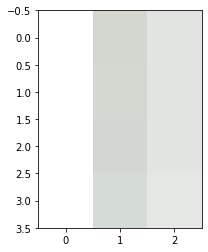

In [ ]:
plt.imshow((real_samples[22].permute(2, 0, 1).detach().cpu().numpy() + 1) / 2)

In [ ]:
!ls -la /tmp/

total 60
drwxrwxrwt 1 root root 4096 Sep 24 06:14 .
drwxr-xr-x 1 root root 4096 Sep 23 22:47 ..
srw------- 1 root root    0 Sep 24 04:55 drivefs_ipc.0
srw------- 1 root root    0 Sep 24 04:55 drivefs_ipc.0_shell
drwx------ 2 root root 4096 Sep 23 23:24 tmp18hrpmpo
drwx------ 2 root root 4096 Sep 24 00:38 tmp4whe8_9s
drwx------ 2 root root 4096 Sep 24 01:00 tmp79bkykeq
drwx------ 2 root root 4096 Sep 24 04:55 tmp_bgibpnn
drwx------ 2 root root 4096 Sep 24 00:53 tmpeig68snb
drwx------ 2 root root 4096 Sep 24 00:37 tmpl1twmsk4
drwx------ 2 root root 4096 Sep 24 04:58 tmpm5r7b_d9
drwx------ 2 root root 4096 Sep 24 04:32 tmpqfcx79nt
drwx------ 2 root root 4096 Sep 24 00:56 tmptdw2gbpo
drwx------ 2 root root 4096 Sep 23 23:56 tmpufqy2tbr
drwx------ 2 root root 4096 Sep 24 06:07 tmpv0u3ob0i
drwx------ 2 root root 4096 Sep 24 01:08 tmpwanl151m
drwx------ 2 root root 4096 Sep 24 00:30 tmpxy6c30iq


In [ ]:
!rm /tmp/tmp*

rm: cannot remove '/tmp/tmp18hrpmpo': Is a directory
rm: cannot remove '/tmp/tmp4whe8_9s': Is a directory
rm: cannot remove '/tmp/tmp79bkykeq': Is a directory
rm: cannot remove '/tmp/tmp_bgibpnn': Is a directory
rm: cannot remove '/tmp/tmpeig68snb': Is a directory
rm: cannot remove '/tmp/tmpl1twmsk4': Is a directory
rm: cannot remove '/tmp/tmpm5r7b_d9': Is a directory
rm: cannot remove '/tmp/tmpqfcx79nt': Is a directory
rm: cannot remove '/tmp/tmptdw2gbpo': Is a directory
rm: cannot remove '/tmp/tmpufqy2tbr': Is a directory
rm: cannot remove '/tmp/tmpv0u3ob0i': Is a directory
rm: cannot remove '/tmp/tmpwanl151m': Is a directory
rm: cannot remove '/tmp/tmpxy6c30iq': Is a directory


In [ ]:
!du -h / | grep '[0-9\.]\+G'

1.3G	/usr/local/lib/python3.6/dist-packages/torch/lib
1.3G	/usr/local/lib/python3.6/dist-packages/torch
6.0G	/usr/local/lib/python3.6/dist-packages
6.1G	/usr/local/lib/python3.6
1.3G	/usr/local/lib/python2.7/dist-packages/torch/lib
1.3G	/usr/local/lib/python2.7/dist-packages/torch
1.1G	/usr/local/lib/python2.7/dist-packages/tensorflow_core/python
1.2G	/usr/local/lib/python2.7/dist-packages/tensorflow_core
6.4G	/usr/local/lib/python2.7/dist-packages
6.4G	/usr/local/lib/python2.7
14G	/usr/local/lib
1.8G	/usr/local/cuda-10.1/targets/x86_64-linux/lib
1.9G	/usr/local/cuda-10.1/targets/x86_64-linux
1.9G	/usr/local/cuda-10.1/targets
776K	/usr/local/cuda-10.1/samples/3_Imaging/simpleCUDA2GL/data
836K	/usr/local/cuda-10.1/samples/3_Imaging/simpleCUDA2GL
3.0G	/usr/local/cuda-10.1
776K	/usr/local/cuda-10.0/samples/3_Imaging/simpleCUDA2GL/data
836K	/usr/local/cuda-10.0/samples/3_Imaging/simpleCUDA2GL
1.5G	/usr/local/cuda-10.0/targets/x86_64-linux/lib
1.6G	/usr/local/cuda-10.0/targets/x86_64-linux


## Test

In [ ]:
RETAIN_STEPS_ONCE = False

In [ ]:
sobcor_loss = losses.correlation(losses.sobel(real_samples.to(DEVICE)), losses.sobel(fake_samples.to(DEVICE)))
cor_loss = losses.correlation(real_samples.to(DEVICE), fake_samples.to(DEVICE))
real_sobel_0 = losses.sobel(real_samples.to(DEVICE))[:, 0, ...].reshape(real_samples.shape[0],1,real_samples.shape[2], real_samples.shape[3])
real_sobel_1 = losses.sobel(real_samples.to(DEVICE))[:, 1, ...].reshape(real_samples.shape[0],1,real_samples.shape[2], real_samples.shape[3])
fake_sobel_0 = losses.sobel(fake_samples.to(DEVICE))[:, 0, ...].reshape(fake_samples.shape[0],1,fake_samples.shape[2], fake_samples.shape[3])
fake_sobel_1 = losses.sobel(fake_samples.to(DEVICE))[:, 1, ...].reshape(fake_samples.shape[0],1,fake_samples.shape[2], fake_samples.shape[3])
real0_sobel = real_samples.to(DEVICE) * real_sobel_0
fake0_sobel = fake_samples.to(DEVICE) * fake_sobel_0
real1_sobel = real_samples.to(DEVICE) * real_sobel_1
fake1_sobel = fake_samples.to(DEVICE) * fake_sobel_1
scor1_loss = losses.correlation(real1_sobel, fake1_sobel) * losses.ssim_loss(real1_sobel, fake1_sobel)
scor0_loss = losses.correlation(real0_sobel, fake0_sobel)
rcor_loss = losses.correlation(real0_sobel, real1_sobel)
fcor_loss = losses.correlation(fake1_sobel, fake0_sobel)
rscor_loss = losses.correlation(real_sobel_0.to(DEVICE), real_samples.to(DEVICE))
fscor_loss = losses.correlation(fake_sobel_0.to(DEVICE), fake_samples.to(DEVICE))

#(sobel[:, 0, :, :] * fake_samples).shape
#(fake_samples * sobel[:, 0, ...].reshape(sobel.shape[0],1,sobel.shape[2], sobel.shape[3])).shape
sobcor_loss, cor_loss, scor1_loss, scor0_loss, rscor_loss, rcor_loss

(tensor(0.8178, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.6836, device='cuda:0'),
 tensor(0.1033, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(0.1985, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(1.1781, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.1974, device='cuda:0', grad_fn=<MeanBackward0>))

In [ ]:
losses.ssim_sobel_loss(real_samples.to(DEVICE), fake_samples.to(DEVICE))

tensor(0.9850, device='cuda:0', grad_fn=<PowBackward1>)

In [ ]:
losses.sobel_correlation_loss(real_samples.to(DEVICE), fake_samples.to(DEVICE))

tensor(0.8178, device='cuda:0', grad_fn=<MeanBackward0>)

In [ ]:
def ssim_correlation_loss(x, y):
    x_sobel = losses.sobel(x)
    y_sobel = losses.sobel(y)
    c_loss = losses.correlation(x_sobel, y_sobel)
    s_loss = losses.ssim(x, y)
    return c_loss * s_loss

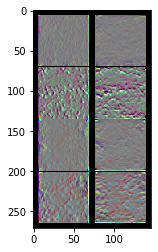

In [ ]:
show_grid(fake1_sobel, fake0_sobel, padding_outer=5, nrow=1)

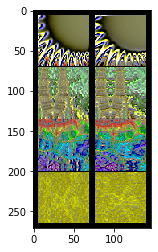

In [ ]:
show_grid(real_samples.cpu() - real1_sobel.cpu(), real_samples.cpu() - real0_sobel.cpu(), padding_outer=5, nrow=1)

In [ ]:
losses.correlation(real_samples.cpu(), real1_sobel.cpu())

tensor(0.4655, grad_fn=<MeanBackward0>)

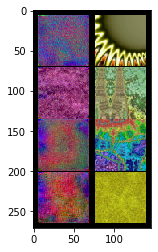

In [ ]:

show_grid(fake_samples.cpu(), real_samples.cpu(), padding_outer=5, nrow=1)

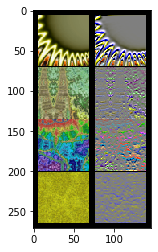

In [ ]:
show_grid(real_samples, real0_sobel, padding_outer=5, nrow=1)

In [ ]:
models["G"].generator[0].ada_norm1.A.linear._forward_pre_hooks.items()

odict_items([(145, <layers.scaled.ScaleWeights object at 0x7f47cb69a7f0>)])

In [ ]:
e_count, msg = generate_reconstruct(real_samples, fake_samples,
                                                     scale, step_name, saved_count, 
                                                     path_root=experiment_root,
                                                     file_name="recon_img")
msg

'[INFO]\t[generate_reconstruct]\t success 22\t/content/gdrive/My Drive/data/alae/fract/fract_test_1024_g'

In [ ]:
e_count, msg = generate_code(real_samples, fake_samples, G, E,
                                                     scale, alpha, step_name, saved_count, 
                                                     path_root=experiment_root,
                                                     file_name="decode_img")
msg

real: torch.Size([64, 3, 8, 8]), fake: torch.Size([64, 3, 8, 8]), recon real: torch.Size([64, 3, 8, 8]), recon fake: torch.Size([64, 3, 8, 8])


"[ERROR]\t[generate_code]\tstep Avg_Random_Generated_Scale_, fake count 64, path root: /content/gdrive/My Drive/data/alae/fract/fract_test_1024_g, error: tensor or list of tensors expected, got <class 'list'>"

In [ ]:
e_count, msg = generate_static_field(G,
                                                             scale, alpha, step_name, saved_count,
                                                             path_root=experiment_root,
                                                             file_name="static_img")
msg

'[INFO]\t[generate_static_field]\t success 22\t/content/gdrive/My Drive/data/alae/fract/fract_test_1024_g'

In [ ]:
e_count, msg = generate_single_field(set_random_field_100, G_average, F, scale, 
                                                             alpha, step_name, saved_count, 
                                                             resize_to=int(scale*2),
                                                             path_root=experiment_root,
                                                             file_name="100/avg_100_rand_field_img") 
msg

'[INFO]\t[generate_static_field]\t success 22\t/content/gdrive/My Drive/data/alae/fract/fract_test_1024_g'

In [ ]:
fake_samples.shape, real_samples.shape

(torch.Size([64, 3, 4, 4]), torch.Size([64, 3, 4, 4]))

In [ ]:
real = real_samples.cpu().detach()
fake = fake_samples.cpu().detach()
real.shape, fake.shape

(torch.Size([4, 3, 64, 64]), torch.Size([4, 3, 64, 64]))

In [ ]:
w.shape, E_z.shape, E_z.view(E_z.shape[0], 1, E_z.shape[1]).repeat(1, w.shape[1], 1).shape

RuntimeError: ignored

## Old Code

In [ ]:
E_z = E(fake_samples, alpha)

In [ ]:
torch.autograd.set_detect_anomaly(True)

In [ ]:
#for scale in [4, 8, 16, 32, 64, 128, 256, 512]:
scale_num = len([4, 8])
for scale in valid_scales:
    scale_num += 1
    epochs = epochs_by_scale[scale]
    batch_size = bs_per_scale[scale]
    SAVE_IMAGES_EACH = 10 if scale > 64 else 100
    SAVE_IMAGES_EACH = SAVE_IMAGES_EACH // 10 if scale > 512 else SAVE_IMAGES_EACH
    
    tracked_images = 0
    total_images_phase = TOTAL_IMAGES * epochs
    limit = int(0.5 * total_images_phase)
    alpha = find_alpha(tracked_images, limit)
        
    warmup = True
    epoch_start = time()

    epoch_errors = 0

    print(f"[INFO]\t Starting scale {scale_num} training, {total_images_phase} total images per phase - alpha becomes 1 at {limit} and output saved every {SAVE_IMAGES_EACH} images ({SAVE_IMAGES_EACH//batch_size} batches)")
    
    # Set necessary learning rate
    for opt in [optimizer_AE, optimizer_G, optimizer_D]:
        adjust_lr(opt, lr_per_resolution[scale])
    total_batches = len(fract)//batch_size
    extra_images = len(fract)%batch_size
    step = 0
    with tqdm_notebook(total=epochs*total_batches*batch_size, unit='Images', unit_scale=True, unit_divisor=1, desc="Epochs") as pbar:
        for epoch in range(epochs):
            for batch_idx, real_samples in enumerate(make_fractal_dataloader(fract, batch_size, image_size=scale)):                
                # In the paper 500k with blending & 500k with alpha=1 for each scale
                alpha = find_alpha(tracked_images, limit)

                # Discriminator loss
                z1 = sample_noise(batch_size, code=code_length, device=DEVICE)
                z2 = sample_noise(batch_size, code=code_length, device=DEVICE)                
                w = F(z1, scale, z2, p_mix=0.9)
                
                real_samples = real_samples.to(DEVICE).requires_grad_()
                fake_samples = G(w, scale, alpha)

                lossD = loss_discriminator(E, D, alpha, real_samples, fake_samples, gamma=10, 
                                           enable_hessian_real=False, enable_hessian_fake=False,
                                           hessian_layers_fake=[1], hessian_layers_real=[1])
                optimizer_D.zero_grad()
                lossD.backward()
                optimizer_D.step()

                # For Generator Diversity Loss
                #z1 = sample_noise(batch_size, code=code_length, device=DEVICE)
                #z2 = sample_noise(batch_size, code=code_length, device=DEVICE)       
                #w = F(z1, scale, z2, p_mix=0.9)
                #fake_samples_1a = G(w, scale, alpha)
                #fake_samples_1b = G_average(w, scale, alpha)

                # Sample 'styles' from normal distibution to be mixed
                z1 = sample_noise(batch_size, code=code_length, device=DEVICE)
                z2 = sample_noise(batch_size, code=code_length, device=DEVICE)
                # Project styles to latent space
                w = F(z1, scale, z2, p_mix=0.9)                
                fake_samples_2a = G(w, scale, alpha)
                #fake_samples_2b = G_average(w, scale, alpha)
                
                # Generator loss
                # Consistency Loss
                #lossGc = consistency_loss(fake_samples_1a, real_samples)  
                # Make it the same as other noise input to encourage logical solution
                #lossGd = diversity_loss(fake_samples_1a, fake_samples_2a) * alpha
                # Make it different from the avg model to encourage diverse solution
                #lossGd = -1 * diversity_loss(fake_samples_2a, fake_samples_2b) * alpha                
                lossG = loss_generator(E, D, alpha, fake_samples, enable_hessian=False, hessian_layers=[1]) #+ lossGd + lossGc
                optimizer_G.zero_grad()
                lossG.backward()
                optimizer_G.step()

                # Autoencoder loss
                z_input = sample_noise(batch_size, code=code_length, device=DEVICE)

                lossAE = loss_autoencoder(F, G, E, scale, alpha, z_input, enable_hessian=True, hessian_layers=[1,2,3])
                optimizer_AE.zero_grad()
                lossAE.backward()
                optimizer_AE.step()

                loss_stats['D'].append(lossD.item())
                loss_stats['G'].append(lossG.item())
                loss_stats['AE'].append(lossAE.item())

                tracked_images += real_samples.shape[0]
                
                # Keep average version of Generator
                G_average.ema(G, beta=0.999) 

                # increment progress bar
                step += 1
                increment_amount = real_samples.shape[0]                
                pbar.update(increment_amount)
                
                if (step % SAVE_IMAGES_EACH) == 0:
                    saved_count = int(step//SAVE_IMAGES_EACH)
                    
                    # Call E to get latent codes, then call G to get images
                    with torch.no_grad():
                        codes_real = E(real_samples, alpha)[:, None, :].repeat(1, int(log2(scale)-1), 1)
                        codes_fake = E(fake_samples, alpha)[:, None, :].repeat(1, int(log2(scale)-1), 1)
                        
                        reconstructions_real = G(codes_real, scale, alpha).cpu().detach()
                        reconstructions_fake = G(codes_fake, scale, alpha).cpu().detach()
                        
                    real, fake = real_samples.cpu().detach(), fake_samples.cpu().detach()

                    # Save generations
                    name = f'Generated_Scale_{scale:04d}/img{saved_count:05d}.png'
                    save_path_str = str(ensure_parent_dir(experiment_root / name))
                    try:
                        save_batch(save_path_str, fake, real, nrows=2, split=(min(4,BS), min(4,BS)))
                        Image.open(save_path_str) \
                            .resize((1024, 1024)) \
                            .save(save_path_str)
                    except Exception as e:
                        epoch_errors += 1
                        if epoch_errors == 10:
                            print(f"[ERROR]\t{e}")
                                        
                    # Save reconstructions (of reals and fakes)
                    name = f'Reconstructed_Scale_{scale:04d}/img{saved_count:05d}.png'
                    save_path_str = str(ensure_parent_dir(experiment_root / name))
                    try:
                        save_reconstructions(save_path_str,
                                            [real, fake],
                                            [reconstructions_real, reconstructions_fake], 
                                            nrows=4)
                        Image.open(save_path_str) \
                            .resize((1536, 512)) \
                            .save(save_path_str)
                    except Exception as e:
                        epoch_errors += 1
                        if epoch_errors == 10:
                            print(f"[ERROR]\t{e}")
                    
                    # Call F on random sample from normal distribution 
                    # Call G with latent output of F to get generated images
                    with torch.no_grad():
                        code = F(set_random_field, scale, z2=None, p_mix=0).chunk(10)
                        generated_imgs = torch.cat([G(c, scale, alpha) for c in code], dim=0)

                    # Save Randomly Generated Latent from normal distribution               
                    name = f'Random_Generated_Scale_{scale:04d}/img{saved_count:05d}.png'
                    save_path_str = str(ensure_parent_dir(experiment_root / name))
                    try:
                        save_image(generated_imgs.cpu().detach(),
                                save_path_str, 
                                nrow=10, 
                                padding=0, 
                                normalize=True, 
                                range=(-1, 1))                
                        Image.open(save_path_str) \
                            .resize((1024, 1024)) \
                            .save(save_path_str)
                    except Exception as e:
                        epoch_errors += 1
                        if epoch_errors == 10:
                            print(f"[ERROR]\t{e}")

                    # save model checkpoint
                    if saved_count % 100 == 0:
                        save_model(experiment_root, scale, name="checkpoint")
                    # Save losses
                    pd.DataFrame(loss_stats).to_csv(str(experiment_root / 'stats.csv'), index=False)
                    pbar.set_postfix(savedfile=name, alpha=round(alpha, 3), refresh=False)
            # Save plot of loss
            make_plots(loss_stats, experiment_root)

            if USE_SCHEDULING & (alpha > 0.99) & (epoch in [int(epochs * 0.6), int(epochs * 0.8)]):
                scheduler_D.step()
                scheduler_G.step()
                scheduler_AE.step()
        save_model(experiment_root, scale, name="final")        

## Visualize Results

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')

In [ ]:
loss_stats_dict = {k:v.get_history() for k, v in loss_stats.items()}
min_stats_len = min([len(v.get_history()) for k, v in loss_stats.items() if len(v.get_history())>0])
min_stats_len

2642

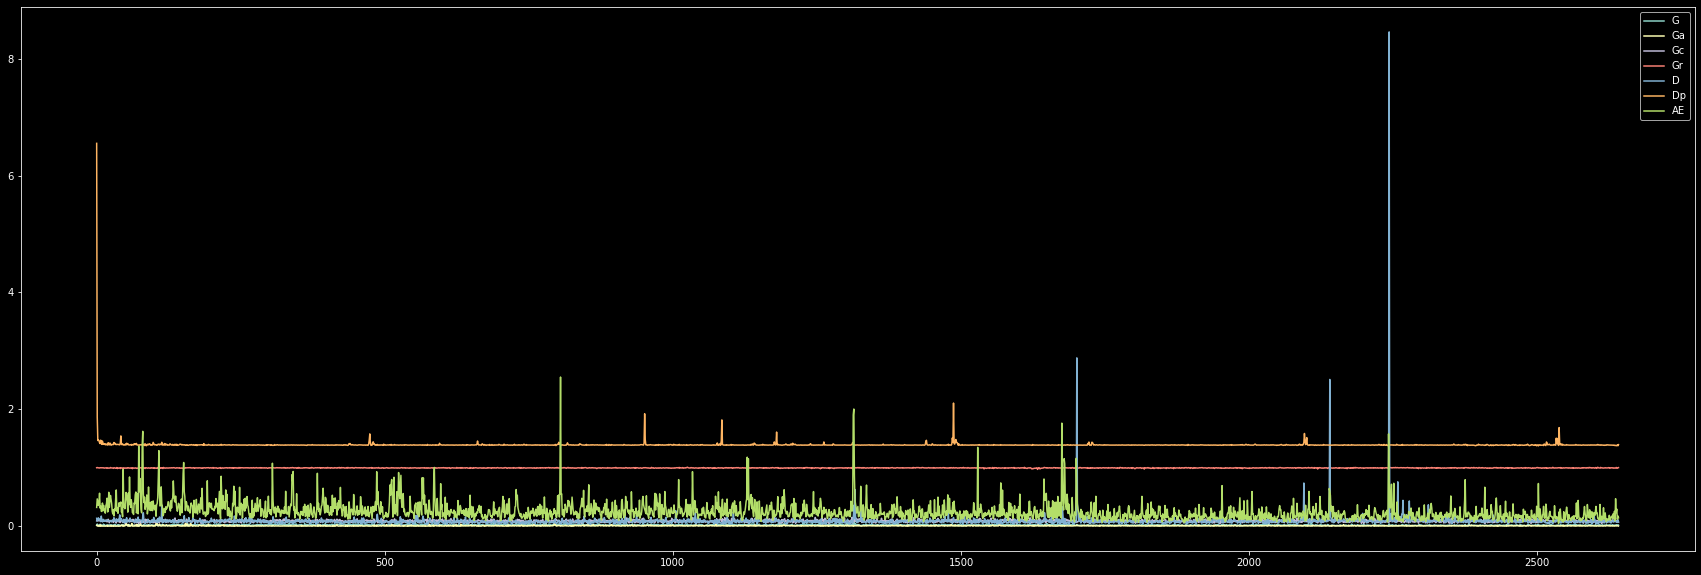

In [ ]:
df = pd.DataFrame({k:v.get_history()[:min_stats_len] for k, v in loss_stats.items() if len(v.get_history())>0})
df.plot(figsize=(30,10))

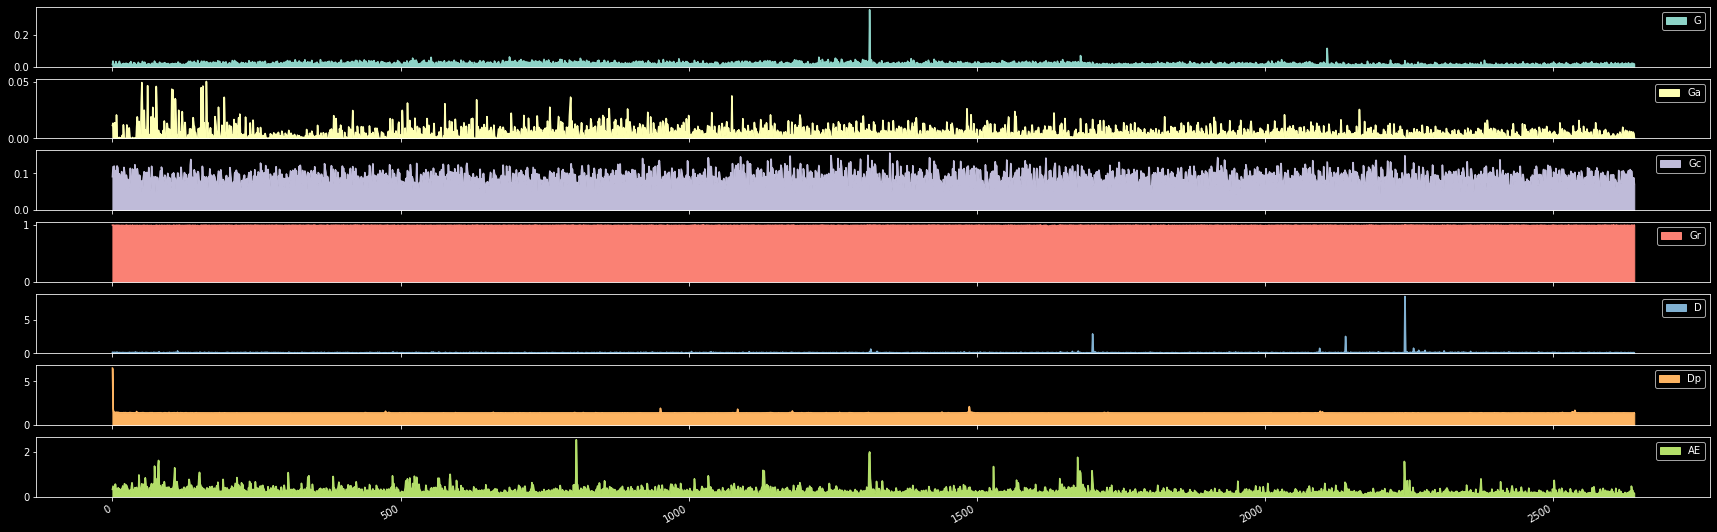

In [ ]:
df.plot.area(subplots=True, figsize=(30,10))
plt.savefig('/content/test.png')

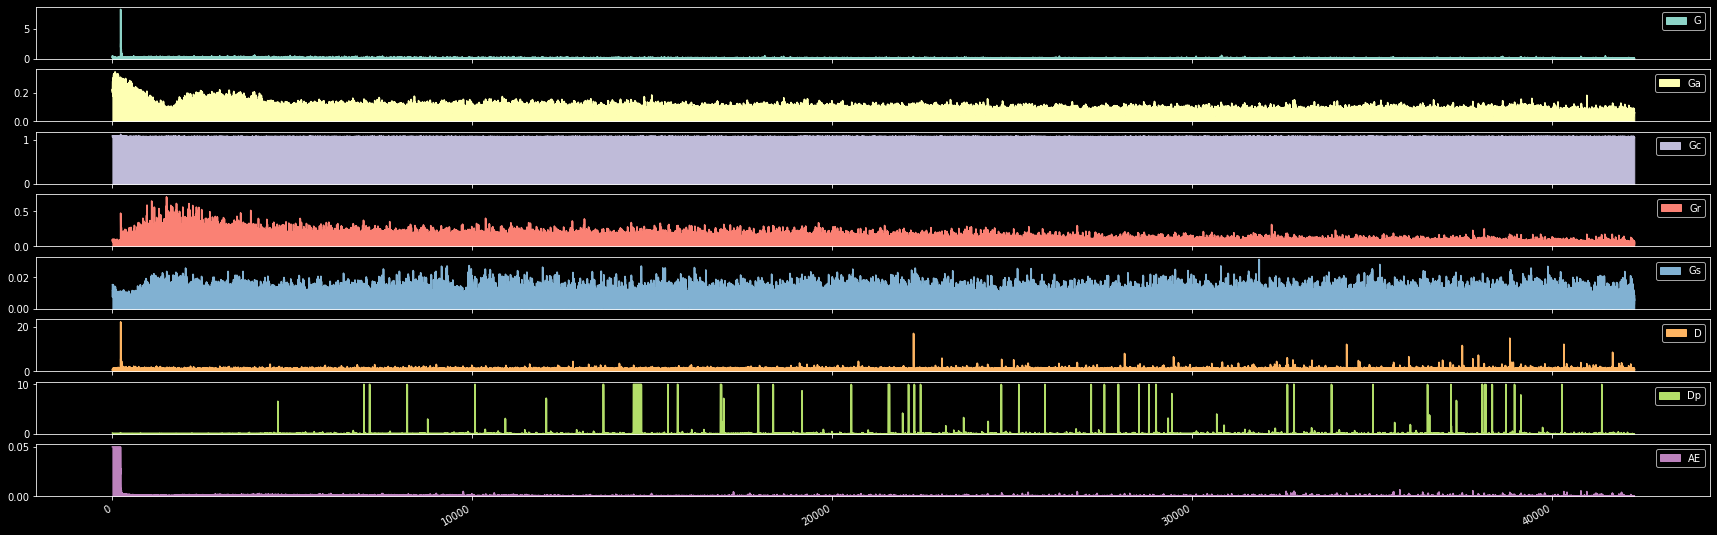

In [ ]:
df.plot.area(subplots=True, figsize=(30,10))
plt.savefig('/content/test.png')

In [ ]:
!ls -la '/content/gdrive/My Drive/data/alae/fract/fract_test_512_e/Scale512.pt'
!cp '/content/gdrive/My Drive/data/alae/fract/fract_test_512_e/Scale512.pt' '/content/gdrive/My Drive/data/alae/fract/Scale512_b.pt'

-rw------- 1 root root 692274475 Aug 29 23:31 '/content/gdrive/My Drive/data/alae/fract/fract_test_512_e/Scale512.pt'


In [ ]:
#!rm -r '/content/gdrive/My Drive/data/alae/fract/fract_test/models'
#!mkdir '/content/gdrive/My Drive/data/alae/fract/fract_test/models/'
#!cp -r '/content/output/' '/content/gdrive/My Drive/data/alae/fract/' 
!ls -la '/content/gdrive/My Drive/data/alae/fract/'
#!cp '/content/fract_test/Scale4.pt' '/content/gdrive/My Drive/data/alae/fract/fract_test/models/Scale4.pt' 
#!cp '/content/fract_test/Scale8.pt' '/content/gdrive/My Drive/data/alae/fract/fract_test/models/Scale8.pt' 
#!cp '/content/fract_test/Scale16.pt' '/content/gdrive/My Drive/data/alae/fract/fract_test/models/Scale16.pt' 
#!cp '/content/fract_test/Scale32.pt' '/content/gdrive/My Drive/data/alae/fract/fract_test/models/Scale32.pt' 
#!cp '/content/fract_test/Scale64.pt' '/content/gdrive/My Drive/data/alae/fract/fract_test/models/Scale64.pt' 
#!cp '/content/fract_test/Scale128.pt' '/content/gdrive/My Drive/data/alae/fract/fract_test/models/Scale128.pt' 
#!cp '/content/saved/checkpoint_32.pt' '/content/gdrive/My Drive/data/alae/fract/good32.pt' 
#!cp '/content/fract_test/Scale512.pt' '/content/gdrive/My Drive/data/alae/fract/fract_test/models/Scale512.pt' 
!ls -la '/content/gdrive/My Drive/data/alae/fract_test/fract/'

total 1539907
-rw------- 1 root root 192179903 Aug 29 04:46 alae.zip
drwx------ 2 root root      4096 Aug 27 12:00 fract_test
drwx------ 2 root root      4096 Aug 30 01:09 fract_test_1024_a
drwx------ 2 root root      4096 Aug 30 04:36 fract_test_1024_b
drwx------ 2 root root      4096 Aug 30 14:12 fract_test_1024_c
drwx------ 2 root root      4096 Aug 30 17:33 fract_test_1024_d
drwx------ 2 root root      4096 Aug 31 02:41 fract_test_1024_e
drwx------ 2 root root      4096 Aug 31 05:34 fract_test_1024_f
drwx------ 2 root root      4096 Aug 31 10:18 fract_test_1024_g
drwx------ 2 root root      4096 Sep  1 13:22 fract_test_1024_h
drwx------ 2 root root      4096 Sep  1 15:20 fract_test_1024_i
drwx------ 2 root root      4096 Sep  1 16:41 fract_test_1024_j
drwx------ 2 root root      4096 Sep  3 02:01 fract_test_1024_k
drwx------ 2 root root      4096 Sep  3 06:01 fract_test_1024_l
drwx------ 2 root root      4096 Sep  3 06:55 fract_test_1024_m
drwx------ 2 root root      4096 Sep  3 09

In [ ]:
#!cp '/content/fract_test/Scale128.pt' '/content/gdrive/My Drive/data/alae/fract/fract_test/test/Scale128.pt' 
!zip -o '/content/output.zip' -r /content/output/ -q

## Test Model

In [ ]:

def sigmoid(x, w=1):
    return 1. / (1 + np.exp(-w * x))


def get_alphas(start=-5, end=5, step=0.5, len_tail=10):
    return [0] + [sigmoid(alpha) for alpha in np.arange(start, end, step)] + [1] * len_tail


def interpolate(G, args, x_src, s_prev, s_next):
    ''' returns T x C x H x W '''
    B = x_src.size(0)
    frames = []
    masks = nets.fan.get_heatmap(x_src) if args.w_hpf > 0 else None
    alphas = get_alphas()

    for alpha in alphas:
        s_ref = torch.lerp(s_prev, s_next, alpha)
        x_fake = nets.generator(x_src, s_ref, masks=masks)
        entries = torch.cat([x_src.cpu(), x_fake.cpu()], dim=2)
        frame = torchvision.utils.make_grid(entries, nrow=B, padding=0, pad_value=-1).unsqueeze(0)
        frames.append(frame)
    frames = torch.cat(frames)
    return frames


def slide(entries, margin=32):
    """Returns a sliding reference window.
    Args:
        entries: a list containing two reference images, x_prev and x_next, 
                 both of which has a shape (1, 3, 256, 256)
    Returns:
        canvas: output slide of shape (num_frames, 3, 256*2, 256+margin)
    """
    _, C, H, W = entries[0].shape
    alphas = get_alphas()
    T = len(alphas) # number of frames

    canvas = - torch.ones((T, C, H*2, W + margin))
    merged = torch.cat(entries, dim=2)  # (1, 3, 512, 256)
    for t, alpha in enumerate(alphas):
        top = int(H * (1 - alpha))  # top, bottom for canvas
        bottom = H * 2
        m_top = 0  # top, bottom for merged
        m_bottom = 2 * H - top
        canvas[t, :, top:bottom, :W] = merged[:, :, m_top:m_bottom, :]
    return canvas


In [ ]:
get_alphas()

[0,
 0.0066928509242848554,
 0.01098694263059318,
 0.01798620996209156,
 0.02931223075135632,
 0.04742587317756678,
 0.07585818002124355,
 0.11920292202211755,
 0.18242552380635635,
 0.2689414213699951,
 0.3775406687981454,
 0.5,
 0.6224593312018546,
 0.7310585786300049,
 0.8175744761936437,
 0.8807970779778823,
 0.9241418199787566,
 0.9525741268224334,
 0.9706877692486436,
 0.9820137900379085,
 0.9890130573694068,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [ ]:
x_series = np.linspace(-10, 10, num=512, retstep=False)
y_series = np.linspace(-1, 1, num=100, retstep=False)
field = np.expand_dims(np.stack([y * x_series for y in y_series]), 0)
field.shape, field[0][0][:5], field[0].shape

((1, 100, 512),
 array([10.        ,  9.96086106,  9.92172211,  9.88258317,  9.84344423]),
 (100, 512))

In [ ]:
#@title Create latent sample

alpha = 1.0
batch_size = 1
scale = 32

z1 = sample_noise(batch_size, code=code_length, device=DEVICE)
z2 = sample_noise(batch_size, code=code_length, device=DEVICE)
w = models["F"](z1, scale, z2, p_mix=0.9)

dataloader = dataset.make_fractal_alae_dataloader(fract, batch_size, image_size=scale)
real_samples = next(iter(dataloader))
w.shape, scale, alpha, z1.shape, z2.shape, code_length, real_samples.shape

(torch.Size([1, 4, 512]),
 32,
 1.0,
 torch.Size([1, 512]),
 torch.Size([1, 512]),
 512,
 torch.Size([1, 3, 32, 32]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


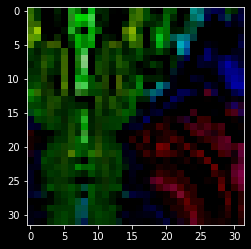

In [ ]:
plt.imshow(real_samples[0].numpy().transpose((1,2,0)))

(tensor(0.3935, device='cuda:0'),
 tensor(0.0787, device='cuda:0'),
 torch.Size([1, 512]),
 torch.Size([1, 512]),
 torch.Size([1, 3, 32, 32]),
 torch.Size([1, 3, 32, 32]),
 <matplotlib.image.AxesImage at 0x7f4476312f28>)

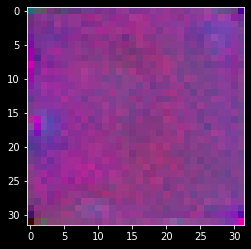

In [ ]:
# In the paper 500k with blending & 500k with alpha=1 for each scale
alpha = 1.0

# Discriminator loss
z1 = sample_noise(batch_size, code=code_length, device=DEVICE)
z2 = sample_noise(batch_size, code=code_length, device=DEVICE)

with torch.no_grad():
    w = models["F"](z1, scale, z2, p_mix=0.9)
    
    real_samples = real_samples.to(DEVICE)
    fake_samples = models["G"](w, scale, alpha)

mean_diff = (z1-z2).mean()
mean_abs_diff = (fake_samples - real_samples).abs().mean()
mean_abs_diff, mean_diff, z1.shape, z2.shape, fake_samples.shape, real_samples.shape, plt.imshow(img_from_tensor(fake_samples))

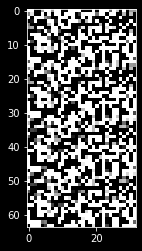

In [ ]:
plt.imshow(img_from_tensor(w.reshape(1,64,32).repeat(3,1,1)))

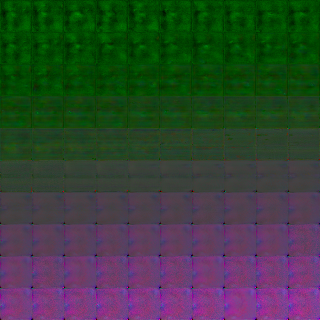

In [ ]:
WIDTH = 10
HEIGHT = 10
total = WIDTH * HEIGHT
w_min = w.min().cpu().detach()
w_max = w.max().cpu().detach()

x_series = np.linspace(1, 1, num=512, retstep=False)
y_series = np.linspace(-1, 1, num=total, retstep=False)
field = np.expand_dims(np.stack([y * x_series for y in y_series]), 0)
fake_samples = []
for f in field[0]:
    selected_field = np.expand_dims(np.repeat(np.expand_dims(f, 0), 4, 0), 0)
    with torch.no_grad():
        w_hat = torch.FloatTensor(selected_field).to(DEVICE)
        w_hat *= w
        fake_samples.append(models["G"](w_hat, scale, alpha))

outputs = torch.stack(fake_samples).squeeze()

name = f'Gen_Static_field_{scale:03d}/Img{int(tracked_images//SAVE_IMAGES_EACH):03d}.png'
save_image(outputs.cpu().detach(),
        str(ensure_parent_dir(experiment_root / name)), nrow=WIDTH, padding=0, normalize=True, range=(-1, 1))                
Image.open(str(ensure_parent_dir(experiment_root / name))).resize((scale * WIDTH, scale * HEIGHT))

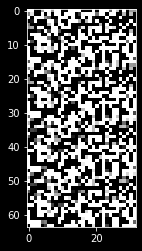

In [ ]:
plt.imshow(img_from_tensor(w.reshape(1,64,32).repeat(3,1,1)))

In [ ]:
z1, z2 = sample_noise(batch_size, code=code_length, device=DEVICE), sample_noise(batch_size, code=code_length, device=DEVICE)
with torch.no_grad():
    w = models["F"](z1, scale, z2, p_mix=0.9)
    fake_samples = models["G"](w, scale, alpha)
np_fake_samples = fake_samples.cpu().detach().numpy()
np_fake_samples.shape

(1, 3, 32, 32)

In [ ]:
with torch.no_grad():
    codes_real = models["E"](real_samples, alpha)[:, None, :].repeat(1, int(log2(scale)-1), 1)
    codes_fake = models["E"](fake_samples, alpha)[:, None, :].repeat(1, int(log2(scale)-1), 1)
    
    reconstructions_real = models["G"](codes_real, scale, alpha).cpu().detach()
    reconstructions_fake = models["G"](codes_fake, scale, alpha).cpu().detach()
    
real, fake = real_samples.cpu().detach(), fake_samples.cpu().detach()

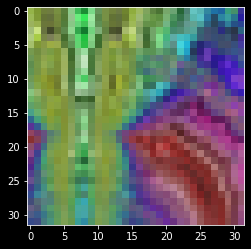

In [ ]:
plt.imshow(img_from_tensor(real))

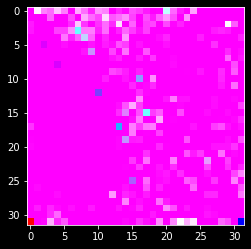

In [ ]:
plt.imshow(img_from_tensor(reconstructions_real))

In [ ]:
codes_real.shape, codes_fake.shape, codes_real[0][0][:5], codes_fake[0][2][:5]

(torch.Size([1, 4, 512]),
 torch.Size([1, 4, 512]),
 tensor([ 12.2801,   6.0782,  -5.6283, -39.1121,  -2.9250], device='cuda:0'),
 tensor([  5.3654,   1.5532,  -4.5353, -47.4920,  -8.7740], device='cuda:0'))

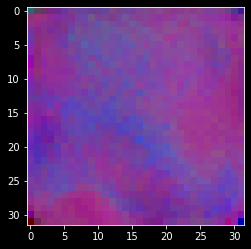

In [ ]:
lerped = torch.lerp(codes_real[0][0], codes_fake[0][0], 0.01).reshape((1,512))
#x = models["G"](lerped, scale, alpha).cpu().detach()[0]
with torch.no_grad():
    w = models["F"](lerped, scale, None, p_mix=0)
    x = models["G"](w, scale, alpha)
plt.imshow(img_from_tensor(x))

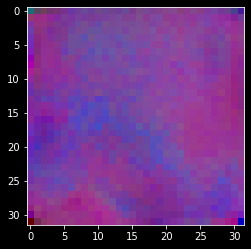

In [ ]:
lerped = torch.lerp(codes_real[0][1], codes_fake[0][2], 0.1).unsqueeze(0) #.repeat(8).reshape((8,512))
with torch.no_grad():
    w = models["F"](lerped, scale, None, p_mix=0)
    x = models["G"](w, scale, alpha)
plt.imshow(img_from_tensor(x))

In [ ]:
def img_from_tensor(x):
    if len(x.shape) > 3:
        x = x.squeeze().cpu().detach()
    return ((x * 0.5 + 0.5) * 255).type(torch.long).clamp(0, 255).cpu().type(torch.uint8).transpose(0, 2).transpose(0, 1).numpy()

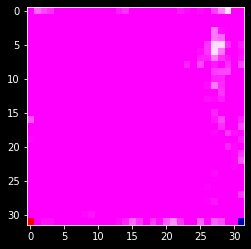

In [ ]:
lerp_code = torch.lerp(codes_fake[0][0], codes_real[0][0], 0.1).repeat(8).reshape((8,512))
lerp_code = lerp_code.expand([1,8,512])
x = models["G"](lerp_code, scale, alpha).cpu().detach()[0]
#img_src = ((x * 0.5 + 0.5) * 255).type(torch.long).clamp(0, 255).cpu().type(torch.uint8).transpose(0, 2).transpose(0, 1).numpy()
plt.imshow(img_from_tensor(x))

[0]	 value range: 1.4417636394500732, -2.2480924129486084
[0]	 value range: 1.0, 0.0


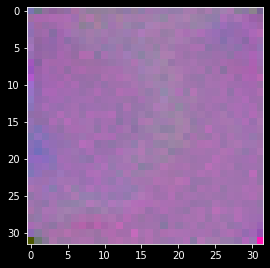

In [ ]:
plt.figure(figsize=(20,20))
for i, img in enumerate(fake):       
    plt.subplot(4, 4, i + 1)
    print(f"[{i}]\t value range: {img.max()}, {img.min()}")
    img = (img - img.min()) / (img.max() - img.min())
    print(f"[{i}]\t value range: {img.max()}, {img.min()}")
    plt.imshow(img.permute(1, 2, 0))    

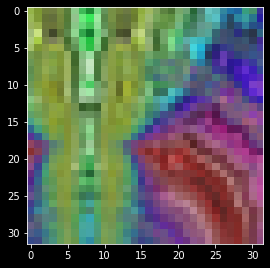

In [ ]:
plt.figure(figsize=(20,20))
for i, r in enumerate(real):
    shape = r.shape    
    plt.subplot(4, 4, i + 1)
    r = (r + 1) / 2
    plt.imshow(r.permute(1, 2, 0))    

In [ ]:
terracotta_army = sample_noise(100, code=code_length, device=DEVICE)
terracotta_army.shape

torch.Size([100, 512])

In [ ]:
with torch.no_grad():
    code = models["F"](terracotta_army, scale, z2=None, p_mix=0).chunk(10)
    print(f"Code shape: {code[0].shape}")
    generated_latent = torch.cat([models["G"](c, scale, alpha) for c in code], dim=0)
tracked_images += SAVE_IMAGES_EACH
np_fake_samples = generated_latent.cpu().detach().numpy()
np_fake_samples.shape

Code shape: torch.Size([10, 4, 512])


(100, 3, 32, 32)

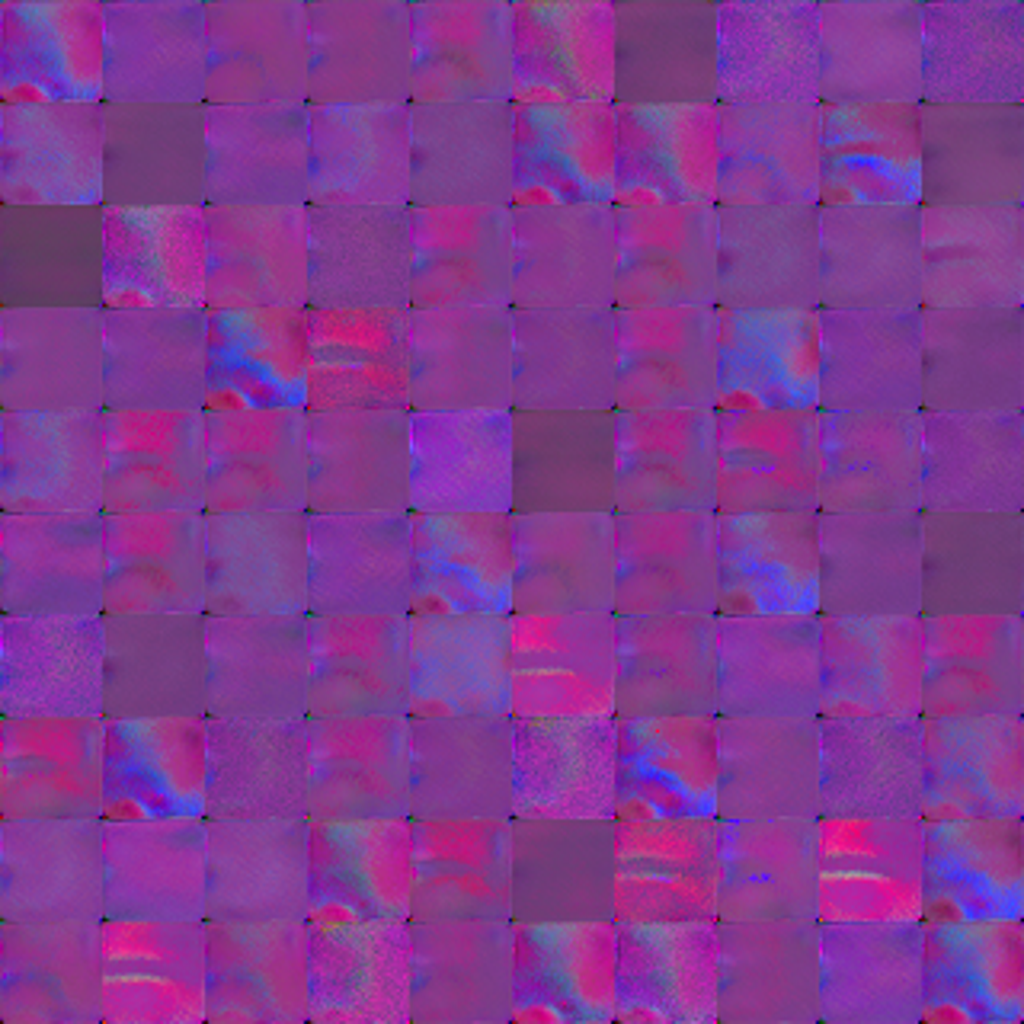

In [ ]:
name = f'Generated_Scale{scale:03d}/Img{int(tracked_images//SAVE_IMAGES_EACH):03d}.png'
save_image(generated_latent.cpu().detach(),
        str(ensure_parent_dir(experiment_root / name)), nrow=10, padding=0, normalize=True, range=(-1, 1))                
Image.open(str(ensure_parent_dir(experiment_root / name))).resize((1024, 1024))

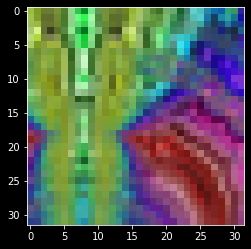

In [ ]:
img = real_samples[0].cpu().detach().numpy().transpose((1, 2, 0))
img = (img - img.min()) / (img.max() - img.min())
plt.imshow(img)

(32, 32, 100, 3)


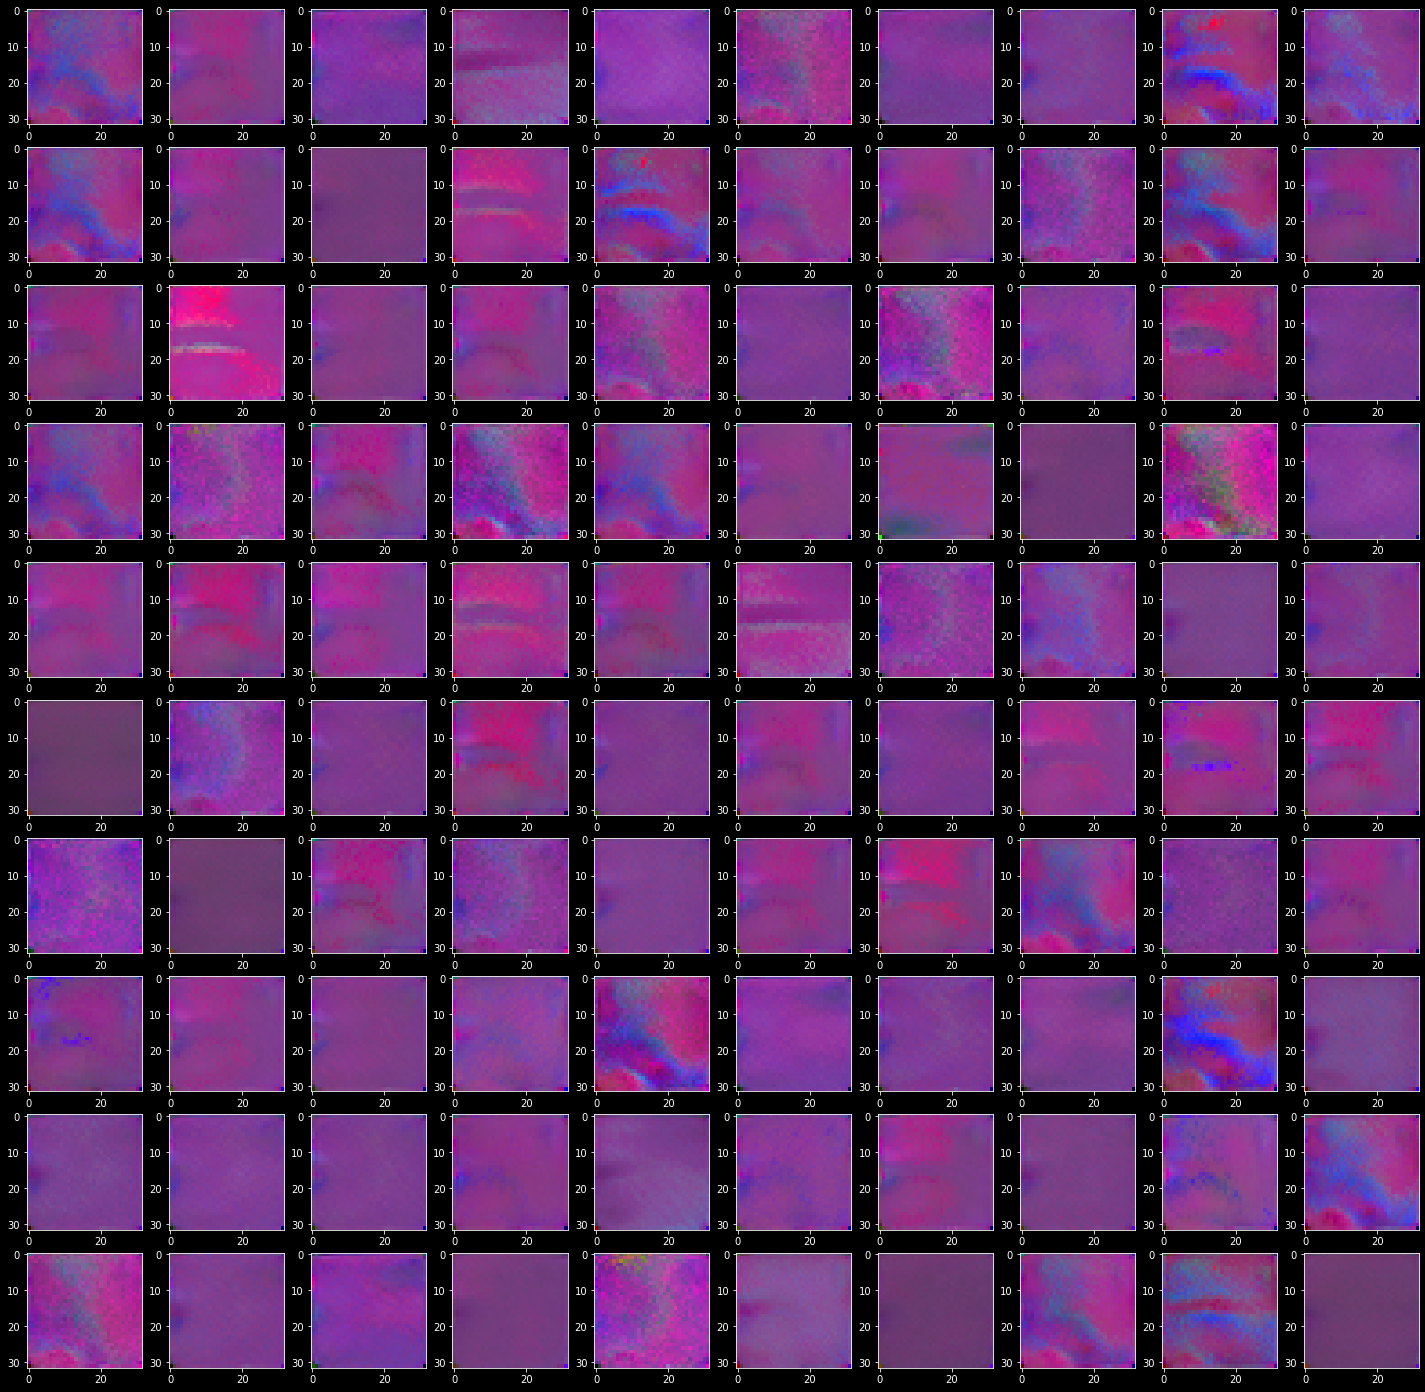

In [ ]:
img = np.stack(np_fake_samples.transpose(1, 2, 3, 0), axis=-1)
print(img.shape)
plt.figure(figsize=(25,25))
for i, sample in enumerate(np_fake_samples):
    plt.subplot(10, 10, i + 1)    
    img = sample.transpose(1, 2, 0)
    #img = (img - img.min()) / (img.max() - img.min())
    img = np.clip((img + 1) / 2, 0, 1)
    plt.imshow(img)

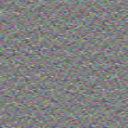

In [ ]:
#torch.pca_lowrank(generated_latent)[0].shape
name = f'pca_Generated_Scale{scale:03d}/Img{int(tracked_images//SAVE_IMAGES_EACH):03d}.png'
save_image(torch.pca_lowrank(generated_latent)[0].cpu().detach(),
        str(ensure_parent_dir(experiment_root / name)), nrow=10, padding=0, normalize=True, range=(-1, 1))                
Image.open(str(ensure_parent_dir(experiment_root / name))).resize((128, 128))